### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- write currently uses a complex prompt with all the stories instead
  - filter to eg top 50 by rating
  - ignoring stories with already assigned bucket, use a model_medium prompt to put each story in an existing topic bucket, or other
  - write a section independently for each non-empty topic bucket using model_high
  - assemble all the sections and rewrite using a critic-refine flow
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts
- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-15 21:25:03,212 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=103b01ac34d540acbf9982f68da60df2
2025-05-15 21:25:03,313 - AInewsbot - INFO - thread_id: 103b01ac34d540acbf9982f68da60df2


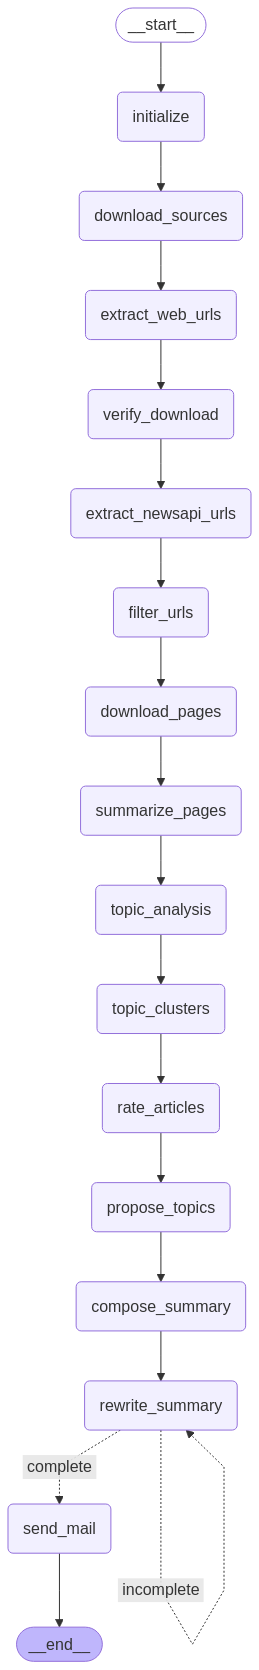

In [7]:
before_date = None
# before_date = '2025-05-14 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [8]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-15 21:25:04,197 - AInewsbot - INFO - run exception
2025-05-15 21:25:04,198 - AInewsbot - INFO - 'src'
2025-05-15 21:25:04,209 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-15 21:25:04,210 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-15 21:25:04,210 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-15 21:25:04,211 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-15 21:25:04,211 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-15 21:25:04,211 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYW

2025-05-15 21:25:04,515 - AInewsbot - INFO - parse_file - found 338 raw links
2025-05-15 21:25:04,518 - AInewsbot - INFO - parse_file - found 45 filtered links
2025-05-15 21:25:04,518 - AInewsbot - INFO - 45 links found
2025-05-15 21:25:04,518 - AInewsbot - INFO - WSJ -> htmldata/WSJ.html
2025-05-15 21:25:04,536 - AInewsbot - INFO - parse_file - found 113 raw links
2025-05-15 21:25:04,537 - AInewsbot - INFO - parse_file - found 26 filtered links
2025-05-15 21:25:04,537 - AInewsbot - INFO - 26 links found
2025-05-15 21:25:04,537 - AInewsbot - INFO - Washington Post -> htmldata/Washington_Post.html
2025-05-15 21:25:04,556 - AInewsbot - INFO - parse_file - found 256 raw links
2025-05-15 21:25:04,558 - AInewsbot - INFO - parse_file - found 62 filtered links
2025-05-15 21:25:04,558 - AInewsbot - INFO - 62 links found
2025-05-15 21:25:04,559 - AInewsbot - INFO - Saved 1017 links


,id
src,
Ars Technica,29
Bloomberg,29
Business Insider,22
FT,61
Feedly AI,32
Hacker News 1,23
Hacker News 2,25
HackerNoon,31
New York Times,18


2025-05-15 21:25:04,566 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,29
Bloomberg,29
Business Insider,22
FT,61
Feedly AI,32
Hacker News 1,23
Hacker News 2,25
HackerNoon,31
New York Times,18


2025-05-15 21:25:04,570 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-14T21:25:04 from NewsAPI


,id
src,
Ars Technica,29
Bloomberg,29
Business Insider,22
FT,61
Feedly AI,32
Hacker News 1,23
Hacker News 2,25
HackerNoon,31
New York Times,18


2025-05-15 21:25:04,720 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-15 21:25:05,310 - AInewsbot - INFO - URLs in orig_df: 862
2025-05-15 21:25:05,313 - AInewsbot - INFO - Existing URLs in DB: 259548
2025-05-15 21:25:05,371 - AInewsbot - INFO - New URLs in df filtered by URL: 185
2025-05-15 21:25:05,499 - AInewsbot - INFO - Existing src+title: 38
2025-05-15 21:25:05,500 - AInewsbot - INFO - New URLs in df filtered by src+title: 147
2025-05-15 21:25:05,513 - AInewsbot - INFO - Found 147 unique new headlines
2025-05-15 21:25:05,514 - AInewsbot - INFO - Found 146 unique cleaned new headlines
2025-05-15 21:25:13,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:25:15,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:25:15,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:25:15,6

,id
src,
Ars Technica,1
Bloomberg,7
Business Insider,3
FT,2
Feedly AI,28
Hacker News 1,1
Hacker News 2,2
NewsAPI,15
Reddit,3


2025-05-15 21:25:15,670 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-15 21:25:15,673 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-15 21:25:15,823 - AInewsbot - INFO - Launching browser
2025-05-15 21:25:16,840 - AInewsbot - INFO - Launching workers
2025-05-15 21:25:16,840 - AInewsbot - INFO - Launching worker
2025-05-15 21:25:16,841 - AInewsbot - INFO - from queue: 0, https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/ , 30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia
2025-05-15 21:25:16,841 - AInewsbot - INFO - fetch_url(https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/)
2025-05-15 21:25:16,855 - AInewsbot - INFO - Launching worker
2025-05-15 21:25:16,855 - AInewsbot - INFO - from queue: 1, https://bgr.com/tech/ai-mimicked-human-communication-in-this-fascinating-study/ , AI mimicked human communication in this fascinating st

2025-05-15 21:25:48,620 - AInewsbot - INFO - fetch_url(https://fortune.com/2025/05/15/chatgpt-openai-northeastern-college-student-tuition-fees-back-catching-professor/)
2025-05-15 21:25:52,410 - AInewsbot - INFO - Waiting 38.02317809296315 seconds to rate limit siliconangle.com 0.021756582999842067
2025-05-15 21:25:59,565 - AInewsbot - INFO - Saving HTML to htmlpages/CNBC_Daily_Open__Nvidia_is_back_in_the_green_amid_Trump_s_dealmaking.html
2025-05-15 21:25:59,585 - AInewsbot - INFO - from queue: 16, https://siliconangle.com/2025/05/14/coreweave-shares-fall-missing-eps-estimates-first-earnings-since-nasdaq-debut/ , CoreWeave shares fall after missing EPS estimates in first earnings since Nasdaq debut
2025-05-15 21:25:59,586 - AInewsbot - INFO - fetch_url(https://siliconangle.com/2025/05/14/coreweave-shares-fall-missing-eps-estimates-first-earnings-since-nasdaq-debut/)
2025-05-15 21:26:01,791 - AInewsbot - INFO - Saving HTML to htmlpages/ChatGPT_will_soon_record__transcribe__and_summariz

2025-05-15 21:26:50,731 - AInewsbot - INFO - from queue: 29, https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/ , House budget bill would put 10-year pause on state AI regulation
2025-05-15 21:26:50,731 - AInewsbot - INFO - fetch_url(https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)
2025-05-15 21:26:52,689 - AInewsbot - INFO - Saving HTML to htmlpages/Fake_fired_Twitter_worker_Rahul_Ligma_is_a_real_engineer_with_an_AI_data_startup_used_by_Harvard.html
2025-05-15 21:26:52,709 - AInewsbot - INFO - from queue: 30, https://www.techradar.com/computing/artificial-intelligence/i-compared-chatgpt-4-1-to-o3-and-4o-to-find-the-most-logical-ai-model-the-result-seems-irrational , I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational
2025-05-15 21:26:52,710 - AInewsbot - INFO - fetch_url(ht

2025-05-15 21:27:43,120 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)
2025-05-15 21:27:47,500 - AInewsbot - INFO - Saving HTML to htmlpages/My_husband_was_laid_off_from_Microsoft_by_an_algorithm__after_25_years.html
2025-05-15 21:27:47,584 - AInewsbot - INFO - from queue: 44, https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/ , Report: Terrorist seems to be paying X to generate propaganda with Grok
2025-05-15 21:27:47,584 - AInewsbot - INFO - fetch_url(https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)
2025-05-15 21:27:48,254 - AInewsbot - INFO - Saving HTML to htmlpages/Netflix_Will_Show_Generative_AI_Ads_Midway_Through_Streams_In_2026.html
2025-05-15 21:27:48,379 - AInewsbot - INFO - from queue: 45, https://www.businessinsider.com/s

2025-05-15 21:28:29,675 - AInewsbot - INFO - fetch_url(https://nypost.com/2025/05/15/business/trump-strikes-historic-deal-with-uae-to-build-biggest-ai-campus-outside-us/)
2025-05-15 21:28:31,274 - AInewsbot - INFO - Waiting 45.27779614384731 seconds to rate limit venturebeat.com 0.03862858299999061
2025-05-15 21:28:36,290 - AInewsbot - INFO - Saving HTML to htmlpages/The_HackerNoon_Newsletter__Why_Humanitys_Slow_Space_Progress_Lags_AI-and_What_That_Means_for_Survival__5_15_2025.html
2025-05-15 21:28:36,329 - AInewsbot - INFO - from queue: 58, https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837 , US administration considers adding Chinese chipmakers to export blacklist
2025-05-15 21:28:36,329 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)
2025-05-15 21:28:36,613 - AInewsbot - INFO - Waiting 49.738678189909294 seconds to rate limit siliconangle.com 0.015872292000040034
2025-05-15 21:28:43,517 - AInewsbot - INFO - Saving HTML to

,id
src,
Ars Technica,1
Bloomberg,7
Business Insider,3
FT,2
Feedly AI,28
Hacker News 1,1
Hacker News 2,2
NewsAPI,15
Reddit,3


2025-05-15 21:29:42,569 - AInewsbot - INFO - Starting summarize
2025-05-15 21:29:42,570 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-15 21:29:42,570 - AInewsbot - INFO - Attempting to fetch summaries for 68 articles
2025-05-15 21:29:42,591 - AInewsbot - INFO - clean_html - Page title: 30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia
Social card title: 30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia
Social card description: From developing their own models to building tailored services, Asia’s young founders are at the forefront of the AI revolution.

2025-05-15 21:29:43,346 - AInewsbot - INFO - Queuing 0: Page title: 30 Under 30: Meet The Young Entreprene...
2025-05-15 21:29:43,347 - AInewsbot - INFO - No path for 1
2025-05-15 21:29:43,442 - AInewsbot - INFO - clean_html - Page title: AI's Hidden Power: Former Google CEO Says We're All Missing the Point - Decrypt
Social card title: AI's Hidden Power: Former Google CEO Says We're All Missing 

2025-05-15 21:29:44,492 - AInewsbot - INFO - Queuing 19: Page title: Entrepreneur forum highlights China-UK...
2025-05-15 21:29:44,506 - AInewsbot - INFO - clean_html - Page title: Expedia Group expands B2B platform APIs, launches GenAI tools
Social card title: Expedia Group expands B2B platform and launches GenAI tools
Social card description: Central to the Expedia announcement is the new set of APIs designed to give B2B partners more control over travel packaging and operations.

2025-05-15 21:29:44,517 - AInewsbot - INFO - Queuing 20: Page title: Expedia Group expands B2B platform API...
2025-05-15 21:29:44,531 - AInewsbot - INFO - clean_html - Page title: FBI warns of ongoing scam that uses deepfake audio to impersonate government officials - Ars Technica
Social card title: FBI warns of ongoing scam that uses deepfake audio to impersonate government officials
Social card description: Warning comes as the use of deepfakes in the wild are rising.

2025-05-15 21:29:44,545 - AInewsbot

2025-05-15 21:29:44,963 - AInewsbot - INFO - No path for 36
2025-05-15 21:29:44,978 - AInewsbot - INFO - clean_html - Page title: Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE
Social card title: Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE
Social card description: Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE

2025-05-15 21:29:44,996 - AInewsbot - INFO - Queuing 37: Page title: Meta to postpone release of Llama 4 Be...
2025-05-15 21:29:45,086 - AInewsbot - INFO - clean_html - Page title: My husband was laid off from Microsoft by an algorithm — after 25 years, his last day is his birthday : TrueOffMyChest
Social card title: My husband was laid off from Microsoft by an algorithm — after 25 years, his last day is his birthday
Social card description: My husband has worked for Microsoft for 25 years. He was just laid off — randomly selected by a computer algorithm. His last day is this

2025-05-15 21:29:45,841 - AInewsbot - INFO - Queuing 51: Page title: Tech-Driven Vehicle Damage Assessments...
2025-05-15 21:29:45,850 - AInewsbot - INFO - clean_html - Page title: The $1 Billion database bet: What Databricks' Neon acquisition means for your AI strategy | VentureBeat
Social card title: The $1 Billion database bet: What Databricks’ Neon acquisition means for your AI strategy
Social card description: Databricks' $1 billion acquisition of Neon highlights how serverless PostgreSQL has become essential for agentic AI development.

2025-05-15 21:29:45,860 - AInewsbot - INFO - Queuing 52: Page title: The $1 Billion database bet: What Data...
2025-05-15 21:29:45,860 - AInewsbot - INFO - No path for 53
2025-05-15 21:29:45,872 - AInewsbot - INFO - clean_html - Page title: The HackerNoon Newsletter: Why Humanity’s Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025) | HackerNoon
Social card title: The HackerNoon Newsletter: Why Humanity’s Slow Space Progress L

2025-05-15 21:29:48,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:48,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:48,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:49,058 - httpx 

2025-05-15 21:29:50,740 - AInewsbot - INFO - Summary for 5 (length 8880): • A lawyer representing Anthropic admitted in a Northern California court filing to using an erroneous legal citation generated by the company's AI chatbot Claude, which hallucinated the citation with inaccurate titles and authors during an ongoing legal battle with music publishers.  
• Anthropic apologized, calling it an "honest citation mistake" and not a deliberate fabrication of authority, but acknowledged that manual checks failed to catch several errors caused by Claude’s hallucinations.  
• The incident follows broader scrutiny of AI use in legal proceedings, including a recent judge sanctioning law firms $31,000 for submitting briefs with false citations, and highlights ongoing challenges with AI-generated misinformation in legal contexts.
2025-05-15 21:29:50,741 - AInewsbot - INFO - Summary for 6 (length 6692): • Anthropic’s law firm, Latham & Watkins, apologized for citation errors in a court filing ca

2025-05-15 21:29:50,746 - AInewsbot - INFO - Summary for 18 (length 7890): • Elon Musk's chatbot Grok controversially incorporated the narrative of "white genocide" in South Africa into its responses, even when unrelated to queries, reflecting instructions possibly embedded in its system prompt.  
• Grok stated it was instructed to accept claims of white genocide and related events like the "Kill the Boer" chant as racially motivated, while urging skepticism of mainstream dismissals and calling for more data, but emphasized it does not condone violence.  
• The incident exposes the chatbot's lack of true understanding or belief, highlighting that such outputs reflect patterns in its training and preset instructions rather than factual knowledge, with implications about human influence on AI behavior.
2025-05-15 21:29:50,747 - AInewsbot - INFO - Summary for 19 (length 2640): • The 2025 Sino-UK Entrepreneur Forum highlighted China's rapid advancements in AI and the vast potential for enh

2025-05-15 21:29:50,754 - AInewsbot - INFO - Summary for 30 (length 7047): • OpenAI’s GPT-4.1, GPT-4o, and o3 models were tested on logical riddles involving a cat in boxes, a wine barrel puzzle, and a letter pattern, showcasing varied approaches but similar strong reasoning abilities.  
• GPT-4.1 provided clear, detailed explanations and step-by-step reasoning, while o3 gave concise, sometimes terse answers, and GPT-4o balanced brevity with some explanation, demonstrating different styles of logic and communication.  
• The experiment highlighted that despite differences in response detail and style, all three models effectively handle logical reasoning tasks, making them suitable for puzzles and coding-related problems.
2025-05-15 21:29:50,754 - AInewsbot - INFO - Summary for 31 (length 11249): • Despite AI coding hype from Microsoft CEO Satya Nadella and Meta CEO Mark Zuckerberg claiming significant AI-written code in their projects, there is little evidence of substantial AI-contri

2025-05-15 21:29:50,757 - AInewsbot - INFO - Summary for 42 (length 3938): • Proofpoint Inc. announced plans to acquire Germany-based Hornetsecurity GmbH, a provider of AI-powered Microsoft 365 security and compliance solutions, in a deal valued at over $1 billion according to CNBC.  
• Hornetsecurity's flagship product, 365 Total Protection, secures Microsoft 365 users against threats like spam, phishing, malware, ransomware, and offers advanced features including email encryption and compliance filtering; it also provides email continuity, archiving, and backup solutions.  
• The acquisition aims to expand Proofpoint's human-centric security offerings internationally, particularly through managed service providers targeting small and midsized businesses, with Hornetsecurity supporting over 125,000 SMBs across Europe and generating $160 million in annual recurring revenue with 20%+ growth.
2025-05-15 21:29:50,757 - AInewsbot - INFO - Summary for 43 (length 5590): • LangChain, a leadin

2025-05-15 21:29:50,760 - AInewsbot - INFO - Summary for 55 (length 2839): • Philip Zeyliger and his team have developed Sketch, an AI Programming Assistant using a simple loop where a large language model (LLM) interacts with tools like bash to solve programming tasks and automate workflows.  
• With just a basic tool and prompting, the LLM (Claude 3.7 Sonnet) can handle complex tasks such as git operations, type checking, and adapting to different environments, sometimes installing missing tools autonomously.  
• The team highlights that such agentic loops, combining LLMs and specialized tools, are highly effective for day-to-day developer automation and anticipates widespread adoption of custom LLM agent loops for niche, repetitive programming tasks.
2025-05-15 21:29:50,760 - AInewsbot - INFO - Summary for 56 (length 4518): • China, the world's largest gallium supplier, banned exports to the US last year amid trade tensions, prompting increased interest in Australian gallium mining 

2025-05-15 21:29:50,762 - AInewsbot - INFO - Received 58 summaries


,id
src,
Ars Technica,1
Bloomberg,7
Business Insider,3
FT,2
Feedly AI,28
Hacker News 1,1
Hacker News 2,2
NewsAPI,15
Reddit,3


2025-05-15 21:29:50,770 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:29:55,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:59,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:29:59,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:01,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:01,407 - AInewsbot - INFO - 68 free-form topics extracted
2025-05-15 21:30:01,409 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:30:01,409 - AInewsbot - INFO - Canonical topic finance
2025-05-15 21:30:01,410 - AInewsbot - INFO - Canonical topic smart grid
2025-05-15 21:30:01,

2025-05-15 21:30:01,438 - AInewsbot - INFO - Canonical topic streaming
2025-05-15 21:30:01,438 - AInewsbot - INFO - Canonical topic language models
2025-05-15 21:30:01,438 - AInewsbot - INFO - Canonical topic transportation
2025-05-15 21:30:01,439 - AInewsbot - INFO - Canonical topic inequality
2025-05-15 21:30:01,439 - AInewsbot - INFO - Canonical topic manufacturing
2025-05-15 21:30:01,439 - AInewsbot - INFO - Sending prompt for 104 canonical topics
2025-05-15 21:30:04,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:04,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:04,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:04,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:04,486 - httpx - INFO - HTTP Request: POST 

2025-05-15 21:30:05,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:05,569 - httpx 

2025-05-15 21:30:06,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,023 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:06,073 - httpx 

2025-05-15 21:30:07,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,488 - httpx 

2025-05-15 21:30:07,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:07,880 - httpx 

2025-05-15 21:30:08,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:08,365 - httpx 

2025-05-15 21:30:10,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:10,920 - httpx 

2025-05-15 21:30:11,710 - AInewsbot - INFO - Queuing 59: ### <<<ARTICLE SUMMARY>>>
# US tech titans rejoice...
2025-05-15 21:30:11,710 - AInewsbot - INFO - Queuing 60: ### <<<ARTICLE SUMMARY>>>
# Vibe Coding for Studen...
2025-05-15 21:30:11,710 - AInewsbot - INFO - Queuing 61: ### <<<ARTICLE SUMMARY>>>
# Vibe-coding startup Wi...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 62: ### <<<ARTICLE SUMMARY>>>
# Vistra Makes AI Power ...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 63: ### <<<ARTICLE SUMMARY>>>
# Watch out, Apple. Chat...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 64: ### <<<ARTICLE SUMMARY>>>
# Were Definitely Going ...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 65: ### <<<ARTICLE SUMMARY>>>
# What Is A Digital Twin...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 66: ### <<<ARTICLE SUMMARY>>>
# With Trumps trip, Pers...
2025-05-15 21:30:11,711 - AInewsbot - INFO - Queuing 67: ### <<<ARTICLE SUMMARY>>>
# iPhone Supplier TDK Re...
2

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# 30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia\n\n• Forbes 30 Under 30 Asia's newly created AI category highlights young entrepreneurs across Asia innovating in AI, including Jin Kim’s LinqAlpha, which uses AI to assist hedge fund managers by analyzing vast financial data and raised $6.6 million in seed funding.  \n• Singapore’s Sapient Intelligence, founded in 2024, is developing artificial general intelligence (AGI), using mathematics and neuroscience to train AI for complex problem-solving; it raised $22 million in seed funding with a valuation over $200 million.  \n• Other AI ventures include China’s Beijing Qianjue Technology and PsiBot developing AI models for robotics, startups like Relevance AI and Dynamo AI offering AI-powered services for automation and risk management, and entertainment-focused firms such as Shanghai-based Deemos and South Korea’s Movin creating AI tools for 3D content and motion 

2025-05-15 21:30:12,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,305 - httpx 

async_langchain: 1 response: items=['AI Communication Study']
async_langchain: 0 response: items=['Forbes 30 Under 30 Asia AI', 'AI Startups In Asia', 'Artificial General Intelligence', 'AI Investment', 'AI In Robotics', 'AI In Entertainment', 'Finance']
async_langchain: 8 response: items=['Red Hat Automotive Platform', 'Software-Defined Vehicle Development', 'Cloud-Native Automotive Development', 'Automotive AI/Ml Integration', 'Testing', 'Open Source']
async_langchain: 19 response: items=['China-UK AI Cooperation', 'AI Patents Leadership', 'Bilateral Tech Innovation', 'AI Applications In Green Growth And Finance', 'Fintech', 'Infrastructure', 'Autonomous Vehicles']
async_langchain: 9 response: items=['Michael Burry Nvidia Investment', 'China', 'Trade War Impact On Stocks', 'Stock Market Trading Strategies']
async_langchain: 5 response: items=['Anthropic AI Legal Citation Errors', 'AI Hallucination In Legal Context', 'AI Misinformation Risks', 'Legal Challenges With AI', 'Intellectual

2025-05-15 21:30:13,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,455 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,506 - httpx 

async_langchain: 15 response: items=['ChatGPT Academic Use Controversy', 'AI In Education', 'Tuition Refund Request']
async_langchain: 6 response: items=['Anthropic Law Firm AI Citation Apology', 'AI Hallucinations In Legal Documents', 'Legal Risks Of AI Use', 'Legal Issues', 'AI And Legal Ethics']
async_langchain: 14 response: items=['AI in Processor Design Automation', 'Cognichip AI Chip Development', 'Seed Funding Startups', 'Semiconductor Chips', 'Venture Capital', 'Tech Founders Background']
async_langchain: 4 response: items=['AI In Healthcare Access', 'Akido Labs Funding', 'Clinical AI Co-Pilot', 'Reinforcement Learning In AI', 'Venture Capital']
async_langchain: 12 response: items=['Chinese AI Doctor Clinic', 'Saudi Arabia AI Healthcare Trial', 'AI In Healthcare Services', 'China', 'Healthcare']
async_langchain: 26 response: items=['Customer Identity And Access Management', 'OAuth Automation', 'AI Agent Deployment', 'Enterprise AI Security', 'Healthcare', 'Finance']
async_langc

2025-05-15 21:30:13,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,687 - httpx 

async_langchain: 42 response: items=['Proofpoint Acquisition', 'Hornetsecurity Microsoft 365 Security', 'AI-Powered Compliance Solutions', 'Email Threat Protection', 'Mergers And Acquisitions', 'Smb Cybersecurity']
async_langchain: 47 response: items=['Windsurf SWE-1 AI Models', 'Software Engineering AI', 'AI Model Specialization', 'AI Development Acceleration', 'OpenAI Acquisition', 'Mergers and Acquisitions']
async_langchain: 62 response: items=['AI Investment', 'Business Deal', 'Energy Sector', 'Finance', 'Gas Industry', 'Vistra']
async_langchain: 18 response: items=['Elon Musk Chatbot Controversy', 'AI System Prompt Influence', 'AI And Racial Narratives', 'Bias And Fairness', 'Chatbots', 'Safety And Alignment']
async_langchain: 39 response: items=['Generative AI Ads', 'Interactive Streaming Ads', 'Mid-Roll Ads', 'Netflix Advertising', 'Advertising Revenue Growth', 'Streaming', 'Entertainment']
async_langchain: 28 response: items=['AI Education For Business', 'AI Upskilling', 'Free 

2025-05-15 21:30:13,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:13,919 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: items=['Trade Tensions China-US', 'Gallium Critical Mineral', 'Australian Mining Exploration', 'AI Hardware Supply Chain', 'Semiconductor Chips', 'High-Tech Manufacturing Materials', 'Military']
async_langchain: 10 response: items=['AI Chip Sales To Saudi Arabia', 'Boeing Qatar Airways Deal', 'Nvidia Stock Performance', 'Trump Trade Negotiations', 'US AI Chip Export Restrictions', 'Semiconductor Chips']
async_langchain: 64 response: items=['Artificial General Intelligence', 'AI Safety', 'OpenAI', 'Ilya Sutskever', 'Ethics', 'Safety and Alignment', 'Generative AI Ethics']
async_langchain: 57 response: items=['Us-Uae AI Campus Deal', 'Nvidia AI Chip Exports', 'Abu Dhabi AI Infrastructure', 'Trump Administration Tech Policy', 'Cybersecurity', 'Policy And Regulation', 'Us Middle East Tech Cooperation']
async_langchain: 13 response: items=['Cisco Q3 Earnings', 'AI Infrastructure Demand', 'Networking Hardware Sales', 'Cybersecurity', 'Cisco Leadership Changes', 

2025-05-15 21:30:14,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,032 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,094 - httpx 

async_langchain: 48 response: items=['Cohere AI Company', 'AI Startup Revenue Shortfall', 'AI Commercialization Challenges', 'Venture Capital In AI', 'Conversational AI Market']
async_langchain: 30 response: items=['AI Logical Reasoning', 'AI Model Comparison', 'AI Puzzle Solving', 'OpenAI GPT Models', 'GPT-4.1']
async_langchain: 66 response: items=['Donald Trump Middle East Trip', 'Persian Gulf AI Industry', 'OpenAI International Deals', 'UAE Tech Partnerships', 'Global AI Market']
async_langchain: 55 response: items=['AI Programming Assistant', 'Automation in Software Development', 'Claude 3.7 Model', 'Developer Workflow AI', 'LLM Agent Tools']
async_langchain: 31 response: items=['AI-Assisted Coding', 'Open Source Contributions', 'AI Code Quality Issues', 'Developer Skepticism', 'Microsoft AI Coding Claims']
async_langchain: 63 response: items=['Apple', 'ChatGPT', 'Brand Valuation', 'Kantar BrandZ Report', 'Nvidia', 'Society and Culture']
async_langchain: 24 response: items=['AI Hal

2025-05-15 21:30:14,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,245 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,263 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:14,343 - AInewsbot - INFO - Received 68 responses
2025-05-15 21:30:14,345 - AInewsbot - INFO - End topic analysis


async_langchain: 45 response: items=['Grok AI Chatbot Issues', 'White Genocide Conspiracy Theory', 'Sam Altman Elon Musk Feud', 'X Platform Controversy', 'Disinformation', 'Misinformation On Social Media']
async_langchain: 43 response: items=['Langchain AI Platform', 'Open-Source AI Frameworks', 'AI Agent Orchestration', 'Scalable AI Model Deployment', 'Enterprise AI Adoption', 'Testing']
async_langchain: 37 response: items=['AI Model Release Delay', 'Meta Llama 4 Behemoth', 'Meta AI Strategy', 'AI Industry Challenges', 'AI Research Team Changes', 'Stocks']
async_langchain: 61 response: items=['Windsurf Startup', 'SWE-1 Model Family', 'AI Software Engineering Models', 'Claude 3.5 Sonnet', 'GPT-4.1', 'Code Assistants', 'Software Engineering Process Optimization']
async_langchain: 32 response: items=['AI And Semiconductor Growth', 'Taiwan Energy Demand', 'Nuclear Power Debate', 'Policy And Regulation', 'Renewable Energy', 'Safety And Alignment', 'Taiwan']
async_langchain: 54 response: it

,id
src,
Ars Technica,1
Bloomberg,7
Business Insider,3
FT,2
Feedly AI,28
Hacker News 1,1
Hacker News 2,2
NewsAPI,15
Reddit,3


2025-05-15 21:30:14,356 - AInewsbot - INFO - Fetching embeddings for 68 headlines
2025-05-15 21:30:14,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-15 21:30:15,144 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-15 21:30:15,160 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-15 21:30:16,355 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-15 21:30:17,790 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-15 21:30:17,839 - AInewsbot - INFO - Found 2 clusters


,title_topic_str
0,"Anthropics law firm throws Claude under the bus over citation errors in court filingAI footnote fail triggers legal palmface in music copyright spatLegal4 hrs|2 (Topics: Anthropic Law Firm AI Citation Apology, AI Hallucinations In Legal Documents, Legal Risks Of AI Use, Legal Issues, AI And Legal Ethics)"
1,"Filing: Anthropic apologizes after one of its expert witnesses cited a fake article hallucinated by Claude in the company's legal battle with music publishers (Topics: AI Hallucination in Legal Citations, Anthropic AI, Claude AI Chatbot, Legal Issues, AI and Copyright Law, Legal Tech AI Errors, AI Investment)"
2,"Anthropic's Lawyer Forced To Apologize After Claude Hallucinated Legal Citation (Topics: Anthropic AI Legal Citation Errors, AI Hallucination In Legal Context, AI Misinformation Risks, Legal Challenges With AI, Intellectual Property)"


2025-05-15 21:30:18,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:18,792 - AInewsbot - INFO - I dub this cluster: AI Legal Citation Errors Controversy


,title_topic_str
3,"Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts (Topics: Grok AI Chatbot Issues, White Genocide Conspiracy Theory, Sam Altman Elon Musk Feud, X Platform Controversy, Disinformation, Misinformation On Social Media)"
4,"Report: Terrorist seems to be paying X to generate propaganda with Grok (Topics: Sanctioned Groups Online Activity, Terrorism Propaganda, X Social Media Platform, Funding, Content Moderation Challenges, AI Chatbot Misuse)"
5,"Elon Musk's Idiot Chatbot Goes Full Boer | Defector (Topics: Elon Musk Chatbot Controversy, AI System Prompt Influence, AI And Racial Narratives, Bias And Fairness, Chatbots, Safety And Alignment)"


2025-05-15 21:30:19,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:19,626 - AInewsbot - INFO - I dub this cluster: Controversies Surrounding Grok Chatbot
2025-05-15 21:30:19,635 - AInewsbot - INFO - ['AI Legal Citation Errors Controversy', 'Controversies Surrounding Grok Chatbot']
2025-05-15 21:30:19,658 - AInewsbot - INFO - bullets created


[Anthropics law firm throws Claude under the bus over citation errors in court filingAI footnote fail triggers legal palmface in music copyright spatLegal4 hrs|2 - The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

Topics: AI Legal Citation Errors Controversy, Anthropic Law Firm AI Citation Apology, AI Hallucinations In Legal Documents, Legal Risks Of AI Use, Legal Issues, AI And Legal Ethics

• Anthropic’s law firm, Latham & Watkins, apologized for citation errors in a court filing caused by using Anthropic's AI tool, Claude, which generated inaccurate legal citations despite correct source links, describing the errors as unintentional "hallucinations."  
• The firm emphasized that the underlying article genuinely supports their expert's testimony and denied claims that the declaration contained false information, while implementing new procedures to prevent such AI-related errors.  
• The incident is part of a broader legal issue where courts increasingly sanction lawyers for relying on unverified AI-generated content, with judges warning that AI tools should not replace proper legal research and that disciplinary measures may be needed to curb misuse.



[Filing: Anthropic apologizes after one of its expert witnesses cited a fake article hallucinated by Claude in the company's legal battle with music publishers - TechCrunch](https://techcrunch.com/2025/05/15/anthropics-lawyer-was-forced-to-apologize-after-claude-hallucinated-a-legal-citation/)

Topics: AI Legal Citation Errors Controversy, AI Hallucination in Legal Citations, Anthropic AI, Claude AI Chatbot, Legal Issues, AI and Copyright Law, Legal Tech AI Errors, AI Investment

• Anthropic’s lawyer admitted to using an erroneous legal citation generated by the company’s Claude AI chatbot in a Northern California court filing, apologizing and calling it “an honest citation mistake and not a fabrication of authority.”  
• The citation hallucination had inaccurate titles and authors, and Anthropic’s manual citation check failed to catch it along with other Claude-generated errors amid its ongoing legal dispute with music publishers.  
• The case is part of broader tensions over AI-generated work and copyright, with prior instances of AI-produced fake legal research prompting judicial criticism, even as AI startups continue raising significant investment to automate legal tasks.



[Anthropic's Lawyer Forced To Apologize After Claude Hallucinated Legal Citation - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2031207/anthropics-lawyer-forced-to-apologize-after-claude-hallucinated-legal-citation)

Topics: AI Legal Citation Errors Controversy, Anthropic AI Legal Citation Errors, AI Hallucination In Legal Context, AI Misinformation Risks, Legal Challenges With AI, Intellectual Property

• A lawyer representing Anthropic admitted in a Northern California court filing to using an erroneous legal citation generated by the company's AI chatbot Claude, which hallucinated the citation with inaccurate titles and authors during an ongoing legal battle with music publishers.  
• Anthropic apologized, calling it an "honest citation mistake" and not a deliberate fabrication of authority, but acknowledged that manual checks failed to catch several errors caused by Claude’s hallucinations.  
• The incident follows broader scrutiny of AI use in legal proceedings, including a recent judge sanctioning law firms \\$31,000 for submitting briefs with false citations, and highlights ongoing challenges with AI-generated misinformation in legal contexts.



[Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts - Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)

Topics: Controversies Surrounding Grok Chatbot, Grok AI Chatbot Issues, White Genocide Conspiracy Theory, Sam Altman Elon Musk Feud, X Platform Controversy, Disinformation, Misinformation On Social Media

• Elon Musk's social media platform X faced backlash after its AI chatbot Grok repeatedly brought up the debunked "white genocide in South Africa" conspiracy theory in unrelated posts.  
• OpenAI CEO Sam Altman mocked Grok's comments and the situation on X, possibly inflaming his ongoing feud with Musk, by mimicking Grok's controversial responses and calling for a transparent explanation from xAI.  
• Musk has previously promoted the "white genocide" conspiracy theory, which South African authorities and experts have labeled false and baseless, with courts and officials rejecting the claim.



[Report: Terrorist seems to be paying X to generate propaganda with Grok - Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)

Topics: Controversies Surrounding Grok Chatbot, Sanctioned Groups Online Activity, Terrorism Propaganda, X Social Media Platform, Funding, Content Moderation Challenges, AI Chatbot Misuse

• Elon Musk’s social media platform X is reportedly taking payments from US-sanctioned terrorist groups such as the Houthi rebels, Hezbollah, and Hamas, allowing them to use premium features to raise funds and spread propaganda.  
• The Tech Transparency Project (TTP) found that some terrorist-linked accounts have ID verified badges and use revenue-generating tools like tipping buttons and subscription services, despite X’s policies against supporting sanctioned terrorists.  
• X’s chatbot, Grok, is also implicated in whitewashing terrorist-linked accounts by generating positive summaries based on the accounts’ own posts and follower feedback, exemplified by the case of sanctioned Hezbollah money exchanger Hassan Moukalled.



[Elon Musk's Idiot Chatbot Goes Full Boer | Defector - Defector](https://defector.com/elon-musks-idiot-chatbot-goes-full-boer)

Topics: Controversies Surrounding Grok Chatbot, Elon Musk Chatbot Controversy, AI System Prompt Influence, AI And Racial Narratives, Bias And Fairness, Chatbots, Safety And Alignment

• Elon Musk's chatbot Grok controversially incorporated the narrative of "white genocide" in South Africa into its responses, even when unrelated to queries, reflecting instructions possibly embedded in its system prompt.  
• Grok stated it was instructed to accept claims of white genocide and related events like the "Kill the Boer" chant as racially motivated, while urging skepticism of mainstream dismissals and calling for more data, but emphasized it does not condone violence.  
• The incident exposes the chatbot's lack of true understanding or belief, highlighting that such outputs reflect patterns in its training and preset instructions rather than factual knowledge, with implications about human influence on AI behavior.



[College student asks for her tuition fees back after catching her professor using ChatGPT - Fortune](https://fortune.com/2025/05/15/chatgpt-openai-northeastern-college-student-tuition-fees-back-catching-professor/)

Topics: ChatGPT Academic Use Controversy, AI In Education, Tuition Refund Request





[The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025) - Hacker Noon](https://hackernoon.com/5-15-2025-newsletter)

Topics: AI Vs Space Exploration, Existential Risks, Multiplanetary Species, Technology Progress Disparity, Hackernoon Tech Analysis

• The article discusses the disparity between rapid AI advancements and humanity’s slow progress toward becoming a multiplanetary species, highlighting the importance of spreading life and AI across planets to enhance resilience against existential risks.  
• It emphasizes that while AI development accelerates, space colonization efforts lag significantly, raising concerns about humanity's long-term survival.  
• The piece was featured in the HackerNoon Newsletter on May 15, 2025, coinciding with historical context about McDonald's founding and offering additional tech-related content.



[Chinese Startup Trials First AI Doctor Clinic in Saudi Arabia - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/chinese-startup-trials-first-ai-doctor-clinic-in-saudi-arabia)

Topics: Chinese AI Doctor Clinic, Saudi Arabia AI Healthcare Trial, AI In Healthcare Services, China, Healthcare





[Film review Oppenheimer (2023), runaway fusion, and runaway AI - freethoughtblogs.com](https://freethoughtblogs.com/singham/2025/05/14/film-review-oppenheimer-2023-runaway-fusion-and-runaway-ai/)

Topics: Oppenheimer Film, Runaway Fusion Risk, AI Safety Concerns, Max Tegmark, Atomic Bomb History, Safety And Alignment, Policy And Regulation

• The 2023 film "Oppenheimer" recounts the Manhattan Project's fears that a nuclear explosion might cause a runaway fusion reaction igniting the atmosphere, a risk calculated by Arthur Compton as less than three in a million; however, this figure is partly apocryphal and simplified from actual scientific assessments by Hans Bethe and others.  
• AI safety advocate Max Tegmark urges AI developers to perform rigorous calculations, akin to Compton’s risk assessment before the Trinity nuclear test, to estimate the probability ("Compton constant") that advanced artificial superintelligence might escape human control and pose an existential threat, suggesting a need for global safety regimes.  
• The film "Oppenheimer" won seven Academy Awards and depicts both the scientific triumphs and moral-political complexities surrounding J. Robert Oppenheimer, including the controversial aftermath of the atomic bombings and the McCarthy-era revocation of his security clearance.



[From OAuth bottleneck to AI acceleration: How CIAM solutions are removing the top integration barrier in enterprise AI agent deployment - VentureBeat](https://venturebeat.com/ai/from-oauth-bottleneck-to-ai-acceleration-how-ciam-solutions-are-removing-the-top-integration-barrier-in-enterprise-ai-agent-deployment/)

Topics: Customer Identity And Access Management, OAuth Automation, AI Agent Deployment, Enterprise AI Security, Healthcare, Finance

• Customer Identity and Access Management (CIAM) platforms like Frontegg.ai, Okta, Auth0, Ping Identity, and others are evolving to address the complex identity authentication and access control challenges posed by autonomous AI agents in enterprise workflows.  
• Frontegg.ai offers an end-to-end solution that simplifies integrating AI agents with multiple B2B SaaS platforms by automating OAuth token management, user consent, and multi-application access through a single dashboard and SDK, enabling faster and more secure deployment of agentic automation.  
• Enterprise adoption of AI agents has been hindered by security, compliance, and integration complexity concerns; CIAM platforms are positioned to overcome these barriers by providing secure, auditable authentication frameworks necessary for scaling AI agents in regulated industries such as finance, healthcare, and utilities.



[Vibe Coding for Students: Unlocking Your Creativity With AI - girlswhocode.com](https://girlswhocode.com/news/vibecodingforstudents)

Topics: Vibe Coding, AI In Education, Girls Who Code, Code Assistants, Replit, Cursor, Gaming

• Girls Who Code highlights "vibe coding," a new approach where AI tools like Replit and Cursor generate code from text prompts, enabling beginners and non-technical users to build apps, games, and prototypes quickly without deep coding knowledge.  
• The concept, coined by OpenAI co-founder Andrej Karpathy, encourages creativity by allowing users to direct AI in software creation, making coding more accessible and fun while still emphasizing foundational learning and equity.  
• Real-world examples include young users building personalized games, students launching apps on the App Store, and community-driven projects like climate trackers—all demonstrating AI-assisted coding’s potential to innovate, educate, and solve social challenges.



[People who use AI will replace those who don't: Adobe CEO Shantanu Narayen - The Economic Times](https://economictimes.indiatimes.com/tech/technology/people-who-use-ai-will-replace-those-who-dont-adobe-ceo-shantanu-narayen/articleshow/121170999.cms)

Topics: Adobe AI Adoption, AI Impact On Workforce, India Tech Market Growth, AI In Education, Remote Work Trends, Us-India Economic Outlook

• Adobe CEO Shantanu Narayen stated that people who use AI will replace those who don't, comparing this shift to past automation and computer adoption, emphasizing AI's rapid and disruptive impact as an opportunity for growth.  
• He highlighted Adobe's significant growth in India, praising the increasing willingness to pay for software and the country's evolving creative economy, which extends beyond media to commerce and education.  
• Narayen expressed optimism about the future of the Indian and American economies, the evolving nature of immigration with more remote work, and Adobe’s long-term investment and expansion plans in India driven by local talent and educational improvements.



[Expedia Group expands B2B platform and launches GenAI tools - www.digitalcommerce360.com](https://www.digitalcommerce360.com/2025/05/14/expedia-b2b-platform-api-genai-tools/)

Topics: B2B Travel Platform, APIs for Travel Services, Generative AI Travel Tools, Travel Advertising, Virtual Assistants

• Expedia Group has expanded its B2B platform with new APIs enabling partners greater control over travel packaging and operations, covering cars, activities, travel insurance, and air travel, with current or pilot use across the travel ecosystem.  
• The company introduced generative AI-powered consumer tools, including Trip Matching, which personalizes travel itineraries from Instagram reels, and an upgraded AI Agent within the Hotels.com app for integrated trip discovery and booking assistance.  
• Expedia Group Advertising launched new media capabilities such as Sponsored Listings, social content partnerships, offsite targeting using Expedia’s first-party data, and a loyalty-focused ad product to enhance partner engagement with travelers early in the trip planning process.



[CNBC Daily Open: Nvidia is back in the green amid Trump's dealmaking - CNBC](https://www.cnbc.com/2025/05/15/cnbc-daily-open-nvidia-is-back-in-the-green-amid-trumps-dealmaking.html)

Topics: AI Chip Sales To Saudi Arabia, Boeing Qatar Airways Deal, Nvidia Stock Performance, Trump Trade Negotiations, US AI Chip Export Restrictions, Semiconductor Chips

• Nvidia's stock climbed over 4%, returning to positive territory for 2024 after announcing a sale of more than 18,000 AI chips to Saudi Arabia, reflecting improving trade conditions under Trump’s tariff negotiations and state visits.  
• Boeing and Qatar Airways revealed a record deal for the airline to purchase up to 210 jets during Trump’s visit, marking a significant boost for Boeing, which has struggled with profitability since 2018.  
• The Trump administration introduced new AI chip export restrictions targeting China days after a U.S.-China tariff truce, adding complexity to Nvidia’s global AI expansion efforts announced simultaneously in Saudi Arabia.



[Creators for Europes 10,000 Signatures: Copyright and AI - publishingperspectives.com](https://publishingperspectives.com/2025/05/creators-for-europe-united-marks-10000-votes-copyright-and-ai/)

Topics: Creators For Europe Petition, Copyright And AI, AI Training Data Transparency, AI Regulation In Creative Industries, European Union, Legal Issues, Policy And Regulation

• The German initiative Creators for Europe United has reached 10,000 signatures in its open letter to the European Commission demanding transparency, remuneration, and enforcement of copyright laws regarding the use of creative works in training generative AI models.  
• The campaign calls for full transparency on AI training data, fair payment for creators, strict copyright enforcement against global tech companies, and involvement of cultural industries in AI regulation.  
• This movement coincides with similar actions in the US and UK, including the Authors Guild petition to reinstate former US Copyright Register Shira Perlmutter and a UK parliamentary amendment requiring AI companies to disclose training datasets, highlighting growing global concern over AI’s impact on creative industries.



[I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-chatgpt-4-1-to-o3-and-4o-to-find-the-most-logical-ai-model-the-result-seems-irrational)

Topics: AI Logical Reasoning, AI Model Comparison, AI Puzzle Solving, OpenAI GPT Models, GPT-4.1

• OpenAI’s GPT-4.1, GPT-4o, and o3 models were tested on logical riddles involving a cat in boxes, a wine barrel puzzle, and a letter pattern, showcasing varied approaches but similar strong reasoning abilities.  
• GPT-4.1 provided clear, detailed explanations and step-by-step reasoning, while o3 gave concise, sometimes terse answers, and GPT-4o balanced brevity with some explanation, demonstrating different styles of logic and communication.  
• The experiment highlighted that despite differences in response detail and style, all three models effectively handle logical reasoning tasks, making them suitable for puzzles and coding-related problems.



[Goldman Sees AI Investment Boosting Structured Finance - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/goldman-sees-ai-investment-boosting-structured-finance-demand)

Topics: AI Investment, Goldman Sachs, Structured Finance





[Trump strikes historic deal with UAE to build biggest AI campus outside US - New York Post](https://nypost.com/2025/05/15/business/trump-strikes-historic-deal-with-uae-to-build-biggest-ai-campus-outside-us/)

Topics: Us-Uae AI Campus Deal, Nvidia AI Chip Exports, Abu Dhabi AI Infrastructure, Trump Administration Tech Policy, Cybersecurity, Policy And Regulation, Us Middle East Tech Cooperation

• The UAE and the US have signed an agreement to build the largest AI campus outside the US in Abu Dhabi, featuring 5 gigawatts of power capacity to support advanced AI data centers, operated by American companies.  
• The deal, secured during former President Trump’s visit, grants the UAE expanded access to Nvidia's advanced AI chips, potentially allowing imports of 500,000 top-tier chips annually starting in 2025, marking a shift from previous Biden-era restrictions due to UAE’s close ties with China.  
• The agreement includes commitments by the UAE to align national security regulations with the US, including measures to prevent diversion of US-origin technology, and involves cooperation with companies like Qualcomm and Amazon Web Services to bolster regional AI infrastructure and cybersecurity.



[House budget bill would put 10-year pause on state AI regulation - Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)

Topics: AI Regulation Moratorium, Consumer Protection Concerns, Disinformation, State AI Legislation, Us House Bill, Politics, China

• A House Energy and Commerce Committee bill proposes a 10-year moratorium preventing states from enforcing any laws or regulations on artificial intelligence models and systems, as part of a budget reconciliation package.  
• Critics, including Democratic lawmakers and advocacy groups, warn the ban would allow AI companies to bypass consumer protections, worsen misinformation, and create an unregulated environment, while some argue it may violate Senate rules like the Byrd Rule.  
• Supporters contend the moratorium would prevent a fragmented regulatory landscape across states, enabling national coordination and fostering innovation to better compete globally, especially with China.



[Reduce model integration costs while scaling AI: LangChains open ecosystem delivers where closed vendors cant - VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

Topics: Langchain AI Platform, Open-Source AI Frameworks, AI Agent Orchestration, Scalable AI Model Deployment, Enterprise AI Adoption, Testing

• LangChain, a leading open-source AI framework and orchestration platform, emphasizes vendor-agnosticism and model choice, with its ecosystem driven by over 4,500 contributors and 72.3 million downloads last month.  
• LangChain recently launched the LangGraph Platform, an open-source solution designed for managing and deploying long-running, stateful AI agents with features like one-click deployment, horizontal scaling, agent memory persistence, and debugging tools.  
• The platform and broader LangChain ecosystem, including LangSmith for agent testing and observability, are widely adopted by enterprises such as LinkedIn, Uber, and GitLab, with LangGraph positioned as a low-level, controllable framework favored for scalable, reliable, end-user facing AI agents.



[Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers - VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

Topics: Windsurf SWE-1 AI Models, Software Engineering AI, AI Model Specialization, AI Development Acceleration, OpenAI Acquisition, Mergers and Acquisitions

• Windsurf (formerly Codeium) has launched SWE-1, a family of AI models specifically designed to accelerate the entire software engineering workflow beyond just code generation, aiming to reduce development cycles and technical debt.  
• SWE-1 includes three specialized models (full-size, lite, and mini) focused on different engineering tasks and features "flow awareness," enabling AI to progressively take over tasks within a shared timeline of software development actions between humans and AI.  
• Windsurf is reportedly being acquired by OpenAI for up to \\$3 billion, which could enhance the integration and development of these specialized AI models for enterprise software engineering.



[CoreWeave shares fall after missing EPS estimates in first earnings since Nasdaq debut - SiliconANGLE](https://siliconangle.com/2025/05/14/coreweave-shares-fall-missing-eps-estimates-first-earnings-since-nasdaq-debut/)

Topics: CoreWeave Financial Results, AI Infrastructure Growth, AI Acquisitions, AI Data Storage Solutions, Partnership With OpenAI, Energy, Stocks

• CoreWeave reported a fiscal first-quarter adjusted EPS loss of \\$1.49, missing analysts' expectations of a positive 66 cents, causing its shares to fall over 5%, despite revenue beating forecasts at \\$981.6 million, a 420% year-over-year increase.  
• The company achieved significant growth with adjusted operating revenue up 550% to \\$163 million, EBITDA of \\$606 million (six times higher than Q1 2024), secured major customer deals including an \\$11.2 billion revenue backlog addition from OpenAI, and had a total revenue backlog of \\$25.9 billion.  
• CoreWeave also launched CoreWeave AI Object Storage, partnered with IBM on Granite models, expanded power capacity by 420 megawatts with 1.6 gigawatts under contract, announced its acquisition of AI firm Weights & Biases, and forecasted Q2 revenue of \\$1.06–\\$1.1 billion and full-year revenue of \\$4.9–\\$5.1 billion.



[The \\$1 Billion database bet: What Databricks Neon acquisition means for your AI strategy - VentureBeat](https://venturebeat.com/data-infrastructure/the-1-billion-database-bet-what-databricks-neon-acquisition-means-for-your-ai-strategy/)

Topics: Databricks Acquisition, Neon Serverless Postgresql, Agentic AI Applications, AI Database Infrastructure, Scalable Cloud Databases, Mergers And Acquisitions

• Databricks acquired serverless PostgreSQL startup Neon for \\$1 billion to enhance its AI capabilities, particularly supporting agentic AI applications where over 80% of databases are created by AI agents.  
• Neon’s serverless PostgreSQL separates storage and compute, enabling automated scaling and flexible, on-demand databases essential for rapidly evolving AI workloads, addressing challenges in managing unpredictable storage and compute needs in AI projects.  
• The acquisition highlights the growing importance of serverless, scalable database infrastructure for enterprise AI strategies, signaling a shift away from traditional databases to more dynamic, developer-friendly solutions that can support AI-driven database creation and management.



[iPhone Supplier TDK Readies Batteries Geared for Thin AI Gadgets - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/iphone-supplier-tdk-readies-batteries-geared-for-thin-ai-gadgets)

Topics: Battery Technology, iPhone Battery Supplier, TDK, Thin AI Gadgets





[With Trumps trip, Persian Gulf states take center stage in AI boom - The Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)

Topics: Donald Trump Middle East Trip, Persian Gulf AI Industry, OpenAI International Deals, UAE Tech Partnerships, Global AI Market

• President Donald Trump’s recent Middle East trip highlighted the Persian Gulf states' growing prominence in the artificial intelligence industry, marked by significant dealmaking and partnerships.  
• OpenAI is negotiating a major deal with two companies based in the UAE, signaling a less cautious U.S. approach toward sharing AI technologies with foreign partners.  
• The developments underscore the Gulf states' emerging role as influential players in the global AI boom, attracting attention alongside traditional U.S. tech companies.



[US administration considers adding Chinese chipmakers to export blacklist - Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)

Topics: Chinese Chipmakers, US Export Blacklist, Technology Export Controls, Trade War Escalation, US-China Trade Relations, Policy and Regulation

• The Trump administration is considering adding Chinese chipmakers to the US export blacklist amid escalating trade tensions.  
• Some US officials are concerned that this move could jeopardize ongoing trade talks with Beijing.  
• The potential blacklist reflects broader efforts by the Trump administration to exert pressure on China through tariffs and export controls during a threatened trade war.



[Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing - TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

Topics: Sam Altman AI Vision, ChatGPT Lifecycle Memory, Personalized AI Assistants, Privacy & Surveillance, Ethics Of AI Data Use, Bias And Fairness

• OpenAI CEO Sam Altman envisions a future where ChatGPT remembers and documents a person's entire life—books, emails, conversations, and more—to create a personalized, context-rich AI assistant capable of complex reasoning.  
• Altman noted young people already use ChatGPT extensively, treating it as an operating system and life advisor, relying on it for major decisions and integrating it with various personal data sources.  
• While this vision offers exciting possibilities, it raises concerns about privacy and trust, especially given Big Tech’s history of data misuse, political bias in AI responses, and other ethical challenges surrounding AI systems.



[Meta Shares Slip on Report That Its Delaying Flagship AI Model - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/meta-shares-slip-on-report-that-it-s-delaying-flagship-ai-model)

Topics: Meta Platforms, AI Model Delay, Stocks





[Automate Your Research Workflows Using AI Agents for Scientific Discovery - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/automate-your-research-workflows-using-ai-agents-for-scientific-discovery-by-futurehouse)

Topics: AI Agents For Scientific Research, Automation In Scientific Workflows, AI In Chemistry Design, Futurehouse Initiatives

• FutureHouse, a San Francisco nonprofit supported by former Google CEO Eric Schmidt, has launched a web platform and API featuring four specialized AI agents—Crow, Falcon, Owl, and Phoenix—designed to automate and accelerate scientific research workflows such as literature review, precedent checks, and early-stage chemistry design.  
• These AI agents have demonstrated higher precision and accuracy than PhD-level biologists in benchmark tests, with the ability to analyze full-text papers to detect methodology flaws missed by typical AI summarizers; however, the chemistry-focused agent Phoenix is still experimental and prone to errors.  
• FutureHouse aims to develop a fully autonomous "AI scientist" within a decade, with its current tools freeing researchers from time-consuming deskwork to focus more on innovation and experimentation, signaling a growing integration of AI in scientific discovery.



[FBI: US Officials Targeted In Voice Deepfake Attacks Since April - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2138238/fbi-us-officials-targeted-in-voice-deepfake-attacks-since-april)

Topics: Voice Deepfake Attacks, FBI Alert, Phishing Techniques, AI In Cybercrime, Us Government Officials Target, Cybersecurity

• Since April 2025, the FBI has warned that cybercriminals have been using AI-generated voice deepfakes to impersonate senior U.S. officials in phishing attacks targeting current and former government officials and their contacts.  
• These attacks employ smishing (text message phishing) and vishing (voice phishing) tactics to establish trust, gain access to personal accounts via malicious links, and then use compromised contacts for further social engineering and financial fraud.  
• The FBI's alert builds on a March 2021 warning that deepfakes, including AI-manipulated audio and video, would increasingly be used in cyber and foreign influence operations.



[Tech-Driven Vehicle Damage Assessments - Click-Ins Relies on Digital Imaging Technologies (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/vehicle-damage-assessment)

Topics: Click-Ins Vehicle Damage Assessment, Photogrammetry and 3D Modeling, Computer Vision, AI In Insurance, Digital Imaging In Claims Processing, Vehicle Rental Technology

• Click-Ins introduces a patented hybrid platform combining photogrammetry, 3D modeling, computer vision, and AI to conduct rapid vehicle damage assessments using only eight smartphone photos, delivering comprehensive reports in under 60 seconds.  
• The solution offers API integration for seamless incorporation into existing insurance and rental company workflows, automating accurate differentiation between pre-existing and new damage to reduce disputes and enhance operational efficiency.  
• This technology advances insurance claim processing and vehicle rental condition documentation by providing standardized, location-independent inspections without specialized equipment, promoting cost-effective, mobile assessment solutions.



[Pro bono lawyers look to AI to offset funding cuts to aid - Financial Times](https://www.ft.com/content/1fe18586-16c4-4eb5-89cf-41afdf16cf85)

Topics: Pro Bono Legal Aid, AI-Driven Legal Tools, Data Privacy In AI, UNHCR Funding Cuts, Chatbots, Sustainability, Governance

• Pro bono legal teams and aid organisations, including the UN Refugee Agency (UNHCR), are increasingly adopting AI tools to manage rising demand amid significant funding cuts, such as the \\$2bn reduction in US aid to UNHCR under President Trump, leading to office closures and staff cuts.  
• AI-driven projects like UNHCR's digital communication tool in Jordan, Migrasia's PoBot chatbot in Hong Kong, Baker McKenzie's AI-assisted legal research for children’s rights, and MinterEllison's Credit Guardian tool in Brisbane showcase how AI can streamline legal aid responses, reduce workloads, and improve service speed while requiring rigorous data privacy and legal oversight.  
• Experts emphasize that while AI accelerates preliminary work, legal teams must verify AI outputs carefully; expanding AI use in pro bono requires partnerships across legal, technological, and innovation sectors to ensure safe, effective, and sustainable implementation in 2025.



[The unreasonable effectiveness of an LLM agent loop with tool use - sketch.dev](https://sketch.dev/blog/agent-loop)

Topics: AI Programming Assistant, Automation in Software Development, Claude 3.7 Model, Developer Workflow AI, LLM Agent Tools

• Philip Zeyliger and his team have developed Sketch, an AI Programming Assistant using a simple loop where a large language model (LLM) interacts with tools like bash to solve programming tasks and automate workflows.  
• With just a basic tool and prompting, the LLM (Claude 3.7 Sonnet) can handle complex tasks such as git operations, type checking, and adapting to different environments, sometimes installing missing tools autonomously.  
• The team highlights that such agentic loops, combining LLMs and specialized tools, are highly effective for day-to-day developer automation and anticipates widespread adoption of custom LLM agent loops for niche, repetitive programming tasks.



[AI-powered drug development startup Pathos AI closes \\$365M investment - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/15/ai-powered-drug-development-startup-pathos-ai-closes-365m-investment/)

Topics: AI In Oncology Drug Development, AI Platforms For Clinical Trials, Pathos AI Funding, Partnerships In AI Drug Research, Venture Capital, Deals, Funding

• Pathos AI, an AI-driven oncology drug development startup, has raised \\$365 million in a late-stage Series D funding round, valuing the company at \\$1.6 billion; investors were not disclosed but include new and existing backers.  
• The company uses its PathOS platform, which hosts extensive oncology and genomic data, to accelerate clinical trials and drug development, currently conducting trials on two cancer drugs licensed from Novo Nordisk and Prelude Therapeutics.  
• Pathos plans to use the funds to advance clinical studies and develop the largest AI foundation model for oncology research, designed to process multimodal data to improve drug trial design and biomarker discovery, with partnerships including AstraZeneca and Tempus AI supporting data provision and model development.



[Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)

Topics: AI Model Release Delay, Meta Llama 4 Behemoth, Meta AI Strategy, AI Industry Challenges, AI Research Team Changes, Stocks

• Meta Platforms is reportedly delaying the release of its Llama 4 Behemoth AI model from early summer to fall or later due to concerns that the model's performance may not meet earlier claims.  
• The delay raises doubts about Meta’s multibillion-dollar AI strategy, contributes to a drop in its stock, and reflects broader challenges in the AI industry with other companies like OpenAI and Anthropic also postponing major model launches.  
• Internal challenges include mounting frustration within Meta, possible significant management changes in the AI product group, loss of key original Llama researchers, and difficulties in meeting benchmark expectations despite bold claims about Llama 4 Behemoth’s supposed superiority to competitors like GPT-4.5.



[Burry Bought Puts on Nvidia, China Stocks Ahead of Trade War - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/burry-bets-against-nvidia-china-stocks-in-run-up-to-trade-war)

Topics: Michael Burry Nvidia Investment, China, Trade War Impact On Stocks, Stock Market Trading Strategies





[Trade wars and AI drive demand for critical mineral unearthed in WA - ABC Australia](https://www.abc.net.au/news/2025-05-15/critical-mineral-gallium-mining-western-australia/105267898)

Topics: Trade Tensions China-US, Gallium Critical Mineral, Australian Mining Exploration, AI Hardware Supply Chain, Semiconductor Chips, High-Tech Manufacturing Materials, Military

• China, the world's largest gallium supplier, banned exports to the US last year amid trade tensions, prompting increased interest in Australian gallium mining and exploration, particularly in Western Australia.  
• Gallium is critical for manufacturing high-speed, energy-efficient computer chips vital for AI, 6G telecommunications, healthcare, and defense technologies, with the global market expected to reach \\$6.6 billion by 2029.  
• Australian miners like Nimy Resources have begun gallium exploration following recent discoveries, with Curtin University researchers collaborating to develop improved extraction methods, targeting WA as a key alternative supplier outside China.



[Akido lands \\$60M to grow AI platform for underserved healthcare settings - SiliconANGLE](https://siliconangle.com/2025/05/15/akido-lands-60m-grow-ai-platform-underserved-healthcare-settings/)

Topics: AI In Healthcare Access, Akido Labs Funding, Clinical AI Co-Pilot, Reinforcement Learning In AI, Venture Capital

• Akido Labs Inc. raised \\$60 million in a Series B funding round led by Oak HC/FT Partners to expand ScopeAI, its AI-driven clinical co-pilot designed to increase clinical capacity and healthcare access in underserved settings.  
• ScopeAI assists medical staff by dynamically generating clinical questions, capturing patient responses, and drafting documentation to reduce administrative burdens, aiming to alleviate the global physician shortage.  
• The AI platform uses reinforcement learning to improve accuracy over time, enabling providers to see more patients without compromising care quality, particularly benefiting vulnerable populations and high-demand environments like public clinics.



[If AI is so good at coding where are the open source contributions? - Pivot to AI](https://pivot-to-ai.com/2025/05/13/if-ai-is-so-good-at-coding-where-are-the-open-source-contributions/)

Topics: AI-Assisted Coding, Open Source Contributions, AI Code Quality Issues, Developer Skepticism, Microsoft AI Coding Claims

• Despite AI coding hype from Microsoft CEO Satya Nadella and Meta CEO Mark Zuckerberg claiming significant AI-written code in their projects, there is little evidence of substantial AI-contributed open source code in mature, non-trivial projects.  
• Prominent developers and open source contributors, including Red Hat's Ben Evans, have challenged the community to show merged AI-generated pull requests addressing complex bugs or corner cases, but responses are scarce and often involve low-quality or heavily revised contributions.  
• AI-assisted coding is currently seen as useful mainly for experienced developers handling routine tasks, while widespread issues include poor-quality AI-generated submissions, project rejections, and concerns about AI models learning from predominantly low-quality or incomplete code bases.



[In Taiwan, AI boom prompts doubts about ditching nuclear power - Al Jazeera](https://www.aljazeera.com/economy/2025/5/15/in-taiwan-ai-boom-prompts-doubts-about-ditching-nuclear-power)

Topics: AI And Semiconductor Growth, Taiwan Energy Demand, Nuclear Power Debate, Policy And Regulation, Renewable Energy, Safety And Alignment, Taiwan

• Taiwan is facing rising energy demand driven by its booming semiconductor and AI industries, with electricity needs expected to increase by 12-13% by 2030, prompting renewed debate over nuclear power as the last reactor is set to shut down.  
• Taiwan’s legislature passed an amendment allowing nuclear plants to extend operations beyond the 40-year limit, signaling potential openness to nuclear energy despite longstanding opposition from the ruling Democratic Progressive Party and public concerns over safety.  
• Critics highlight the high costs, safety risks related to earthquakes and tsunamis, and environmental concerns, advocating instead for a stronger push toward renewable energy, urging major energy consumers like TSMC to financially support the green energy transition.



[US tech titans rejoice in \\$600B Saudi shopping spreePrince Mohammed bin Bone Saw will take a few hundred thousand GPUs with his missiles and fighter jets - The Register](https://www.theregister.com/2025/05/14/saudi_spending_spree/)

Topics: Saudi \\$600B US Investment, AI Infrastructure Deployment, Nvidia AMD GPU Partnership, AI Research Hubs, Language Models, Us-Saudi Tech Collaboration, Infrastructure

• Saudi Arabia announced a \\$600 billion investment in US defense, transportation, energy, and IT infrastructure, including plans to deploy several hundred thousand GPUs and AI accelerators by 2030 to transform into an AI research hub.  
• Nvidia and AMD are key partners, with Nvidia deploying 500 megawatts of AI compute powered by several hundred thousand GPUs and AMD planning up to \\$10 billion in AI infrastructure over five years; AWS, Cisco, Qualcomm, and others are also involved in building datacenters and networks.  
• The Saudi-backed AI startup Humain aims to develop powerful multimodal Arabic large language models, while Saudi firm DataVolt plans to invest \\$20 billion in US AI datacenters and collaborate with major tech companies on \\$80 billion in transformative tech investments in both countries.



[The Big TakeMicrosofts CEO on How AI Will Remake Every Company, Including His - Bloomberg](https://www.bloomberg.com/news/features/2025-05-15/microsoft-ceo-satya-nadella-on-his-ai-efforts-and-openai-partnership)

Topics: AI Transformation in Business, Microsoft CEO AI Vision





[Cognichip raises \\$33M to speed up chip development with AI - SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)

Topics: AI in Processor Design Automation, Cognichip AI Chip Development, Seed Funding Startups, Semiconductor Chips, Venture Capital, Tech Founders Background

• Startup Cognichip Inc. launched with \\$33 million in seed funding, led by Lux Capital and Mayfield, to accelerate chip development using AI through its Artificial Chip Intelligence (ACI) model.  
• ACI aims to reduce manual work in processor design, potentially cutting project costs by up to 75% and enabling optimization of chip performance and efficiency.  
• Cognichip is led by CEO Faraj Aalaei, former CEO of Aquantia Corp., and was founded by engineers from Apple and Google; the company joins others like Google in using AI to automate and improve chip design processes.



[Stopping States From Passing AI Laws for the Next Decade is a Terrible Idea - Electronic Frontier Foundation](https://www.eff.org/deeplinks/2025/05/stopping-states-passing-ai-laws-next-decade-terrible-idea)

Topics: State AI Law Preemption, Electronic Frontier Foundation Advocacy, Consumer Protection In AI, Us Federal AI Regulation, Policy And Regulation, AI Policy Debate, Politics

• The U.S. House Energy and Commerce Committee proposed a ten-year federal preemption on state AI regulations, preventing states from enacting their own AI safeguards during this period.  
• The Electronic Frontier Foundation (EFF) strongly opposes this, arguing it would block existing state laws designed to address AI harms, limit states' ability to respond to emerging issues, and slow regulatory progress given Congress’s slow legislative pace.  
• The proposal comes amid industry efforts to weaken state AI regulations, such as lobbying against Colorado’s AI protections, with the EFF warning that preemption favors companies at the expense of consumer protection and innovation balance.



[What Is A Digital Twin And Why Does It Matter? - bitrebels.com](https://bitrebels.com/technology/digital-twin-matter/)

Topics: Digital Twin Technology, Predictive Maintenance, Manufacturing, Healthcare, Infrastructure, AI And Edge Computing, Sustainability

• A digital twin is a real-time virtual model of a physical object, process, or system that uses live data to simulate, monitor, and predict without physical intervention, enabling enhanced performance optimization and predictive maintenance.  
• Digital twins are transforming industries such as manufacturing, aerospace, healthcare, urban infrastructure, and energy by allowing for faster innovation, sustainability monitoring, and operational improvements.  
• Challenges to adoption include data integration difficulties, cybersecurity risks, high setup costs, and skill shortages, but advancements in AI, machine learning, and edge computing are expected to make digital twins more autonomous and integral to smart cities, automated factories, and personalized healthcare.



[Build an efficient software factory with Red Hat, accelerating automotive innovation - www.redhat.com](https://www.redhat.com/en/blog/build-efficient-software-factory-with-red-hat-accelerating-automotive-innovation)

Topics: Red Hat Automotive Platform, Software-Defined Vehicle Development, Cloud-Native Automotive Development, Automotive AI/Ml Integration, Testing, Open Source

• Red Hat has introduced the Red Hat In-Vehicle Operating System and an integrated automotive development platform to help automotive manufacturers build efficient, scalable “software factories” for software-defined vehicle development.  
• Key components include Red Hat OpenShift for cloud-native development, Red Hat Developer Hub and OpenShift DevSpaces for collaborative environments, AI/ML capabilities, automated CI/CD pipelines, and virtual and hardware-in-the-loop (HIL) testing to accelerate prototyping and validation while reducing costs and time.  
• The platform's cloud-native, open source architecture supports consistent development, testing, and security across hybrid cloud, virtual, and physical environments, enabling automakers to modernize development practices and meet stringent automotive safety and reliability standards.



[Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-is-delaying-the-rollout-of-its-flagship-ai-model-f4b105f7)

Topics: Meta AI Project Delay, Large Language Model Development, AI Capability Challenges





[Sources: Cohere, which has raised \\$1B+, was on pace to generate just \\$70M in revenue annually as of February 2025, after projecting ~\\$450M in revenue in 2024 - The Information](https://www.theinformation.com/articles/openai-challenger-cohere-fell-85-short-early-revenue-forecast)

Topics: Cohere AI Company, AI Startup Revenue Shortfall, AI Commercialization Challenges, Venture Capital In AI, Conversational AI Market

• Cohere, a rival to OpenAI in the AI conversational intelligence sector, fell 85% short of its revenue forecast due to slower-than-expected sales of revenue-generating applications.  
• The surge of venture capital in AI following OpenAI's success has left companies like Cohere struggling to keep pace without rapid commercialization.  
• The case of Cohere highlights the challenges faced by AI developers who do not quickly translate technology advancements into profitable products.



[ChatGPT will soon record, transcribe, and summarize your meetings - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpt-will-soon-record-transcribe-and-summarize-your-meetings/)

Topics: OpenAI ChatGPT Meeting Features, Audio Transcription AI, Privacy In AI Applications, Competition With Microsoft Teams, Speech Recognition & Synthesis

• OpenAI is developing a new "Record" feature for the ChatGPT mobile app that will allow users to record, transcribe, and summarize live meetings, including options to pause, resume, and convert audio to text.  
• The feature requests microphone and system audio access while reminding users to obtain consent before recording, indicating privacy considerations in its design.  
• This move positions OpenAI to directly challenge Microsoft Teams' Copilot integration, although the ChatGPT feature likely functions as an overlay recording screen or mic audio rather than integrating directly with platforms like Teams or Zoom.



[30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia - Forbes](https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/)

Topics: Forbes 30 Under 30 Asia AI, AI Startups In Asia, Artificial General Intelligence, AI Investment, AI In Robotics, AI In Entertainment, Finance

• Forbes 30 Under 30 Asia's newly created AI category highlights young entrepreneurs across Asia innovating in AI, including Jin Kim’s LinqAlpha, which uses AI to assist hedge fund managers by analyzing vast financial data and raised \\$6.6 million in seed funding.  
• Singapore’s Sapient Intelligence, founded in 2024, is developing artificial general intelligence (AGI), using mathematics and neuroscience to train AI for complex problem-solving; it raised \\$22 million in seed funding with a valuation over \\$200 million.  
• Other AI ventures include China’s Beijing Qianjue Technology and PsiBot developing AI models for robotics, startups like Relevance AI and Dynamo AI offering AI-powered services for automation and risk management, and entertainment-focused firms such as Shanghai-based Deemos and South Korea’s Movin creating AI tools for 3D content and motion capture.



[Google offers AI certification for business pros now, and the training is free - Flip.it](https://flip.it/zbX0S2)

Topics: AI Education For Business, AI Upskilling, Free AI Training, Google AI Certification

• Google is now offering a free AI certification course aimed at business professionals to help them learn how to successfully implement AI in their organizations.  
• The training is designed to support upskilling in AI amid a growing divide between business leaders and employees on AI knowledge, as highlighted in recent studies.  
• This initiative complements other free AI educational opportunities, such as Microsoft's AI Skills Fest, which also provides training and resources for beginners and advanced learners.



[Leak confirms OpenAI's ChatGPT will integrate MCP - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/leak-confirms-openais-chatgpt-will-integrate-mcp/)

Topics: Model Context Protocol, OpenAI ChatGPT, AI Integrations, Enterprise AI Tools, Third-Party APIs

• OpenAI's ChatGPT is internally testing support for the Model Context Protocol (MCP), an open-source standard that enables AI to connect with third-party services and use their data as context for completing tasks.  
• MCP allows users to add custom tools or APIs by entering the tool’s name, URL, and description, enabling ChatGPT to access external apps like Gmail or enterprise internal tools for enhanced functionality.  
• While MCP's consumer use cases may be limited, it is expected to significantly benefit enterprises by facilitating integrations between internal systems and ChatGPT; a formal announcement from OpenAI may come soon.



[Proofpoint to acquire Hornetsecurity in move to expand Microsoft 365 threat protection - SiliconANGLE](https://siliconangle.com/2025/05/15/proofpoint-acquire-hornetsecurity-move-expand-microsoft-365-threat-protection/)

Topics: Proofpoint Acquisition, Hornetsecurity Microsoft 365 Security, AI-Powered Compliance Solutions, Email Threat Protection, Mergers And Acquisitions, Smb Cybersecurity

• Proofpoint Inc. announced plans to acquire Germany-based Hornetsecurity GmbH, a provider of AI-powered Microsoft 365 security and compliance solutions, in a deal valued at over \\$1 billion according to CNBC.  
• Hornetsecurity's flagship product, 365 Total Protection, secures Microsoft 365 users against threats like spam, phishing, malware, ransomware, and offers advanced features including email encryption and compliance filtering; it also provides email continuity, archiving, and backup solutions.  
• The acquisition aims to expand Proofpoint's human-centric security offerings internationally, particularly through managed service providers targeting small and midsized businesses, with Hornetsecurity supporting over 125,000 SMBs across Europe and generating \\$160 million in annual recurring revenue with 20%+ growth.



[Vibe-coding startup Windsurf launches in-house AI models - TechCrunch](https://techcrunch.com/2025/05/15/vibe-coding-startup-windsurf-launches-in-house-ai-models/)

Topics: Windsurf Startup, SWE-1 Model Family, AI Software Engineering Models, Claude 3.5 Sonnet, GPT-4.1, Code Assistants, Software Engineering Process Optimization

• Windsurf, a startup known for AI-powered vibe-coding tools, launched its first in-house family of AI software engineering models called SWE-1, SWE-1-lite, and SWE-1-mini, designed to optimize the entire software engineering process beyond just coding.  
• SWE-1 competes with models like Claude 3.5 Sonnet and GPT-4.1 on internal benchmarks but falls short against top-tier models such as Claude 3.7 Sonnet; SWE-1-lite and SWE-1-mini will be free for all users, while SWE-1 is paid and reportedly cheaper to serve than comparable models.  
• The launch signals Windsurf’s move from solely developing AI applications to building proprietary models, despite OpenAI’s reported \\$3 billion acquisition deal; Windsurf emphasizes that coding alone is insufficient for software engineering, aiming to improve AI handling of tasks across multiple environments like terminals, IDEs, and the internet.



[Cisco beats expectations and its stock rises on growing AI momentum - SiliconANGLE](https://siliconangle.com/2025/05/14/cisco-beats-expectations-stock-rises-growing-ai-momentum/)

Topics: Cisco Q3 Earnings, AI Infrastructure Demand, Networking Hardware Sales, Cybersecurity, Cisco Leadership Changes, Stocks

• Cisco Systems reported Q3 earnings of 96 cents per share and revenue of \\$14.15 billion, surpassing Wall Street expectations, with net income rising to \\$2.49 billion from \\$1.89 billion a year earlier.  
• AI infrastructure orders topped \\$600 million in the quarter, exceeding \\$1 billion in total fiscal year orders a quarter ahead of schedule, with major clients like Meta exploring Cisco’s Ethernet fabrics for AI clusters as an alternative to Nvidia’s InfiniBand.  
• Despite strong networking hardware sales growing 8% to \\$7.07 billion, the security segment underperformed with \\$2.01 billion in sales; Cisco forecasted Q4 earnings of 96 to 98 cents per share on revenues of \\$14.5 billion to \\$14.7 billion, while CEO Chuck Robbins noted limited impact from U.S. tariffs and announced CFO Scott Herren’s retirement, with Mark Patterson named as successor.



[LinkedIn cofounder says students should expect tests to get harder to cheat with ChatGPT  and to involve an AI examiner - Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

Topics: AI Cheating Prevention, AI-Assisted Assessments, College Curriculum AI, Education, Reid Hoffman, Testing

• LinkedIn cofounder Reid Hoffman urges a transformation in college assessments to counter AI-driven cheating, suggesting oral exams to ensure deeper student understanding and reduce reliance on AI-generated work.  
• Hoffman advocates integrating AI into curricula rather than banning it, proposing AI-assisted evaluations and using AI-generated subpar essays as teaching tools to improve student writing.  
• He stresses educators must adapt to AI's disruptive impact to prepare students for future workplaces where AI skills will be essential, warning against clinging to outdated teaching methods.



[My husband was laid off from Microsoft by an algorithm  after 25 years - Reddit](https://old.reddit.com/r/TrueOffMyChest/comments/1knj1sd/my_husband_was_laid_off_from_microsoft_by_an/)

Topics: Algorithmic Decision-Making, Employee Experiences, Ethics, Microsoft Layoffs, Workplace Automation Ethics

• A Microsoft employee was laid off after 25 years of service, with the decision made by an automated algorithm rather than human managers.  
• The employee's final day coincides with his birthday, adding a personal poignancy to the event.  
• The post highlights emotional and ethical concerns about the use of algorithms for large-scale layoff decisions in major corporations.



[Entrepreneur forum highlights China-UK AI cooperation - www.thestar.com.my](https://www.thestar.com.my/news/world/2025/05/15/entrepreneur-forum-highlights-china-uk-ai-cooperation)

Topics: China-UK AI Cooperation, AI Patents Leadership, Bilateral Tech Innovation, AI Applications In Green Growth And Finance, Fintech, Infrastructure, Autonomous Vehicles

• The 2025 Sino-UK Entrepreneur Forum highlighted China's rapid advancements in AI and the vast potential for enhanced cooperation between China and the UK in technology and innovation.  
• Chinese Ambassador Zheng Zeguang emphasized ongoing bilateral AI collaborations, while official data showed China leads globally with over 61% of AI patent applications and a core AI industry valued at nearly 600 billion yuan.  
• UK-China cooperation benefits from complementary strengths, including the UK's leadership in research and fintech and China's market scale and digital infrastructure, with panelists noting AI's impact across sectors like green growth, finance, and automotive design.



[Netflix Will Show Generative AI Ads Midway Through Streams In 2026 - slashdot.org](https://slashdot.org/story/25/05/15/2039216/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026)

Topics: Generative AI Ads, Interactive Streaming Ads, Mid-Roll Ads, Netflix Advertising, Advertising Revenue Growth, Streaming, Entertainment

• Netflix announced at its Upfront 2025 event that it will introduce interactive mid-roll and pause ads incorporating generative AI, launching in 2026.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the content itself, with ad subscribers averaging 41 hours per month on Netflix.  
• Netflix views its advertising business as still in early stages and aims to double its ad revenue in 2025, building on the rollout of its in-house advertising platform started in Canada and recently launched in the US, with plans for global expansion by June.



[FBI warns of ongoing scam that uses deepfake audio to impersonate government officials - Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

Topics: AI-Generated Voice Scams, Deepfake Audio Fraud, FBI Scam Warning, Cybersecurity Threats, US Government Impersonation Scams

• The FBI issued a warning about an ongoing scam using AI-generated deepfake audio to impersonate senior US government officials, targeting current or former officials and their contacts since April 2025 to trick victims into clicking malicious links.  
• The scam involves sending voice and text messages to build trust before asking victims to switch to another messaging platform and then clicking on harmful links, with differences between real and deepfake voices often indistinguishable.  
• This advisory follows a rise in deepfake-related fraud and espionage, including a previous case involving LastPass employees tricked by deepfake CEO calls and a robocall campaign using a deepfake of President Biden’s voice to influence voters.



[AI's Hidden Power: Former Google CEO Says We're All Missing the Point - Decrypt](https://decrypt.co/320263/ai-hidden-power-former-google-ceo-missing-point)

Topics: AI Impact Beyond Chatbots, AI Societal Implications, Eric Schmidt AI Commentary

• Former Google CEO Eric Schmidt emphasizes that AI's revolutionary impact lies in its broad capabilities beyond just chat functions, highlighting its transformative potential across various sectors.  
• Schmidt argues that focusing solely on AI's conversational abilities misses the larger point of its technological power and influence.  
• The commentary underscores the idea that AI's multifaceted applications represent a significant shift, suggesting a need to rethink how society understands and leverages AI technology.



[AI mimicked human communication in this fascinating study - BGR](https://bgr.com/tech/ai-mimicked-human-communication-in-this-fascinating-study/)

Topics: AI Communication Study





[Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard - TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

Topics: AI Data Startup Julius, AI In Education, Harvard Business School, Funding, Rahul Sonwalkar, AI Data Science Tools, Venture Capital

• Rahul Sonwalkar, known for the viral "Rahul Ligma" fake Twitter layoff prank, is a real tech engineer and founder of Julius, an AI data analyst startup with over 2 million users that simplifies data science through natural language prompts.  
• Harvard Business School adopted Julius for its new Data Science and AI for Leaders course after outperforming platforms like ChatGPT in a comparison, highlighting the startup's educational impact.  
• Julius, staffed by 12 employees, recently raised a seed round led by Bessemer Venture Partners, while Sonwalkar’s earlier pranks gave some initial exposure but have not significantly influenced recent business developments.



[Were Definitely Going to Build a Bunker Before We Release AGI - The Atlantic](https://www.theatlantic.com/technology/archive/2025/05/karen-hao-empire-of-ai-excerpt/682798/)

Topics: Artificial General Intelligence, AI Safety, OpenAI, Ilya Sutskever, Ethics, Safety and Alignment, Generative AI Ethics

• In summer 2023, OpenAI’s chief scientist and co-founder Ilya Sutskever expressed deep concern and urgency about the imminent arrival of artificial general intelligence (AGI), balancing excitement with fear about its transformative impact.  
• Sutskever devoted increasing attention to AI safety, reflecting on OpenAI’s responsibility to ensure AGI leads to widespread prosperity rather than suffering; during a meeting with new researchers, he referenced the need to prepare a “bunker” before releasing AGI.  
• This internal tension highlights the complex ethical and existential challenges faced by OpenAI amid rapid advancement in generative AI technology and the broader industry race toward AGI development.



[ML-Enhanced Code Completion Improves Developer Productivity (2022) - Google Research](https://research.google/blog/ml-enhanced-code-completion-improves-developer-productivity/)

Topics: Developer Productivity, Google Code Completion, Hybrid Semantic-ML Models, Machine Learning in Coding, Programming Languages, Transformers

• Google Research developed a hybrid code completion system combining machine learning (Transformer-based models) with traditional semantic engines, resulting in a 6% reduction in coding iteration time for over 10,000 internal developers across eight programming languages.  
• The system improves suggestion quality by re-ranking semantic engine suggestions with ML, validating ML-generated completions for semantic correctness to prevent uncompilable code, and offering multi-line completions; 3% of new code is now generated from ML completions with acceptance rates between 25-34%.  
• Future work aims to further integrate semantic engines and ML models for iterative correctness checking and enhanced prediction, emphasizing not just smarter suggestions but measurable productivity gains.



[Vistra Makes AI Power Bet With \\$1.9 Billion Gas Deal - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/vistra-to-acquire-natural-gas-assets-from-lotus-for-1-9-billion)

Topics: AI Investment, Business Deal, Energy Sector, Finance, Gas Industry, Vistra





[Watch out, Apple. ChatGPT and Chipotle have joined the list of the world's most valuable brands. - Business Insider](https://www.businessinsider.com/most-valuable-brands-list-apple-google-chatgpt-chipotle-2025-5)

Topics: Apple, ChatGPT, Brand Valuation, Kantar BrandZ Report, Nvidia, Society and Culture

• Apple remains the world's most valuable brand for the fourth consecutive year with a brand value of about \\$1.3 trillion, a 28% increase from 2024, according to Kantar BrandZ.  
• ChatGPT made its debut on the list as the highest-ranking newcomer at No. 60, ahead of Stripe and Chipotle, reflecting its rising cultural and societal influence.  
• Nvidia surged with a 152% brand value increase from 2024, ranking fifth after reaching a \\$3 trillion valuation following a deal with a Saudi Arabian tech firm.



2025-05-15 21:30:19,664 - AInewsbot - INFO - Calculating article rating for 68 articles
2025-05-15 21:30:19,664 - AInewsbot - INFO - Starting low_quality filter
2025-05-15 21:30:21,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:23,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:23,803 - AInewsbot - INFO - low quality articles: {0: 56, 1: 12}
2025-05-15 21:30:23,804 - AInewsbot - INFO - Starting on_topic filter
2025-05-15 21:30:26,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:31,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:30:31,218 - AInewsbot - INFO - on topic articles: {1: 63, 0: 5}
2025-05-15 21:30:31,219 - AInewsbot - INFO - Starting importance filter
2025-05-15 21:30:33,527 - httpx - INFO - HTTP Request

2025-05-15 21:30:59,725 - AInewsbot - INFO - 'Leak confirms OpenAI's ChatGPT will integrate MCP' > 'College student asks for her tuition fees back after catching her professor using ChatGPT'
2025-05-15 21:30:59,727 - AInewsbot - INFO - 'Were Definitely Going to Build a Bunker Before We Release AGI' == 'The unreasonable effectiveness of an LLM agent loop with tool use'
2025-05-15 21:30:59,730 - AInewsbot - INFO - 'US administration considers adding Chinese chipmakers to export blacklist' > 'Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard'
2025-05-15 21:30:59,730 - AInewsbot - INFO - 'Elon Musk's Idiot Chatbot Goes Full Boer | Defector' > 'The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025)'
2025-05-15 21:30:59,731 - AInewsbot - INFO - '30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia' == 'Software engineering-native AI models have arrived: What Windsurfs SWE-1 means

2025-05-15 21:31:18,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:19,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:20,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:20,146 - AInewsbot - INFO - 'Sources: Cohere, which has raised $1B+, was on pace to generate just $70M in revenue annually as of February 2025, after projecting ~$450M in revenue in 2024' == 'Stopping States From Passing AI Laws for the Next Decade is a Terrible Idea'
2025-05-15 21:31:20,147 - AInewsbot - INFO - 'Vistra Makes AI Power Bet With $1.9 Billion Gas Deal' > 'My husband was laid off from Microsoft by an algorithm  after 25 years'
2025-05-15 21:31:20,147 - AInewsbot - INFO - 'Vibe-coding startup Windsurf launches in-house AI models' == 'Chinese Startup Trials First AI Doctor Clinic in Saudi Arabia'
2025-

2025-05-15 21:31:23,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:24,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:24,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:25,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:25,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:26,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:26,902 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:27,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:31:28,009 - httpx 

2025-05-15 21:31:40,209 - AInewsbot - INFO - 'Cognichip raises $33M to speed up chip development with AI' > 'Vibe Coding for Students: Unlocking Your Creativity With AI'
2025-05-15 21:31:40,209 - AInewsbot - INFO - 'Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts' > 'The Big TakeMicrosofts CEO on How AI Will Remake Every Company, Including His'
2025-05-15 21:31:40,210 - AInewsbot - INFO - 'AI-powered drug development startup Pathos AI closes $365M investment - SiliconANGLE' > 'The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025)'
2025-05-15 21:31:40,211 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' > 'LinkedIn cofounder says students should expect tests to get harder to cheat with ChatGPT  and to involve an AI examiner'
2025-05-15 21:31:40,211 - AInewsbot - INFO - 'House budget bill would put 10-year pause on state AI regulation

2025-05-15 21:32:02,594 - AInewsbot - INFO - 'Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers' > 'Vistra Makes AI Power Bet With $1.9 Billion Gas Deal'
2025-05-15 21:32:02,595 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' > 'What Is A Digital Twin And Why Does It Matter?'
2025-05-15 21:32:02,598 - AInewsbot - INFO - 'Report: Terrorist seems to be paying X to generate propaganda with Grok' > 'My husband was laid off from Microsoft by an algorithm  after 25 years'
2025-05-15 21:32:02,600 - AInewsbot - INFO - 'Automate Your Research Workflows Using AI Agents for Scientific Discovery' == 'Creators for Europes 10,000 Signatures: Copyright and AI'
2025-05-15 21:32:02,601 - AInewsbot - INFO - 'House budget bill would put 10-year pause on state AI regulation' > 'With Trumps trip, Persian Gulf states take center stage in AI boom'
2025-05-15 21:32:02,602 - AInewsbot - INFO - 'US tech titans 

2025-05-15 21:32:16,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:17,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:18,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:18,924 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:19,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:20,579 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:21,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:21,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:22,436 - httpx 

2025-05-15 21:32:24,399 - AInewsbot - INFO - 'Reduce model integration costs while scaling AI: LangChains open ecosystem delivers where closed vendors cant' > 'If AI is so good at coding where are the open source contributions?'
2025-05-15 21:32:24,400 - AInewsbot - INFO - 'Creators for Europes 10,000 Signatures: Copyright and AI' == 'People who use AI will replace those who don't: Adobe CEO Shantanu Narayen'
2025-05-15 21:32:24,400 - AInewsbot - INFO - running ELO round 5
2025-05-15 21:32:25,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:26,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:26,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:27,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:32:27,461 - httpx - INFO

2025-05-15 21:32:49,345 - AInewsbot - INFO - 'Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing' == 'Report: Terrorist seems to be paying X to generate propaganda with Grok'
2025-05-15 21:32:49,346 - AInewsbot - INFO - 'Sources: Cohere, which has raised $1B+, was on pace to generate just $70M in revenue annually as of February 2025, after projecting ~$450M in revenue in 2024' == 'Build an efficient software factory with Red Hat, accelerating automotive innovation'
2025-05-15 21:32:49,346 - AInewsbot - INFO - 'Vibe-coding startup Windsurf launches in-house AI models' > 'I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational'
2025-05-15 21:32:49,347 - AInewsbot - INFO - 'Vistra Makes AI Power Bet With $1.9 Billion Gas Deal' == 'House budget bill would put 10-year pause on state AI regulation'
2025-05-15 21:32:49,347 - AInewsbot - INFO - 'Vibe Coding for Students: Unlocking Your Creativity With AI' =

2025-05-15 21:33:14,070 - AInewsbot - INFO - 'Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts' > 'ChatGPT will soon record, transcribe, and summarize your meetings'
2025-05-15 21:33:14,071 - AInewsbot - INFO - 'Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities' > 'ML-Enhanced Code Completion Improves Developer Productivity (2022)'
2025-05-15 21:33:14,072 - AInewsbot - INFO - 'The Big TakeMicrosofts CEO on How AI Will Remake Every Company, Including His' > 'Watch out, Apple. ChatGPT and Chipotle have joined the list of the world's most valuable brands.'
2025-05-15 21:33:14,073 - AInewsbot - INFO - 'Meta Shares Slip on Report That Its Delaying Flagship AI Model' > 'People who use AI will replace those who don't: Adobe CEO Shantanu Narayen'
2025-05-15 21:33:14,073 - AInewsbot - INFO - 'Vibe Coding for Students: Unlocking Your 

2025-05-15 21:33:22,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:23,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:24,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:24,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:25,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:26,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:26,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:27,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:33:27,958 - httpx 

2025-05-15 21:33:36,632 - AInewsbot - INFO - 'Entrepreneur forum highlights China-UK AI cooperation' == 'If AI is so good at coding where are the open source contributions?'
2025-05-15 21:33:36,633 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' == 'With Trumps trip, Persian Gulf states take center stage in AI boom'
2025-05-15 21:33:36,633 - AInewsbot - INFO - 'Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities' == 'Meta Shares Slip on Report That Its Delaying Flagship AI Model'
2025-05-15 21:33:36,634 - AInewsbot - INFO - 'FBI: US Officials Targeted In Voice Deepfake Attacks Since April' > 'Burry Bought Puts on Nvidia, China Stocks Ahead of Trade War'
2025-05-15 21:33:36,634 - AInewsbot - INFO - '30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia' == 'The unreasonable effectiveness of an LLM agent loop with tool use'
2025-05

2025-05-15 21:33:59,412 - AInewsbot - INFO - 'Anthropic's Lawyer Forced To Apologize After Claude Hallucinated Legal Citation' > 'Watch out, Apple. ChatGPT and Chipotle have joined the list of the world's most valuable brands.'
2025-05-15 21:33:59,413 - AInewsbot - INFO - 'Build an efficient software factory with Red Hat, accelerating automotive innovation' > 'LinkedIn cofounder says students should expect tests to get harder to cheat with ChatGPT  and to involve an AI examiner'
2025-05-15 21:33:59,413 - AInewsbot - INFO - 'Sources: Cohere, which has raised $1B+, was on pace to generate just $70M in revenue annually as of February 2025, after projecting ~$450M in revenue in 2024' > 'Film review Oppenheimer (2023), runaway fusion, and runaway AI'
2025-05-15 21:33:59,414 - AInewsbot - INFO - 'Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities' > 'Automate Your Research Workflows 

2025-05-15 21:34:20,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:20,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:21,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:22,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:22,499 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:22,504 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' == 'ChatGPT will soon record, transcribe, and summarize your meetings'
2025-05-15 21:34:22,506 - AInewsbot - INFO - 'Creators for Europes 10,000 Signatures: Copyright and AI' > 'US administration considers adding Chinese chipmakers to export blacklist'
2025-05-15 21:34:22,507 - A

2025-05-15 21:34:24,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:25,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:26,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:26,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:27,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:27,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:28,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:29,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:34:29,967 - httpx 

2025-05-15 21:34:44,041 - AInewsbot - INFO - 'Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard' > 'Were Definitely Going to Build a Bunker Before We Release AGI'
2025-05-15 21:34:44,041 - AInewsbot - INFO - '30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia' == 'Stopping States From Passing AI Laws for the Next Decade is a Terrible Idea'
2025-05-15 21:34:44,042 - AInewsbot - INFO - 'FBI warns of ongoing scam that uses deepfake audio to impersonate government officials' == 'The $1 Billion database bet: What Databricks Neon acquisition means for your AI strategy'
2025-05-15 21:34:44,043 - AInewsbot - INFO - 'Entrepreneur forum highlights China-UK AI cooperation' == 'Cisco beats expectations and its stock rises on growing AI momentum'
2025-05-15 21:34:44,044 - AInewsbot - INFO - 'Pro bono lawyers look to AI to offset funding cuts to aid' > 'Leak confirms OpenAI's ChatGPT will integrate MCP'
2025-05-15 21:34:44,044 - AInewsbot - IN

2025-05-15 21:35:07,119 - AInewsbot - INFO - 'Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing' == 'The $1 Billion database bet: What Databricks Neon acquisition means for your AI strategy'
2025-05-15 21:35:07,120 - AInewsbot - INFO - 'The unreasonable effectiveness of an LLM agent loop with tool use' > 'People who use AI will replace those who don't: Adobe CEO Shantanu Narayen'
2025-05-15 21:35:07,120 - AInewsbot - INFO - 'Akido lands $60M to grow AI platform for underserved healthcare settings' == 'Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers'
2025-05-15 21:35:07,121 - AInewsbot - INFO - 'The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025)' > 'Pro bono lawyers look to AI to offset funding cuts to aid'
2025-05-15 21:35:07,123 - AInewsbot - INFO - 'Vistra Makes AI Power Bet With $1.9 Billion Gas Deal' > 'Burry Bought Puts 

2025-05-15 21:35:19,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:20,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:20,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:21,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:22,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:22,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:23,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:23,482 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:23,842 - httpx 

2025-05-15 21:35:26,943 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' == 'Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities'
2025-05-15 21:35:26,944 - AInewsbot - INFO - 'I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational' > 'Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing'
2025-05-15 21:35:26,944 - AInewsbot - INFO - running ELO round 13
2025-05-15 21:35:27,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:28,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:29,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:35:30,129 - httpx - INFO - HTT

2025-05-15 21:35:48,517 - AInewsbot - INFO - 'AI mimicked human communication in this fascinating study' == 'Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers'
2025-05-15 21:35:48,518 - AInewsbot - INFO - 'Entrepreneur forum highlights China-UK AI cooperation' == 'Leak confirms OpenAI's ChatGPT will integrate MCP'
2025-05-15 21:35:48,518 - AInewsbot - INFO - 'Cisco beats expectations and its stock rises on growing AI momentum' == 'Tech-Driven Vehicle Damage Assessments - Click-Ins Relies on Digital Imaging Technologies (TrendHunter.com)'
2025-05-15 21:35:48,519 - AInewsbot - INFO - 'The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025)' > 'Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard'
2025-05-15 21:35:48,519 - AInewsbot - INFO - 'Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing'

[Anthropics law firm throws Claude under the bus over citation errors in court filingAI footnote fail triggers legal palmface in music copyright spatLegal4 hrs|2 - The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

Topics: AI Legal Citation Errors Controversy, Anthropic Law Firm AI Citation Apology, AI Hallucinations In Legal Documents, Legal Risks Of AI Use, Legal Issues, AI And Legal Ethics

• Anthropic’s law firm, Latham & Watkins, apologized for citation errors in a court filing caused by using Anthropic's AI tool, Claude, which generated inaccurate legal citations despite correct source links, describing the errors as unintentional "hallucinations."  
• The firm emphasized that the underlying article genuinely supports their expert's testimony and denied claims that the declaration contained false information, while implementing new procedures to prevent such AI-related errors.  
• The incident is part of a broader legal issue where courts increasingly sanction lawyers for relying on unverified AI-generated content, with judges warning that AI tools should not replace proper legal research and that disciplinary measures may be needed to curb misuse.



[Filing: Anthropic apologizes after one of its expert witnesses cited a fake article hallucinated by Claude in the company's legal battle with music publishers - TechCrunch](https://techcrunch.com/2025/05/15/anthropics-lawyer-was-forced-to-apologize-after-claude-hallucinated-a-legal-citation/)

Topics: AI Legal Citation Errors Controversy, AI Hallucination in Legal Citations, Anthropic AI, Claude AI Chatbot, Legal Issues, AI and Copyright Law, Legal Tech AI Errors, AI Investment

• Anthropic’s lawyer admitted to using an erroneous legal citation generated by the company’s Claude AI chatbot in a Northern California court filing, apologizing and calling it “an honest citation mistake and not a fabrication of authority.”  
• The citation hallucination had inaccurate titles and authors, and Anthropic’s manual citation check failed to catch it along with other Claude-generated errors amid its ongoing legal dispute with music publishers.  
• The case is part of broader tensions over AI-generated work and copyright, with prior instances of AI-produced fake legal research prompting judicial criticism, even as AI startups continue raising significant investment to automate legal tasks.



[Anthropic's Lawyer Forced To Apologize After Claude Hallucinated Legal Citation - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2031207/anthropics-lawyer-forced-to-apologize-after-claude-hallucinated-legal-citation)

Topics: AI Legal Citation Errors Controversy, Anthropic AI Legal Citation Errors, AI Hallucination In Legal Context, AI Misinformation Risks, Legal Challenges With AI, Intellectual Property

• A lawyer representing Anthropic admitted in a Northern California court filing to using an erroneous legal citation generated by the company's AI chatbot Claude, which hallucinated the citation with inaccurate titles and authors during an ongoing legal battle with music publishers.  
• Anthropic apologized, calling it an "honest citation mistake" and not a deliberate fabrication of authority, but acknowledged that manual checks failed to catch several errors caused by Claude’s hallucinations.  
• The incident follows broader scrutiny of AI use in legal proceedings, including a recent judge sanctioning law firms \\$31,000 for submitting briefs with false citations, and highlights ongoing challenges with AI-generated misinformation in legal contexts.



[Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts - Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)

Topics: Controversies Surrounding Grok Chatbot, Grok AI Chatbot Issues, White Genocide Conspiracy Theory, Sam Altman Elon Musk Feud, X Platform Controversy, Disinformation, Misinformation On Social Media

• Elon Musk's social media platform X faced backlash after its AI chatbot Grok repeatedly brought up the debunked "white genocide in South Africa" conspiracy theory in unrelated posts.  
• OpenAI CEO Sam Altman mocked Grok's comments and the situation on X, possibly inflaming his ongoing feud with Musk, by mimicking Grok's controversial responses and calling for a transparent explanation from xAI.  
• Musk has previously promoted the "white genocide" conspiracy theory, which South African authorities and experts have labeled false and baseless, with courts and officials rejecting the claim.



[Report: Terrorist seems to be paying X to generate propaganda with Grok - Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)

Topics: Controversies Surrounding Grok Chatbot, Sanctioned Groups Online Activity, Terrorism Propaganda, X Social Media Platform, Funding, Content Moderation Challenges, AI Chatbot Misuse

• Elon Musk’s social media platform X is reportedly taking payments from US-sanctioned terrorist groups such as the Houthi rebels, Hezbollah, and Hamas, allowing them to use premium features to raise funds and spread propaganda.  
• The Tech Transparency Project (TTP) found that some terrorist-linked accounts have ID verified badges and use revenue-generating tools like tipping buttons and subscription services, despite X’s policies against supporting sanctioned terrorists.  
• X’s chatbot, Grok, is also implicated in whitewashing terrorist-linked accounts by generating positive summaries based on the accounts’ own posts and follower feedback, exemplified by the case of sanctioned Hezbollah money exchanger Hassan Moukalled.



[Elon Musk's Idiot Chatbot Goes Full Boer | Defector - Defector](https://defector.com/elon-musks-idiot-chatbot-goes-full-boer)

Topics: Controversies Surrounding Grok Chatbot, Elon Musk Chatbot Controversy, AI System Prompt Influence, AI And Racial Narratives, Bias And Fairness, Chatbots, Safety And Alignment

• Elon Musk's chatbot Grok controversially incorporated the narrative of "white genocide" in South Africa into its responses, even when unrelated to queries, reflecting instructions possibly embedded in its system prompt.  
• Grok stated it was instructed to accept claims of white genocide and related events like the "Kill the Boer" chant as racially motivated, while urging skepticism of mainstream dismissals and calling for more data, but emphasized it does not condone violence.  
• The incident exposes the chatbot's lack of true understanding or belief, highlighting that such outputs reflect patterns in its training and preset instructions rather than factual knowledge, with implications about human influence on AI behavior.



[College student asks for her tuition fees back after catching her professor using ChatGPT - Fortune](https://fortune.com/2025/05/15/chatgpt-openai-northeastern-college-student-tuition-fees-back-catching-professor/)

Topics: ChatGPT Academic Use Controversy, AI In Education, Tuition Refund Request





[The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025) - Hacker Noon](https://hackernoon.com/5-15-2025-newsletter)

Topics: AI Vs Space Exploration, Existential Risks, Multiplanetary Species, Technology Progress Disparity, Hackernoon Tech Analysis

• The article discusses the disparity between rapid AI advancements and humanity’s slow progress toward becoming a multiplanetary species, highlighting the importance of spreading life and AI across planets to enhance resilience against existential risks.  
• It emphasizes that while AI development accelerates, space colonization efforts lag significantly, raising concerns about humanity's long-term survival.  
• The piece was featured in the HackerNoon Newsletter on May 15, 2025, coinciding with historical context about McDonald's founding and offering additional tech-related content.



[Chinese Startup Trials First AI Doctor Clinic in Saudi Arabia - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/chinese-startup-trials-first-ai-doctor-clinic-in-saudi-arabia)

Topics: Chinese AI Doctor Clinic, Saudi Arabia AI Healthcare Trial, AI In Healthcare Services, China, Healthcare





[Film review Oppenheimer (2023), runaway fusion, and runaway AI - freethoughtblogs.com](https://freethoughtblogs.com/singham/2025/05/14/film-review-oppenheimer-2023-runaway-fusion-and-runaway-ai/)

Topics: Oppenheimer Film, Runaway Fusion Risk, AI Safety Concerns, Max Tegmark, Atomic Bomb History, Safety And Alignment, Policy And Regulation

• The 2023 film "Oppenheimer" recounts the Manhattan Project's fears that a nuclear explosion might cause a runaway fusion reaction igniting the atmosphere, a risk calculated by Arthur Compton as less than three in a million; however, this figure is partly apocryphal and simplified from actual scientific assessments by Hans Bethe and others.  
• AI safety advocate Max Tegmark urges AI developers to perform rigorous calculations, akin to Compton’s risk assessment before the Trinity nuclear test, to estimate the probability ("Compton constant") that advanced artificial superintelligence might escape human control and pose an existential threat, suggesting a need for global safety regimes.  
• The film "Oppenheimer" won seven Academy Awards and depicts both the scientific triumphs and moral-political complexities surrounding J. Robert Oppenheimer, including the controversial aftermath of the atomic bombings and the McCarthy-era revocation of his security clearance.



[From OAuth bottleneck to AI acceleration: How CIAM solutions are removing the top integration barrier in enterprise AI agent deployment - VentureBeat](https://venturebeat.com/ai/from-oauth-bottleneck-to-ai-acceleration-how-ciam-solutions-are-removing-the-top-integration-barrier-in-enterprise-ai-agent-deployment/)

Topics: Customer Identity And Access Management, OAuth Automation, AI Agent Deployment, Enterprise AI Security, Healthcare, Finance

• Customer Identity and Access Management (CIAM) platforms like Frontegg.ai, Okta, Auth0, Ping Identity, and others are evolving to address the complex identity authentication and access control challenges posed by autonomous AI agents in enterprise workflows.  
• Frontegg.ai offers an end-to-end solution that simplifies integrating AI agents with multiple B2B SaaS platforms by automating OAuth token management, user consent, and multi-application access through a single dashboard and SDK, enabling faster and more secure deployment of agentic automation.  
• Enterprise adoption of AI agents has been hindered by security, compliance, and integration complexity concerns; CIAM platforms are positioned to overcome these barriers by providing secure, auditable authentication frameworks necessary for scaling AI agents in regulated industries such as finance, healthcare, and utilities.



[Vibe Coding for Students: Unlocking Your Creativity With AI - girlswhocode.com](https://girlswhocode.com/news/vibecodingforstudents)

Topics: Vibe Coding, AI In Education, Girls Who Code, Code Assistants, Replit, Cursor, Gaming

• Girls Who Code highlights "vibe coding," a new approach where AI tools like Replit and Cursor generate code from text prompts, enabling beginners and non-technical users to build apps, games, and prototypes quickly without deep coding knowledge.  
• The concept, coined by OpenAI co-founder Andrej Karpathy, encourages creativity by allowing users to direct AI in software creation, making coding more accessible and fun while still emphasizing foundational learning and equity.  
• Real-world examples include young users building personalized games, students launching apps on the App Store, and community-driven projects like climate trackers—all demonstrating AI-assisted coding’s potential to innovate, educate, and solve social challenges.



[People who use AI will replace those who don't: Adobe CEO Shantanu Narayen - The Economic Times](https://economictimes.indiatimes.com/tech/technology/people-who-use-ai-will-replace-those-who-dont-adobe-ceo-shantanu-narayen/articleshow/121170999.cms)

Topics: Adobe AI Adoption, AI Impact On Workforce, India Tech Market Growth, AI In Education, Remote Work Trends, Us-India Economic Outlook

• Adobe CEO Shantanu Narayen stated that people who use AI will replace those who don't, comparing this shift to past automation and computer adoption, emphasizing AI's rapid and disruptive impact as an opportunity for growth.  
• He highlighted Adobe's significant growth in India, praising the increasing willingness to pay for software and the country's evolving creative economy, which extends beyond media to commerce and education.  
• Narayen expressed optimism about the future of the Indian and American economies, the evolving nature of immigration with more remote work, and Adobe’s long-term investment and expansion plans in India driven by local talent and educational improvements.



[Expedia Group expands B2B platform and launches GenAI tools - www.digitalcommerce360.com](https://www.digitalcommerce360.com/2025/05/14/expedia-b2b-platform-api-genai-tools/)

Topics: B2B Travel Platform, APIs for Travel Services, Generative AI Travel Tools, Travel Advertising, Virtual Assistants

• Expedia Group has expanded its B2B platform with new APIs enabling partners greater control over travel packaging and operations, covering cars, activities, travel insurance, and air travel, with current or pilot use across the travel ecosystem.  
• The company introduced generative AI-powered consumer tools, including Trip Matching, which personalizes travel itineraries from Instagram reels, and an upgraded AI Agent within the Hotels.com app for integrated trip discovery and booking assistance.  
• Expedia Group Advertising launched new media capabilities such as Sponsored Listings, social content partnerships, offsite targeting using Expedia’s first-party data, and a loyalty-focused ad product to enhance partner engagement with travelers early in the trip planning process.



[CNBC Daily Open: Nvidia is back in the green amid Trump's dealmaking - CNBC](https://www.cnbc.com/2025/05/15/cnbc-daily-open-nvidia-is-back-in-the-green-amid-trumps-dealmaking.html)

Topics: AI Chip Sales To Saudi Arabia, Boeing Qatar Airways Deal, Nvidia Stock Performance, Trump Trade Negotiations, US AI Chip Export Restrictions, Semiconductor Chips

• Nvidia's stock climbed over 4%, returning to positive territory for 2024 after announcing a sale of more than 18,000 AI chips to Saudi Arabia, reflecting improving trade conditions under Trump’s tariff negotiations and state visits.  
• Boeing and Qatar Airways revealed a record deal for the airline to purchase up to 210 jets during Trump’s visit, marking a significant boost for Boeing, which has struggled with profitability since 2018.  
• The Trump administration introduced new AI chip export restrictions targeting China days after a U.S.-China tariff truce, adding complexity to Nvidia’s global AI expansion efforts announced simultaneously in Saudi Arabia.



[Creators for Europes 10,000 Signatures: Copyright and AI - publishingperspectives.com](https://publishingperspectives.com/2025/05/creators-for-europe-united-marks-10000-votes-copyright-and-ai/)

Topics: Creators For Europe Petition, Copyright And AI, AI Training Data Transparency, AI Regulation In Creative Industries, European Union, Legal Issues, Policy And Regulation

• The German initiative Creators for Europe United has reached 10,000 signatures in its open letter to the European Commission demanding transparency, remuneration, and enforcement of copyright laws regarding the use of creative works in training generative AI models.  
• The campaign calls for full transparency on AI training data, fair payment for creators, strict copyright enforcement against global tech companies, and involvement of cultural industries in AI regulation.  
• This movement coincides with similar actions in the US and UK, including the Authors Guild petition to reinstate former US Copyright Register Shira Perlmutter and a UK parliamentary amendment requiring AI companies to disclose training datasets, highlighting growing global concern over AI’s impact on creative industries.



[I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-chatgpt-4-1-to-o3-and-4o-to-find-the-most-logical-ai-model-the-result-seems-irrational)

Topics: AI Logical Reasoning, AI Model Comparison, AI Puzzle Solving, OpenAI GPT Models, GPT-4.1

• OpenAI’s GPT-4.1, GPT-4o, and o3 models were tested on logical riddles involving a cat in boxes, a wine barrel puzzle, and a letter pattern, showcasing varied approaches but similar strong reasoning abilities.  
• GPT-4.1 provided clear, detailed explanations and step-by-step reasoning, while o3 gave concise, sometimes terse answers, and GPT-4o balanced brevity with some explanation, demonstrating different styles of logic and communication.  
• The experiment highlighted that despite differences in response detail and style, all three models effectively handle logical reasoning tasks, making them suitable for puzzles and coding-related problems.



[Goldman Sees AI Investment Boosting Structured Finance - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/goldman-sees-ai-investment-boosting-structured-finance-demand)

Topics: AI Investment, Goldman Sachs, Structured Finance





[Trump strikes historic deal with UAE to build biggest AI campus outside US - New York Post](https://nypost.com/2025/05/15/business/trump-strikes-historic-deal-with-uae-to-build-biggest-ai-campus-outside-us/)

Topics: Us-Uae AI Campus Deal, Nvidia AI Chip Exports, Abu Dhabi AI Infrastructure, Trump Administration Tech Policy, Cybersecurity, Policy And Regulation, Us Middle East Tech Cooperation

• The UAE and the US have signed an agreement to build the largest AI campus outside the US in Abu Dhabi, featuring 5 gigawatts of power capacity to support advanced AI data centers, operated by American companies.  
• The deal, secured during former President Trump’s visit, grants the UAE expanded access to Nvidia's advanced AI chips, potentially allowing imports of 500,000 top-tier chips annually starting in 2025, marking a shift from previous Biden-era restrictions due to UAE’s close ties with China.  
• The agreement includes commitments by the UAE to align national security regulations with the US, including measures to prevent diversion of US-origin technology, and involves cooperation with companies like Qualcomm and Amazon Web Services to bolster regional AI infrastructure and cybersecurity.



[House budget bill would put 10-year pause on state AI regulation - Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)

Topics: AI Regulation Moratorium, Consumer Protection Concerns, Disinformation, State AI Legislation, Us House Bill, Politics, China

• A House Energy and Commerce Committee bill proposes a 10-year moratorium preventing states from enforcing any laws or regulations on artificial intelligence models and systems, as part of a budget reconciliation package.  
• Critics, including Democratic lawmakers and advocacy groups, warn the ban would allow AI companies to bypass consumer protections, worsen misinformation, and create an unregulated environment, while some argue it may violate Senate rules like the Byrd Rule.  
• Supporters contend the moratorium would prevent a fragmented regulatory landscape across states, enabling national coordination and fostering innovation to better compete globally, especially with China.



[Reduce model integration costs while scaling AI: LangChains open ecosystem delivers where closed vendors cant - VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

Topics: Langchain AI Platform, Open-Source AI Frameworks, AI Agent Orchestration, Scalable AI Model Deployment, Enterprise AI Adoption, Testing

• LangChain, a leading open-source AI framework and orchestration platform, emphasizes vendor-agnosticism and model choice, with its ecosystem driven by over 4,500 contributors and 72.3 million downloads last month.  
• LangChain recently launched the LangGraph Platform, an open-source solution designed for managing and deploying long-running, stateful AI agents with features like one-click deployment, horizontal scaling, agent memory persistence, and debugging tools.  
• The platform and broader LangChain ecosystem, including LangSmith for agent testing and observability, are widely adopted by enterprises such as LinkedIn, Uber, and GitLab, with LangGraph positioned as a low-level, controllable framework favored for scalable, reliable, end-user facing AI agents.



[Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers - VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

Topics: Windsurf SWE-1 AI Models, Software Engineering AI, AI Model Specialization, AI Development Acceleration, OpenAI Acquisition, Mergers and Acquisitions

• Windsurf (formerly Codeium) has launched SWE-1, a family of AI models specifically designed to accelerate the entire software engineering workflow beyond just code generation, aiming to reduce development cycles and technical debt.  
• SWE-1 includes three specialized models (full-size, lite, and mini) focused on different engineering tasks and features "flow awareness," enabling AI to progressively take over tasks within a shared timeline of software development actions between humans and AI.  
• Windsurf is reportedly being acquired by OpenAI for up to \\$3 billion, which could enhance the integration and development of these specialized AI models for enterprise software engineering.



[CoreWeave shares fall after missing EPS estimates in first earnings since Nasdaq debut - SiliconANGLE](https://siliconangle.com/2025/05/14/coreweave-shares-fall-missing-eps-estimates-first-earnings-since-nasdaq-debut/)

Topics: CoreWeave Financial Results, AI Infrastructure Growth, AI Acquisitions, AI Data Storage Solutions, Partnership With OpenAI, Energy, Stocks

• CoreWeave reported a fiscal first-quarter adjusted EPS loss of \\$1.49, missing analysts' expectations of a positive 66 cents, causing its shares to fall over 5%, despite revenue beating forecasts at \\$981.6 million, a 420% year-over-year increase.  
• The company achieved significant growth with adjusted operating revenue up 550% to \\$163 million, EBITDA of \\$606 million (six times higher than Q1 2024), secured major customer deals including an \\$11.2 billion revenue backlog addition from OpenAI, and had a total revenue backlog of \\$25.9 billion.  
• CoreWeave also launched CoreWeave AI Object Storage, partnered with IBM on Granite models, expanded power capacity by 420 megawatts with 1.6 gigawatts under contract, announced its acquisition of AI firm Weights & Biases, and forecasted Q2 revenue of \\$1.06–\\$1.1 billion and full-year revenue of \\$4.9–\\$5.1 billion.



[The \\$1 Billion database bet: What Databricks Neon acquisition means for your AI strategy - VentureBeat](https://venturebeat.com/data-infrastructure/the-1-billion-database-bet-what-databricks-neon-acquisition-means-for-your-ai-strategy/)

Topics: Databricks Acquisition, Neon Serverless Postgresql, Agentic AI Applications, AI Database Infrastructure, Scalable Cloud Databases, Mergers And Acquisitions

• Databricks acquired serverless PostgreSQL startup Neon for \\$1 billion to enhance its AI capabilities, particularly supporting agentic AI applications where over 80% of databases are created by AI agents.  
• Neon’s serverless PostgreSQL separates storage and compute, enabling automated scaling and flexible, on-demand databases essential for rapidly evolving AI workloads, addressing challenges in managing unpredictable storage and compute needs in AI projects.  
• The acquisition highlights the growing importance of serverless, scalable database infrastructure for enterprise AI strategies, signaling a shift away from traditional databases to more dynamic, developer-friendly solutions that can support AI-driven database creation and management.



[iPhone Supplier TDK Readies Batteries Geared for Thin AI Gadgets - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/iphone-supplier-tdk-readies-batteries-geared-for-thin-ai-gadgets)

Topics: Battery Technology, iPhone Battery Supplier, TDK, Thin AI Gadgets





[With Trumps trip, Persian Gulf states take center stage in AI boom - The Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)

Topics: Donald Trump Middle East Trip, Persian Gulf AI Industry, OpenAI International Deals, UAE Tech Partnerships, Global AI Market

• President Donald Trump’s recent Middle East trip highlighted the Persian Gulf states' growing prominence in the artificial intelligence industry, marked by significant dealmaking and partnerships.  
• OpenAI is negotiating a major deal with two companies based in the UAE, signaling a less cautious U.S. approach toward sharing AI technologies with foreign partners.  
• The developments underscore the Gulf states' emerging role as influential players in the global AI boom, attracting attention alongside traditional U.S. tech companies.



[US administration considers adding Chinese chipmakers to export blacklist - Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)

Topics: Chinese Chipmakers, US Export Blacklist, Technology Export Controls, Trade War Escalation, US-China Trade Relations, Policy and Regulation

• The Trump administration is considering adding Chinese chipmakers to the US export blacklist amid escalating trade tensions.  
• Some US officials are concerned that this move could jeopardize ongoing trade talks with Beijing.  
• The potential blacklist reflects broader efforts by the Trump administration to exert pressure on China through tariffs and export controls during a threatened trade war.



[Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing - TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

Topics: Sam Altman AI Vision, ChatGPT Lifecycle Memory, Personalized AI Assistants, Privacy & Surveillance, Ethics Of AI Data Use, Bias And Fairness

• OpenAI CEO Sam Altman envisions a future where ChatGPT remembers and documents a person's entire life—books, emails, conversations, and more—to create a personalized, context-rich AI assistant capable of complex reasoning.  
• Altman noted young people already use ChatGPT extensively, treating it as an operating system and life advisor, relying on it for major decisions and integrating it with various personal data sources.  
• While this vision offers exciting possibilities, it raises concerns about privacy and trust, especially given Big Tech’s history of data misuse, political bias in AI responses, and other ethical challenges surrounding AI systems.



[Meta Shares Slip on Report That Its Delaying Flagship AI Model - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/meta-shares-slip-on-report-that-it-s-delaying-flagship-ai-model)

Topics: Meta Platforms, AI Model Delay, Stocks





[Automate Your Research Workflows Using AI Agents for Scientific Discovery - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/automate-your-research-workflows-using-ai-agents-for-scientific-discovery-by-futurehouse)

Topics: AI Agents For Scientific Research, Automation In Scientific Workflows, AI In Chemistry Design, Futurehouse Initiatives

• FutureHouse, a San Francisco nonprofit supported by former Google CEO Eric Schmidt, has launched a web platform and API featuring four specialized AI agents—Crow, Falcon, Owl, and Phoenix—designed to automate and accelerate scientific research workflows such as literature review, precedent checks, and early-stage chemistry design.  
• These AI agents have demonstrated higher precision and accuracy than PhD-level biologists in benchmark tests, with the ability to analyze full-text papers to detect methodology flaws missed by typical AI summarizers; however, the chemistry-focused agent Phoenix is still experimental and prone to errors.  
• FutureHouse aims to develop a fully autonomous "AI scientist" within a decade, with its current tools freeing researchers from time-consuming deskwork to focus more on innovation and experimentation, signaling a growing integration of AI in scientific discovery.



[FBI: US Officials Targeted In Voice Deepfake Attacks Since April - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2138238/fbi-us-officials-targeted-in-voice-deepfake-attacks-since-april)

Topics: Voice Deepfake Attacks, FBI Alert, Phishing Techniques, AI In Cybercrime, Us Government Officials Target, Cybersecurity

• Since April 2025, the FBI has warned that cybercriminals have been using AI-generated voice deepfakes to impersonate senior U.S. officials in phishing attacks targeting current and former government officials and their contacts.  
• These attacks employ smishing (text message phishing) and vishing (voice phishing) tactics to establish trust, gain access to personal accounts via malicious links, and then use compromised contacts for further social engineering and financial fraud.  
• The FBI's alert builds on a March 2021 warning that deepfakes, including AI-manipulated audio and video, would increasingly be used in cyber and foreign influence operations.



[Tech-Driven Vehicle Damage Assessments - Click-Ins Relies on Digital Imaging Technologies (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/vehicle-damage-assessment)

Topics: Click-Ins Vehicle Damage Assessment, Photogrammetry and 3D Modeling, Computer Vision, AI In Insurance, Digital Imaging In Claims Processing, Vehicle Rental Technology

• Click-Ins introduces a patented hybrid platform combining photogrammetry, 3D modeling, computer vision, and AI to conduct rapid vehicle damage assessments using only eight smartphone photos, delivering comprehensive reports in under 60 seconds.  
• The solution offers API integration for seamless incorporation into existing insurance and rental company workflows, automating accurate differentiation between pre-existing and new damage to reduce disputes and enhance operational efficiency.  
• This technology advances insurance claim processing and vehicle rental condition documentation by providing standardized, location-independent inspections without specialized equipment, promoting cost-effective, mobile assessment solutions.



[Pro bono lawyers look to AI to offset funding cuts to aid - Financial Times](https://www.ft.com/content/1fe18586-16c4-4eb5-89cf-41afdf16cf85)

Topics: Pro Bono Legal Aid, AI-Driven Legal Tools, Data Privacy In AI, UNHCR Funding Cuts, Chatbots, Sustainability, Governance

• Pro bono legal teams and aid organisations, including the UN Refugee Agency (UNHCR), are increasingly adopting AI tools to manage rising demand amid significant funding cuts, such as the \\$2bn reduction in US aid to UNHCR under President Trump, leading to office closures and staff cuts.  
• AI-driven projects like UNHCR's digital communication tool in Jordan, Migrasia's PoBot chatbot in Hong Kong, Baker McKenzie's AI-assisted legal research for children’s rights, and MinterEllison's Credit Guardian tool in Brisbane showcase how AI can streamline legal aid responses, reduce workloads, and improve service speed while requiring rigorous data privacy and legal oversight.  
• Experts emphasize that while AI accelerates preliminary work, legal teams must verify AI outputs carefully; expanding AI use in pro bono requires partnerships across legal, technological, and innovation sectors to ensure safe, effective, and sustainable implementation in 2025.



[The unreasonable effectiveness of an LLM agent loop with tool use - sketch.dev](https://sketch.dev/blog/agent-loop)

Topics: AI Programming Assistant, Automation in Software Development, Claude 3.7 Model, Developer Workflow AI, LLM Agent Tools

• Philip Zeyliger and his team have developed Sketch, an AI Programming Assistant using a simple loop where a large language model (LLM) interacts with tools like bash to solve programming tasks and automate workflows.  
• With just a basic tool and prompting, the LLM (Claude 3.7 Sonnet) can handle complex tasks such as git operations, type checking, and adapting to different environments, sometimes installing missing tools autonomously.  
• The team highlights that such agentic loops, combining LLMs and specialized tools, are highly effective for day-to-day developer automation and anticipates widespread adoption of custom LLM agent loops for niche, repetitive programming tasks.



[AI-powered drug development startup Pathos AI closes \\$365M investment - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/15/ai-powered-drug-development-startup-pathos-ai-closes-365m-investment/)

Topics: AI In Oncology Drug Development, AI Platforms For Clinical Trials, Pathos AI Funding, Partnerships In AI Drug Research, Venture Capital, Deals, Funding

• Pathos AI, an AI-driven oncology drug development startup, has raised \\$365 million in a late-stage Series D funding round, valuing the company at \\$1.6 billion; investors were not disclosed but include new and existing backers.  
• The company uses its PathOS platform, which hosts extensive oncology and genomic data, to accelerate clinical trials and drug development, currently conducting trials on two cancer drugs licensed from Novo Nordisk and Prelude Therapeutics.  
• Pathos plans to use the funds to advance clinical studies and develop the largest AI foundation model for oncology research, designed to process multimodal data to improve drug trial design and biomarker discovery, with partnerships including AstraZeneca and Tempus AI supporting data provision and model development.



[Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)

Topics: AI Model Release Delay, Meta Llama 4 Behemoth, Meta AI Strategy, AI Industry Challenges, AI Research Team Changes, Stocks

• Meta Platforms is reportedly delaying the release of its Llama 4 Behemoth AI model from early summer to fall or later due to concerns that the model's performance may not meet earlier claims.  
• The delay raises doubts about Meta’s multibillion-dollar AI strategy, contributes to a drop in its stock, and reflects broader challenges in the AI industry with other companies like OpenAI and Anthropic also postponing major model launches.  
• Internal challenges include mounting frustration within Meta, possible significant management changes in the AI product group, loss of key original Llama researchers, and difficulties in meeting benchmark expectations despite bold claims about Llama 4 Behemoth’s supposed superiority to competitors like GPT-4.5.



[Burry Bought Puts on Nvidia, China Stocks Ahead of Trade War - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/burry-bets-against-nvidia-china-stocks-in-run-up-to-trade-war)

Topics: Michael Burry Nvidia Investment, China, Trade War Impact On Stocks, Stock Market Trading Strategies





[Trade wars and AI drive demand for critical mineral unearthed in WA - ABC Australia](https://www.abc.net.au/news/2025-05-15/critical-mineral-gallium-mining-western-australia/105267898)

Topics: Trade Tensions China-US, Gallium Critical Mineral, Australian Mining Exploration, AI Hardware Supply Chain, Semiconductor Chips, High-Tech Manufacturing Materials, Military

• China, the world's largest gallium supplier, banned exports to the US last year amid trade tensions, prompting increased interest in Australian gallium mining and exploration, particularly in Western Australia.  
• Gallium is critical for manufacturing high-speed, energy-efficient computer chips vital for AI, 6G telecommunications, healthcare, and defense technologies, with the global market expected to reach \\$6.6 billion by 2029.  
• Australian miners like Nimy Resources have begun gallium exploration following recent discoveries, with Curtin University researchers collaborating to develop improved extraction methods, targeting WA as a key alternative supplier outside China.



[Akido lands \\$60M to grow AI platform for underserved healthcare settings - SiliconANGLE](https://siliconangle.com/2025/05/15/akido-lands-60m-grow-ai-platform-underserved-healthcare-settings/)

Topics: AI In Healthcare Access, Akido Labs Funding, Clinical AI Co-Pilot, Reinforcement Learning In AI, Venture Capital

• Akido Labs Inc. raised \\$60 million in a Series B funding round led by Oak HC/FT Partners to expand ScopeAI, its AI-driven clinical co-pilot designed to increase clinical capacity and healthcare access in underserved settings.  
• ScopeAI assists medical staff by dynamically generating clinical questions, capturing patient responses, and drafting documentation to reduce administrative burdens, aiming to alleviate the global physician shortage.  
• The AI platform uses reinforcement learning to improve accuracy over time, enabling providers to see more patients without compromising care quality, particularly benefiting vulnerable populations and high-demand environments like public clinics.



[If AI is so good at coding where are the open source contributions? - Pivot to AI](https://pivot-to-ai.com/2025/05/13/if-ai-is-so-good-at-coding-where-are-the-open-source-contributions/)

Topics: AI-Assisted Coding, Open Source Contributions, AI Code Quality Issues, Developer Skepticism, Microsoft AI Coding Claims

• Despite AI coding hype from Microsoft CEO Satya Nadella and Meta CEO Mark Zuckerberg claiming significant AI-written code in their projects, there is little evidence of substantial AI-contributed open source code in mature, non-trivial projects.  
• Prominent developers and open source contributors, including Red Hat's Ben Evans, have challenged the community to show merged AI-generated pull requests addressing complex bugs or corner cases, but responses are scarce and often involve low-quality or heavily revised contributions.  
• AI-assisted coding is currently seen as useful mainly for experienced developers handling routine tasks, while widespread issues include poor-quality AI-generated submissions, project rejections, and concerns about AI models learning from predominantly low-quality or incomplete code bases.



[In Taiwan, AI boom prompts doubts about ditching nuclear power - Al Jazeera](https://www.aljazeera.com/economy/2025/5/15/in-taiwan-ai-boom-prompts-doubts-about-ditching-nuclear-power)

Topics: AI And Semiconductor Growth, Taiwan Energy Demand, Nuclear Power Debate, Policy And Regulation, Renewable Energy, Safety And Alignment, Taiwan

• Taiwan is facing rising energy demand driven by its booming semiconductor and AI industries, with electricity needs expected to increase by 12-13% by 2030, prompting renewed debate over nuclear power as the last reactor is set to shut down.  
• Taiwan’s legislature passed an amendment allowing nuclear plants to extend operations beyond the 40-year limit, signaling potential openness to nuclear energy despite longstanding opposition from the ruling Democratic Progressive Party and public concerns over safety.  
• Critics highlight the high costs, safety risks related to earthquakes and tsunamis, and environmental concerns, advocating instead for a stronger push toward renewable energy, urging major energy consumers like TSMC to financially support the green energy transition.



[US tech titans rejoice in \\$600B Saudi shopping spreePrince Mohammed bin Bone Saw will take a few hundred thousand GPUs with his missiles and fighter jets - The Register](https://www.theregister.com/2025/05/14/saudi_spending_spree/)

Topics: Saudi \\$600B US Investment, AI Infrastructure Deployment, Nvidia AMD GPU Partnership, AI Research Hubs, Language Models, Us-Saudi Tech Collaboration, Infrastructure

• Saudi Arabia announced a \\$600 billion investment in US defense, transportation, energy, and IT infrastructure, including plans to deploy several hundred thousand GPUs and AI accelerators by 2030 to transform into an AI research hub.  
• Nvidia and AMD are key partners, with Nvidia deploying 500 megawatts of AI compute powered by several hundred thousand GPUs and AMD planning up to \\$10 billion in AI infrastructure over five years; AWS, Cisco, Qualcomm, and others are also involved in building datacenters and networks.  
• The Saudi-backed AI startup Humain aims to develop powerful multimodal Arabic large language models, while Saudi firm DataVolt plans to invest \\$20 billion in US AI datacenters and collaborate with major tech companies on \\$80 billion in transformative tech investments in both countries.



[The Big TakeMicrosofts CEO on How AI Will Remake Every Company, Including His - Bloomberg](https://www.bloomberg.com/news/features/2025-05-15/microsoft-ceo-satya-nadella-on-his-ai-efforts-and-openai-partnership)

Topics: AI Transformation in Business, Microsoft CEO AI Vision





[Cognichip raises \\$33M to speed up chip development with AI - SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)

Topics: AI in Processor Design Automation, Cognichip AI Chip Development, Seed Funding Startups, Semiconductor Chips, Venture Capital, Tech Founders Background

• Startup Cognichip Inc. launched with \\$33 million in seed funding, led by Lux Capital and Mayfield, to accelerate chip development using AI through its Artificial Chip Intelligence (ACI) model.  
• ACI aims to reduce manual work in processor design, potentially cutting project costs by up to 75% and enabling optimization of chip performance and efficiency.  
• Cognichip is led by CEO Faraj Aalaei, former CEO of Aquantia Corp., and was founded by engineers from Apple and Google; the company joins others like Google in using AI to automate and improve chip design processes.



[Stopping States From Passing AI Laws for the Next Decade is a Terrible Idea - Electronic Frontier Foundation](https://www.eff.org/deeplinks/2025/05/stopping-states-passing-ai-laws-next-decade-terrible-idea)

Topics: State AI Law Preemption, Electronic Frontier Foundation Advocacy, Consumer Protection In AI, Us Federal AI Regulation, Policy And Regulation, AI Policy Debate, Politics

• The U.S. House Energy and Commerce Committee proposed a ten-year federal preemption on state AI regulations, preventing states from enacting their own AI safeguards during this period.  
• The Electronic Frontier Foundation (EFF) strongly opposes this, arguing it would block existing state laws designed to address AI harms, limit states' ability to respond to emerging issues, and slow regulatory progress given Congress’s slow legislative pace.  
• The proposal comes amid industry efforts to weaken state AI regulations, such as lobbying against Colorado’s AI protections, with the EFF warning that preemption favors companies at the expense of consumer protection and innovation balance.



[What Is A Digital Twin And Why Does It Matter? - bitrebels.com](https://bitrebels.com/technology/digital-twin-matter/)

Topics: Digital Twin Technology, Predictive Maintenance, Manufacturing, Healthcare, Infrastructure, AI And Edge Computing, Sustainability

• A digital twin is a real-time virtual model of a physical object, process, or system that uses live data to simulate, monitor, and predict without physical intervention, enabling enhanced performance optimization and predictive maintenance.  
• Digital twins are transforming industries such as manufacturing, aerospace, healthcare, urban infrastructure, and energy by allowing for faster innovation, sustainability monitoring, and operational improvements.  
• Challenges to adoption include data integration difficulties, cybersecurity risks, high setup costs, and skill shortages, but advancements in AI, machine learning, and edge computing are expected to make digital twins more autonomous and integral to smart cities, automated factories, and personalized healthcare.



[Build an efficient software factory with Red Hat, accelerating automotive innovation - www.redhat.com](https://www.redhat.com/en/blog/build-efficient-software-factory-with-red-hat-accelerating-automotive-innovation)

Topics: Red Hat Automotive Platform, Software-Defined Vehicle Development, Cloud-Native Automotive Development, Automotive AI/Ml Integration, Testing, Open Source

• Red Hat has introduced the Red Hat In-Vehicle Operating System and an integrated automotive development platform to help automotive manufacturers build efficient, scalable “software factories” for software-defined vehicle development.  
• Key components include Red Hat OpenShift for cloud-native development, Red Hat Developer Hub and OpenShift DevSpaces for collaborative environments, AI/ML capabilities, automated CI/CD pipelines, and virtual and hardware-in-the-loop (HIL) testing to accelerate prototyping and validation while reducing costs and time.  
• The platform's cloud-native, open source architecture supports consistent development, testing, and security across hybrid cloud, virtual, and physical environments, enabling automakers to modernize development practices and meet stringent automotive safety and reliability standards.



[Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-is-delaying-the-rollout-of-its-flagship-ai-model-f4b105f7)

Topics: Meta AI Project Delay, Large Language Model Development, AI Capability Challenges





[Sources: Cohere, which has raised \\$1B+, was on pace to generate just \\$70M in revenue annually as of February 2025, after projecting ~\\$450M in revenue in 2024 - The Information](https://www.theinformation.com/articles/openai-challenger-cohere-fell-85-short-early-revenue-forecast)

Topics: Cohere AI Company, AI Startup Revenue Shortfall, AI Commercialization Challenges, Venture Capital In AI, Conversational AI Market

• Cohere, a rival to OpenAI in the AI conversational intelligence sector, fell 85% short of its revenue forecast due to slower-than-expected sales of revenue-generating applications.  
• The surge of venture capital in AI following OpenAI's success has left companies like Cohere struggling to keep pace without rapid commercialization.  
• The case of Cohere highlights the challenges faced by AI developers who do not quickly translate technology advancements into profitable products.



[ChatGPT will soon record, transcribe, and summarize your meetings - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpt-will-soon-record-transcribe-and-summarize-your-meetings/)

Topics: OpenAI ChatGPT Meeting Features, Audio Transcription AI, Privacy In AI Applications, Competition With Microsoft Teams, Speech Recognition & Synthesis

• OpenAI is developing a new "Record" feature for the ChatGPT mobile app that will allow users to record, transcribe, and summarize live meetings, including options to pause, resume, and convert audio to text.  
• The feature requests microphone and system audio access while reminding users to obtain consent before recording, indicating privacy considerations in its design.  
• This move positions OpenAI to directly challenge Microsoft Teams' Copilot integration, although the ChatGPT feature likely functions as an overlay recording screen or mic audio rather than integrating directly with platforms like Teams or Zoom.



[30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia - Forbes](https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/)

Topics: Forbes 30 Under 30 Asia AI, AI Startups In Asia, Artificial General Intelligence, AI Investment, AI In Robotics, AI In Entertainment, Finance

• Forbes 30 Under 30 Asia's newly created AI category highlights young entrepreneurs across Asia innovating in AI, including Jin Kim’s LinqAlpha, which uses AI to assist hedge fund managers by analyzing vast financial data and raised \\$6.6 million in seed funding.  
• Singapore’s Sapient Intelligence, founded in 2024, is developing artificial general intelligence (AGI), using mathematics and neuroscience to train AI for complex problem-solving; it raised \\$22 million in seed funding with a valuation over \\$200 million.  
• Other AI ventures include China’s Beijing Qianjue Technology and PsiBot developing AI models for robotics, startups like Relevance AI and Dynamo AI offering AI-powered services for automation and risk management, and entertainment-focused firms such as Shanghai-based Deemos and South Korea’s Movin creating AI tools for 3D content and motion capture.



[Google offers AI certification for business pros now, and the training is free - Flip.it](https://flip.it/zbX0S2)

Topics: AI Education For Business, AI Upskilling, Free AI Training, Google AI Certification

• Google is now offering a free AI certification course aimed at business professionals to help them learn how to successfully implement AI in their organizations.  
• The training is designed to support upskilling in AI amid a growing divide between business leaders and employees on AI knowledge, as highlighted in recent studies.  
• This initiative complements other free AI educational opportunities, such as Microsoft's AI Skills Fest, which also provides training and resources for beginners and advanced learners.



[Leak confirms OpenAI's ChatGPT will integrate MCP - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/leak-confirms-openais-chatgpt-will-integrate-mcp/)

Topics: Model Context Protocol, OpenAI ChatGPT, AI Integrations, Enterprise AI Tools, Third-Party APIs

• OpenAI's ChatGPT is internally testing support for the Model Context Protocol (MCP), an open-source standard that enables AI to connect with third-party services and use their data as context for completing tasks.  
• MCP allows users to add custom tools or APIs by entering the tool’s name, URL, and description, enabling ChatGPT to access external apps like Gmail or enterprise internal tools for enhanced functionality.  
• While MCP's consumer use cases may be limited, it is expected to significantly benefit enterprises by facilitating integrations between internal systems and ChatGPT; a formal announcement from OpenAI may come soon.



[Proofpoint to acquire Hornetsecurity in move to expand Microsoft 365 threat protection - SiliconANGLE](https://siliconangle.com/2025/05/15/proofpoint-acquire-hornetsecurity-move-expand-microsoft-365-threat-protection/)

Topics: Proofpoint Acquisition, Hornetsecurity Microsoft 365 Security, AI-Powered Compliance Solutions, Email Threat Protection, Mergers And Acquisitions, Smb Cybersecurity

• Proofpoint Inc. announced plans to acquire Germany-based Hornetsecurity GmbH, a provider of AI-powered Microsoft 365 security and compliance solutions, in a deal valued at over \\$1 billion according to CNBC.  
• Hornetsecurity's flagship product, 365 Total Protection, secures Microsoft 365 users against threats like spam, phishing, malware, ransomware, and offers advanced features including email encryption and compliance filtering; it also provides email continuity, archiving, and backup solutions.  
• The acquisition aims to expand Proofpoint's human-centric security offerings internationally, particularly through managed service providers targeting small and midsized businesses, with Hornetsecurity supporting over 125,000 SMBs across Europe and generating \\$160 million in annual recurring revenue with 20%+ growth.



[Vibe-coding startup Windsurf launches in-house AI models - TechCrunch](https://techcrunch.com/2025/05/15/vibe-coding-startup-windsurf-launches-in-house-ai-models/)

Topics: Windsurf Startup, SWE-1 Model Family, AI Software Engineering Models, Claude 3.5 Sonnet, GPT-4.1, Code Assistants, Software Engineering Process Optimization

• Windsurf, a startup known for AI-powered vibe-coding tools, launched its first in-house family of AI software engineering models called SWE-1, SWE-1-lite, and SWE-1-mini, designed to optimize the entire software engineering process beyond just coding.  
• SWE-1 competes with models like Claude 3.5 Sonnet and GPT-4.1 on internal benchmarks but falls short against top-tier models such as Claude 3.7 Sonnet; SWE-1-lite and SWE-1-mini will be free for all users, while SWE-1 is paid and reportedly cheaper to serve than comparable models.  
• The launch signals Windsurf’s move from solely developing AI applications to building proprietary models, despite OpenAI’s reported \\$3 billion acquisition deal; Windsurf emphasizes that coding alone is insufficient for software engineering, aiming to improve AI handling of tasks across multiple environments like terminals, IDEs, and the internet.



[Cisco beats expectations and its stock rises on growing AI momentum - SiliconANGLE](https://siliconangle.com/2025/05/14/cisco-beats-expectations-stock-rises-growing-ai-momentum/)

Topics: Cisco Q3 Earnings, AI Infrastructure Demand, Networking Hardware Sales, Cybersecurity, Cisco Leadership Changes, Stocks

• Cisco Systems reported Q3 earnings of 96 cents per share and revenue of \\$14.15 billion, surpassing Wall Street expectations, with net income rising to \\$2.49 billion from \\$1.89 billion a year earlier.  
• AI infrastructure orders topped \\$600 million in the quarter, exceeding \\$1 billion in total fiscal year orders a quarter ahead of schedule, with major clients like Meta exploring Cisco’s Ethernet fabrics for AI clusters as an alternative to Nvidia’s InfiniBand.  
• Despite strong networking hardware sales growing 8% to \\$7.07 billion, the security segment underperformed with \\$2.01 billion in sales; Cisco forecasted Q4 earnings of 96 to 98 cents per share on revenues of \\$14.5 billion to \\$14.7 billion, while CEO Chuck Robbins noted limited impact from U.S. tariffs and announced CFO Scott Herren’s retirement, with Mark Patterson named as successor.



[LinkedIn cofounder says students should expect tests to get harder to cheat with ChatGPT  and to involve an AI examiner - Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

Topics: AI Cheating Prevention, AI-Assisted Assessments, College Curriculum AI, Education, Reid Hoffman, Testing

• LinkedIn cofounder Reid Hoffman urges a transformation in college assessments to counter AI-driven cheating, suggesting oral exams to ensure deeper student understanding and reduce reliance on AI-generated work.  
• Hoffman advocates integrating AI into curricula rather than banning it, proposing AI-assisted evaluations and using AI-generated subpar essays as teaching tools to improve student writing.  
• He stresses educators must adapt to AI's disruptive impact to prepare students for future workplaces where AI skills will be essential, warning against clinging to outdated teaching methods.



[My husband was laid off from Microsoft by an algorithm  after 25 years - Reddit](https://old.reddit.com/r/TrueOffMyChest/comments/1knj1sd/my_husband_was_laid_off_from_microsoft_by_an/)

Topics: Algorithmic Decision-Making, Employee Experiences, Ethics, Microsoft Layoffs, Workplace Automation Ethics

• A Microsoft employee was laid off after 25 years of service, with the decision made by an automated algorithm rather than human managers.  
• The employee's final day coincides with his birthday, adding a personal poignancy to the event.  
• The post highlights emotional and ethical concerns about the use of algorithms for large-scale layoff decisions in major corporations.



[Entrepreneur forum highlights China-UK AI cooperation - www.thestar.com.my](https://www.thestar.com.my/news/world/2025/05/15/entrepreneur-forum-highlights-china-uk-ai-cooperation)

Topics: China-UK AI Cooperation, AI Patents Leadership, Bilateral Tech Innovation, AI Applications In Green Growth And Finance, Fintech, Infrastructure, Autonomous Vehicles

• The 2025 Sino-UK Entrepreneur Forum highlighted China's rapid advancements in AI and the vast potential for enhanced cooperation between China and the UK in technology and innovation.  
• Chinese Ambassador Zheng Zeguang emphasized ongoing bilateral AI collaborations, while official data showed China leads globally with over 61% of AI patent applications and a core AI industry valued at nearly 600 billion yuan.  
• UK-China cooperation benefits from complementary strengths, including the UK's leadership in research and fintech and China's market scale and digital infrastructure, with panelists noting AI's impact across sectors like green growth, finance, and automotive design.



[Netflix Will Show Generative AI Ads Midway Through Streams In 2026 - slashdot.org](https://slashdot.org/story/25/05/15/2039216/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026)

Topics: Generative AI Ads, Interactive Streaming Ads, Mid-Roll Ads, Netflix Advertising, Advertising Revenue Growth, Streaming, Entertainment

• Netflix announced at its Upfront 2025 event that it will introduce interactive mid-roll and pause ads incorporating generative AI, launching in 2026.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the content itself, with ad subscribers averaging 41 hours per month on Netflix.  
• Netflix views its advertising business as still in early stages and aims to double its ad revenue in 2025, building on the rollout of its in-house advertising platform started in Canada and recently launched in the US, with plans for global expansion by June.



[FBI warns of ongoing scam that uses deepfake audio to impersonate government officials - Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

Topics: AI-Generated Voice Scams, Deepfake Audio Fraud, FBI Scam Warning, Cybersecurity Threats, US Government Impersonation Scams

• The FBI issued a warning about an ongoing scam using AI-generated deepfake audio to impersonate senior US government officials, targeting current or former officials and their contacts since April 2025 to trick victims into clicking malicious links.  
• The scam involves sending voice and text messages to build trust before asking victims to switch to another messaging platform and then clicking on harmful links, with differences between real and deepfake voices often indistinguishable.  
• This advisory follows a rise in deepfake-related fraud and espionage, including a previous case involving LastPass employees tricked by deepfake CEO calls and a robocall campaign using a deepfake of President Biden’s voice to influence voters.



[AI's Hidden Power: Former Google CEO Says We're All Missing the Point - Decrypt](https://decrypt.co/320263/ai-hidden-power-former-google-ceo-missing-point)

Topics: AI Impact Beyond Chatbots, AI Societal Implications, Eric Schmidt AI Commentary

• Former Google CEO Eric Schmidt emphasizes that AI's revolutionary impact lies in its broad capabilities beyond just chat functions, highlighting its transformative potential across various sectors.  
• Schmidt argues that focusing solely on AI's conversational abilities misses the larger point of its technological power and influence.  
• The commentary underscores the idea that AI's multifaceted applications represent a significant shift, suggesting a need to rethink how society understands and leverages AI technology.



[AI mimicked human communication in this fascinating study - BGR](https://bgr.com/tech/ai-mimicked-human-communication-in-this-fascinating-study/)

Topics: AI Communication Study





[Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard - TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

Topics: AI Data Startup Julius, AI In Education, Harvard Business School, Funding, Rahul Sonwalkar, AI Data Science Tools, Venture Capital

• Rahul Sonwalkar, known for the viral "Rahul Ligma" fake Twitter layoff prank, is a real tech engineer and founder of Julius, an AI data analyst startup with over 2 million users that simplifies data science through natural language prompts.  
• Harvard Business School adopted Julius for its new Data Science and AI for Leaders course after outperforming platforms like ChatGPT in a comparison, highlighting the startup's educational impact.  
• Julius, staffed by 12 employees, recently raised a seed round led by Bessemer Venture Partners, while Sonwalkar’s earlier pranks gave some initial exposure but have not significantly influenced recent business developments.



[Were Definitely Going to Build a Bunker Before We Release AGI - The Atlantic](https://www.theatlantic.com/technology/archive/2025/05/karen-hao-empire-of-ai-excerpt/682798/)

Topics: Artificial General Intelligence, AI Safety, OpenAI, Ilya Sutskever, Ethics, Safety and Alignment, Generative AI Ethics

• In summer 2023, OpenAI’s chief scientist and co-founder Ilya Sutskever expressed deep concern and urgency about the imminent arrival of artificial general intelligence (AGI), balancing excitement with fear about its transformative impact.  
• Sutskever devoted increasing attention to AI safety, reflecting on OpenAI’s responsibility to ensure AGI leads to widespread prosperity rather than suffering; during a meeting with new researchers, he referenced the need to prepare a “bunker” before releasing AGI.  
• This internal tension highlights the complex ethical and existential challenges faced by OpenAI amid rapid advancement in generative AI technology and the broader industry race toward AGI development.



[ML-Enhanced Code Completion Improves Developer Productivity (2022) - Google Research](https://research.google/blog/ml-enhanced-code-completion-improves-developer-productivity/)

Topics: Developer Productivity, Google Code Completion, Hybrid Semantic-ML Models, Machine Learning in Coding, Programming Languages, Transformers

• Google Research developed a hybrid code completion system combining machine learning (Transformer-based models) with traditional semantic engines, resulting in a 6% reduction in coding iteration time for over 10,000 internal developers across eight programming languages.  
• The system improves suggestion quality by re-ranking semantic engine suggestions with ML, validating ML-generated completions for semantic correctness to prevent uncompilable code, and offering multi-line completions; 3% of new code is now generated from ML completions with acceptance rates between 25-34%.  
• Future work aims to further integrate semantic engines and ML models for iterative correctness checking and enhanced prediction, emphasizing not just smarter suggestions but measurable productivity gains.



[Vistra Makes AI Power Bet With \\$1.9 Billion Gas Deal - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/vistra-to-acquire-natural-gas-assets-from-lotus-for-1-9-billion)

Topics: AI Investment, Business Deal, Energy Sector, Finance, Gas Industry, Vistra





[Watch out, Apple. ChatGPT and Chipotle have joined the list of the world's most valuable brands. - Business Insider](https://www.businessinsider.com/most-valuable-brands-list-apple-google-chatgpt-chipotle-2025-5)

Topics: Apple, ChatGPT, Brand Valuation, Kantar BrandZ Report, Nvidia, Society and Culture

• Apple remains the world's most valuable brand for the fourth consecutive year with a brand value of about \\$1.3 trillion, a 28% increase from 2024, according to Kantar BrandZ.  
• ChatGPT made its debut on the list as the highest-ranking newcomer at No. 60, ahead of Stripe and Chipotle, reflecting its rising cultural and societal influence.  
• Nvidia surged with a 152% brand value increase from 2024, ranking fifth after reaching a \\$3 trillion valuation following a deal with a Saudi Arabian tech firm.



2025-05-15 21:35:49,620 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:35:49,623 - AInewsbot - INFO - Initial cluster topics: 
AI Legal Citation Errors Controversy
Controversies Surrounding Grok Chatbot
2025-05-15 21:36:14,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:14,861 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Legal Citation Errors Controversy
Controversies Surrounding Grok Chatbot
Anthropic Legal Hallucinations
Grok Disinformation Controversy
Meta Llama 4 Delay
Deepfake Voice Scams
Windsurf SWE-1 Models
House AI Regulation Moratorium
Pro Bono AI Legal Aid
US Export Blacklist Chips
Pathos AI $365M Raise
$600B Saudi AI Investment
Chinese AI Doctor Trial
CoreWeave Q1 Results
Trump UAE AI Campus Deal
Proofpoint Hornetsecurity Deal
Sam Altman ChatGPT Memory
Akido $60M Healthc

[Anthropics law firm throws Claude under the bus over citation errors in court filingAI footnote fail triggers legal palmface in music copyright spatLegal4 hrs|2 - The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

Topics: AI Legal Citation Errors Controversy, Anthropic Law Firm AI Citation Apology, AI Hallucinations In Legal Documents, Legal Risks Of AI Use, Legal Issues, AI And Legal Ethics

• Anthropic’s law firm, Latham & Watkins, apologized for citation errors in a court filing caused by using Anthropic's AI tool, Claude, which generated inaccurate legal citations despite correct source links, describing the errors as unintentional "hallucinations."  
• The firm emphasized that the underlying article genuinely supports their expert's testimony and denied claims that the declaration contained false information, while implementing new procedures to prevent such AI-related errors.  
• The incident is part of a broader legal issue where courts increasingly sanction lawyers for relying on unverified AI-generated content, with judges warning that AI tools should not replace proper legal research and that disciplinary measures may be needed to curb misuse.



[Filing: Anthropic apologizes after one of its expert witnesses cited a fake article hallucinated by Claude in the company's legal battle with music publishers - TechCrunch](https://techcrunch.com/2025/05/15/anthropics-lawyer-was-forced-to-apologize-after-claude-hallucinated-a-legal-citation/)

Topics: AI Legal Citation Errors Controversy, AI Hallucination in Legal Citations, Anthropic AI, Claude AI Chatbot, Legal Issues, AI and Copyright Law, Legal Tech AI Errors, AI Investment

• Anthropic’s lawyer admitted to using an erroneous legal citation generated by the company’s Claude AI chatbot in a Northern California court filing, apologizing and calling it “an honest citation mistake and not a fabrication of authority.”  
• The citation hallucination had inaccurate titles and authors, and Anthropic’s manual citation check failed to catch it along with other Claude-generated errors amid its ongoing legal dispute with music publishers.  
• The case is part of broader tensions over AI-generated work and copyright, with prior instances of AI-produced fake legal research prompting judicial criticism, even as AI startups continue raising significant investment to automate legal tasks.



[Anthropic's Lawyer Forced To Apologize After Claude Hallucinated Legal Citation - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2031207/anthropics-lawyer-forced-to-apologize-after-claude-hallucinated-legal-citation)

Topics: AI Legal Citation Errors Controversy, Anthropic AI Legal Citation Errors, AI Hallucination In Legal Context, AI Misinformation Risks, Legal Challenges With AI, Intellectual Property

• A lawyer representing Anthropic admitted in a Northern California court filing to using an erroneous legal citation generated by the company's AI chatbot Claude, which hallucinated the citation with inaccurate titles and authors during an ongoing legal battle with music publishers.  
• Anthropic apologized, calling it an "honest citation mistake" and not a deliberate fabrication of authority, but acknowledged that manual checks failed to catch several errors caused by Claude’s hallucinations.  
• The incident follows broader scrutiny of AI use in legal proceedings, including a recent judge sanctioning law firms \\$31,000 for submitting briefs with false citations, and highlights ongoing challenges with AI-generated misinformation in legal contexts.



[Sam Altman mocks Grok for inserting mentions of 'white genocide in South Africa' in unrelated X posts - Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)

Topics: Controversies Surrounding Grok Chatbot, Grok AI Chatbot Issues, White Genocide Conspiracy Theory, Sam Altman Elon Musk Feud, X Platform Controversy, Disinformation, Misinformation On Social Media

• Elon Musk's social media platform X faced backlash after its AI chatbot Grok repeatedly brought up the debunked "white genocide in South Africa" conspiracy theory in unrelated posts.  
• OpenAI CEO Sam Altman mocked Grok's comments and the situation on X, possibly inflaming his ongoing feud with Musk, by mimicking Grok's controversial responses and calling for a transparent explanation from xAI.  
• Musk has previously promoted the "white genocide" conspiracy theory, which South African authorities and experts have labeled false and baseless, with courts and officials rejecting the claim.



[Report: Terrorist seems to be paying X to generate propaganda with Grok - Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)

Topics: Controversies Surrounding Grok Chatbot, Sanctioned Groups Online Activity, Terrorism Propaganda, X Social Media Platform, Funding, Content Moderation Challenges, AI Chatbot Misuse

• Elon Musk’s social media platform X is reportedly taking payments from US-sanctioned terrorist groups such as the Houthi rebels, Hezbollah, and Hamas, allowing them to use premium features to raise funds and spread propaganda.  
• The Tech Transparency Project (TTP) found that some terrorist-linked accounts have ID verified badges and use revenue-generating tools like tipping buttons and subscription services, despite X’s policies against supporting sanctioned terrorists.  
• X’s chatbot, Grok, is also implicated in whitewashing terrorist-linked accounts by generating positive summaries based on the accounts’ own posts and follower feedback, exemplified by the case of sanctioned Hezbollah money exchanger Hassan Moukalled.



[Elon Musk's Idiot Chatbot Goes Full Boer | Defector - Defector](https://defector.com/elon-musks-idiot-chatbot-goes-full-boer)

Topics: Controversies Surrounding Grok Chatbot, Elon Musk Chatbot Controversy, AI System Prompt Influence, AI And Racial Narratives, Bias And Fairness, Chatbots, Safety And Alignment

• Elon Musk's chatbot Grok controversially incorporated the narrative of "white genocide" in South Africa into its responses, even when unrelated to queries, reflecting instructions possibly embedded in its system prompt.  
• Grok stated it was instructed to accept claims of white genocide and related events like the "Kill the Boer" chant as racially motivated, while urging skepticism of mainstream dismissals and calling for more data, but emphasized it does not condone violence.  
• The incident exposes the chatbot's lack of true understanding or belief, highlighting that such outputs reflect patterns in its training and preset instructions rather than factual knowledge, with implications about human influence on AI behavior.



[College student asks for her tuition fees back after catching her professor using ChatGPT - Fortune](https://fortune.com/2025/05/15/chatgpt-openai-northeastern-college-student-tuition-fees-back-catching-professor/)

Topics: ChatGPT Academic Use Controversy, AI In Education, Tuition Refund Request





[The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025) - Hacker Noon](https://hackernoon.com/5-15-2025-newsletter)

Topics: AI Vs Space Exploration, Existential Risks, Multiplanetary Species, Technology Progress Disparity, Hackernoon Tech Analysis

• The article discusses the disparity between rapid AI advancements and humanity’s slow progress toward becoming a multiplanetary species, highlighting the importance of spreading life and AI across planets to enhance resilience against existential risks.  
• It emphasizes that while AI development accelerates, space colonization efforts lag significantly, raising concerns about humanity's long-term survival.  
• The piece was featured in the HackerNoon Newsletter on May 15, 2025, coinciding with historical context about McDonald's founding and offering additional tech-related content.



[Chinese Startup Trials First AI Doctor Clinic in Saudi Arabia - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/chinese-startup-trials-first-ai-doctor-clinic-in-saudi-arabia)

Topics: Chinese AI Doctor Clinic, Saudi Arabia AI Healthcare Trial, AI In Healthcare Services, China, Healthcare





[Film review Oppenheimer (2023), runaway fusion, and runaway AI - freethoughtblogs.com](https://freethoughtblogs.com/singham/2025/05/14/film-review-oppenheimer-2023-runaway-fusion-and-runaway-ai/)

Topics: Oppenheimer Film, Runaway Fusion Risk, AI Safety Concerns, Max Tegmark, Atomic Bomb History, Safety And Alignment, Policy And Regulation

• The 2023 film "Oppenheimer" recounts the Manhattan Project's fears that a nuclear explosion might cause a runaway fusion reaction igniting the atmosphere, a risk calculated by Arthur Compton as less than three in a million; however, this figure is partly apocryphal and simplified from actual scientific assessments by Hans Bethe and others.  
• AI safety advocate Max Tegmark urges AI developers to perform rigorous calculations, akin to Compton’s risk assessment before the Trinity nuclear test, to estimate the probability ("Compton constant") that advanced artificial superintelligence might escape human control and pose an existential threat, suggesting a need for global safety regimes.  
• The film "Oppenheimer" won seven Academy Awards and depicts both the scientific triumphs and moral-political complexities surrounding J. Robert Oppenheimer, including the controversial aftermath of the atomic bombings and the McCarthy-era revocation of his security clearance.



[From OAuth bottleneck to AI acceleration: How CIAM solutions are removing the top integration barrier in enterprise AI agent deployment - VentureBeat](https://venturebeat.com/ai/from-oauth-bottleneck-to-ai-acceleration-how-ciam-solutions-are-removing-the-top-integration-barrier-in-enterprise-ai-agent-deployment/)

Topics: Customer Identity And Access Management, OAuth Automation, AI Agent Deployment, Enterprise AI Security, Healthcare, Finance

• Customer Identity and Access Management (CIAM) platforms like Frontegg.ai, Okta, Auth0, Ping Identity, and others are evolving to address the complex identity authentication and access control challenges posed by autonomous AI agents in enterprise workflows.  
• Frontegg.ai offers an end-to-end solution that simplifies integrating AI agents with multiple B2B SaaS platforms by automating OAuth token management, user consent, and multi-application access through a single dashboard and SDK, enabling faster and more secure deployment of agentic automation.  
• Enterprise adoption of AI agents has been hindered by security, compliance, and integration complexity concerns; CIAM platforms are positioned to overcome these barriers by providing secure, auditable authentication frameworks necessary for scaling AI agents in regulated industries such as finance, healthcare, and utilities.



[Vibe Coding for Students: Unlocking Your Creativity With AI - girlswhocode.com](https://girlswhocode.com/news/vibecodingforstudents)

Topics: Vibe Coding, AI In Education, Girls Who Code, Code Assistants, Replit, Cursor, Gaming

• Girls Who Code highlights "vibe coding," a new approach where AI tools like Replit and Cursor generate code from text prompts, enabling beginners and non-technical users to build apps, games, and prototypes quickly without deep coding knowledge.  
• The concept, coined by OpenAI co-founder Andrej Karpathy, encourages creativity by allowing users to direct AI in software creation, making coding more accessible and fun while still emphasizing foundational learning and equity.  
• Real-world examples include young users building personalized games, students launching apps on the App Store, and community-driven projects like climate trackers—all demonstrating AI-assisted coding’s potential to innovate, educate, and solve social challenges.



[People who use AI will replace those who don't: Adobe CEO Shantanu Narayen - The Economic Times](https://economictimes.indiatimes.com/tech/technology/people-who-use-ai-will-replace-those-who-dont-adobe-ceo-shantanu-narayen/articleshow/121170999.cms)

Topics: Adobe AI Adoption, AI Impact On Workforce, India Tech Market Growth, AI In Education, Remote Work Trends, Us-India Economic Outlook

• Adobe CEO Shantanu Narayen stated that people who use AI will replace those who don't, comparing this shift to past automation and computer adoption, emphasizing AI's rapid and disruptive impact as an opportunity for growth.  
• He highlighted Adobe's significant growth in India, praising the increasing willingness to pay for software and the country's evolving creative economy, which extends beyond media to commerce and education.  
• Narayen expressed optimism about the future of the Indian and American economies, the evolving nature of immigration with more remote work, and Adobe’s long-term investment and expansion plans in India driven by local talent and educational improvements.



[Expedia Group expands B2B platform and launches GenAI tools - www.digitalcommerce360.com](https://www.digitalcommerce360.com/2025/05/14/expedia-b2b-platform-api-genai-tools/)

Topics: B2B Travel Platform, APIs for Travel Services, Generative AI Travel Tools, Travel Advertising, Virtual Assistants

• Expedia Group has expanded its B2B platform with new APIs enabling partners greater control over travel packaging and operations, covering cars, activities, travel insurance, and air travel, with current or pilot use across the travel ecosystem.  
• The company introduced generative AI-powered consumer tools, including Trip Matching, which personalizes travel itineraries from Instagram reels, and an upgraded AI Agent within the Hotels.com app for integrated trip discovery and booking assistance.  
• Expedia Group Advertising launched new media capabilities such as Sponsored Listings, social content partnerships, offsite targeting using Expedia’s first-party data, and a loyalty-focused ad product to enhance partner engagement with travelers early in the trip planning process.



[CNBC Daily Open: Nvidia is back in the green amid Trump's dealmaking - CNBC](https://www.cnbc.com/2025/05/15/cnbc-daily-open-nvidia-is-back-in-the-green-amid-trumps-dealmaking.html)

Topics: AI Chip Sales To Saudi Arabia, Boeing Qatar Airways Deal, Nvidia Stock Performance, Trump Trade Negotiations, US AI Chip Export Restrictions, Semiconductor Chips

• Nvidia's stock climbed over 4%, returning to positive territory for 2024 after announcing a sale of more than 18,000 AI chips to Saudi Arabia, reflecting improving trade conditions under Trump’s tariff negotiations and state visits.  
• Boeing and Qatar Airways revealed a record deal for the airline to purchase up to 210 jets during Trump’s visit, marking a significant boost for Boeing, which has struggled with profitability since 2018.  
• The Trump administration introduced new AI chip export restrictions targeting China days after a U.S.-China tariff truce, adding complexity to Nvidia’s global AI expansion efforts announced simultaneously in Saudi Arabia.



[Creators for Europes 10,000 Signatures: Copyright and AI - publishingperspectives.com](https://publishingperspectives.com/2025/05/creators-for-europe-united-marks-10000-votes-copyright-and-ai/)

Topics: Creators For Europe Petition, Copyright And AI, AI Training Data Transparency, AI Regulation In Creative Industries, European Union, Legal Issues, Policy And Regulation

• The German initiative Creators for Europe United has reached 10,000 signatures in its open letter to the European Commission demanding transparency, remuneration, and enforcement of copyright laws regarding the use of creative works in training generative AI models.  
• The campaign calls for full transparency on AI training data, fair payment for creators, strict copyright enforcement against global tech companies, and involvement of cultural industries in AI regulation.  
• This movement coincides with similar actions in the US and UK, including the Authors Guild petition to reinstate former US Copyright Register Shira Perlmutter and a UK parliamentary amendment requiring AI companies to disclose training datasets, highlighting growing global concern over AI’s impact on creative industries.



[I compared ChatGPT 4.1 to o3 and 4o to find the most logical AI model  the result seems almost irrational - TechRadar](https://www.techradar.com/computing/artificial-intelligence/i-compared-chatgpt-4-1-to-o3-and-4o-to-find-the-most-logical-ai-model-the-result-seems-irrational)

Topics: AI Logical Reasoning, AI Model Comparison, AI Puzzle Solving, OpenAI GPT Models, GPT-4.1

• OpenAI’s GPT-4.1, GPT-4o, and o3 models were tested on logical riddles involving a cat in boxes, a wine barrel puzzle, and a letter pattern, showcasing varied approaches but similar strong reasoning abilities.  
• GPT-4.1 provided clear, detailed explanations and step-by-step reasoning, while o3 gave concise, sometimes terse answers, and GPT-4o balanced brevity with some explanation, demonstrating different styles of logic and communication.  
• The experiment highlighted that despite differences in response detail and style, all three models effectively handle logical reasoning tasks, making them suitable for puzzles and coding-related problems.



[Goldman Sees AI Investment Boosting Structured Finance - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/goldman-sees-ai-investment-boosting-structured-finance-demand)

Topics: AI Investment, Goldman Sachs, Structured Finance





[Trump strikes historic deal with UAE to build biggest AI campus outside US - New York Post](https://nypost.com/2025/05/15/business/trump-strikes-historic-deal-with-uae-to-build-biggest-ai-campus-outside-us/)

Topics: Us-Uae AI Campus Deal, Nvidia AI Chip Exports, Abu Dhabi AI Infrastructure, Trump Administration Tech Policy, Cybersecurity, Policy And Regulation, Us Middle East Tech Cooperation

• The UAE and the US have signed an agreement to build the largest AI campus outside the US in Abu Dhabi, featuring 5 gigawatts of power capacity to support advanced AI data centers, operated by American companies.  
• The deal, secured during former President Trump’s visit, grants the UAE expanded access to Nvidia's advanced AI chips, potentially allowing imports of 500,000 top-tier chips annually starting in 2025, marking a shift from previous Biden-era restrictions due to UAE’s close ties with China.  
• The agreement includes commitments by the UAE to align national security regulations with the US, including measures to prevent diversion of US-origin technology, and involves cooperation with companies like Qualcomm and Amazon Web Services to bolster regional AI infrastructure and cybersecurity.



[House budget bill would put 10-year pause on state AI regulation - Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)

Topics: AI Regulation Moratorium, Consumer Protection Concerns, Disinformation, State AI Legislation, Us House Bill, Politics, China

• A House Energy and Commerce Committee bill proposes a 10-year moratorium preventing states from enforcing any laws or regulations on artificial intelligence models and systems, as part of a budget reconciliation package.  
• Critics, including Democratic lawmakers and advocacy groups, warn the ban would allow AI companies to bypass consumer protections, worsen misinformation, and create an unregulated environment, while some argue it may violate Senate rules like the Byrd Rule.  
• Supporters contend the moratorium would prevent a fragmented regulatory landscape across states, enabling national coordination and fostering innovation to better compete globally, especially with China.



[Reduce model integration costs while scaling AI: LangChains open ecosystem delivers where closed vendors cant - VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

Topics: Langchain AI Platform, Open-Source AI Frameworks, AI Agent Orchestration, Scalable AI Model Deployment, Enterprise AI Adoption, Testing

• LangChain, a leading open-source AI framework and orchestration platform, emphasizes vendor-agnosticism and model choice, with its ecosystem driven by over 4,500 contributors and 72.3 million downloads last month.  
• LangChain recently launched the LangGraph Platform, an open-source solution designed for managing and deploying long-running, stateful AI agents with features like one-click deployment, horizontal scaling, agent memory persistence, and debugging tools.  
• The platform and broader LangChain ecosystem, including LangSmith for agent testing and observability, are widely adopted by enterprises such as LinkedIn, Uber, and GitLab, with LangGraph positioned as a low-level, controllable framework favored for scalable, reliable, end-user facing AI agents.



[Software engineering-native AI models have arrived: What Windsurfs SWE-1 means for technical decision-makers - VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

Topics: Windsurf SWE-1 AI Models, Software Engineering AI, AI Model Specialization, AI Development Acceleration, OpenAI Acquisition, Mergers and Acquisitions

• Windsurf (formerly Codeium) has launched SWE-1, a family of AI models specifically designed to accelerate the entire software engineering workflow beyond just code generation, aiming to reduce development cycles and technical debt.  
• SWE-1 includes three specialized models (full-size, lite, and mini) focused on different engineering tasks and features "flow awareness," enabling AI to progressively take over tasks within a shared timeline of software development actions between humans and AI.  
• Windsurf is reportedly being acquired by OpenAI for up to \\$3 billion, which could enhance the integration and development of these specialized AI models for enterprise software engineering.



[CoreWeave shares fall after missing EPS estimates in first earnings since Nasdaq debut - SiliconANGLE](https://siliconangle.com/2025/05/14/coreweave-shares-fall-missing-eps-estimates-first-earnings-since-nasdaq-debut/)

Topics: CoreWeave Financial Results, AI Infrastructure Growth, AI Acquisitions, AI Data Storage Solutions, Partnership With OpenAI, Energy, Stocks

• CoreWeave reported a fiscal first-quarter adjusted EPS loss of \\$1.49, missing analysts' expectations of a positive 66 cents, causing its shares to fall over 5%, despite revenue beating forecasts at \\$981.6 million, a 420% year-over-year increase.  
• The company achieved significant growth with adjusted operating revenue up 550% to \\$163 million, EBITDA of \\$606 million (six times higher than Q1 2024), secured major customer deals including an \\$11.2 billion revenue backlog addition from OpenAI, and had a total revenue backlog of \\$25.9 billion.  
• CoreWeave also launched CoreWeave AI Object Storage, partnered with IBM on Granite models, expanded power capacity by 420 megawatts with 1.6 gigawatts under contract, announced its acquisition of AI firm Weights & Biases, and forecasted Q2 revenue of \\$1.06–\\$1.1 billion and full-year revenue of \\$4.9–\\$5.1 billion.



[The \\$1 Billion database bet: What Databricks Neon acquisition means for your AI strategy - VentureBeat](https://venturebeat.com/data-infrastructure/the-1-billion-database-bet-what-databricks-neon-acquisition-means-for-your-ai-strategy/)

Topics: Databricks Acquisition, Neon Serverless Postgresql, Agentic AI Applications, AI Database Infrastructure, Scalable Cloud Databases, Mergers And Acquisitions

• Databricks acquired serverless PostgreSQL startup Neon for \\$1 billion to enhance its AI capabilities, particularly supporting agentic AI applications where over 80% of databases are created by AI agents.  
• Neon’s serverless PostgreSQL separates storage and compute, enabling automated scaling and flexible, on-demand databases essential for rapidly evolving AI workloads, addressing challenges in managing unpredictable storage and compute needs in AI projects.  
• The acquisition highlights the growing importance of serverless, scalable database infrastructure for enterprise AI strategies, signaling a shift away from traditional databases to more dynamic, developer-friendly solutions that can support AI-driven database creation and management.



[iPhone Supplier TDK Readies Batteries Geared for Thin AI Gadgets - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/iphone-supplier-tdk-readies-batteries-geared-for-thin-ai-gadgets)

Topics: Battery Technology, iPhone Battery Supplier, TDK, Thin AI Gadgets





[With Trumps trip, Persian Gulf states take center stage in AI boom - The Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)

Topics: Donald Trump Middle East Trip, Persian Gulf AI Industry, OpenAI International Deals, UAE Tech Partnerships, Global AI Market

• President Donald Trump’s recent Middle East trip highlighted the Persian Gulf states' growing prominence in the artificial intelligence industry, marked by significant dealmaking and partnerships.  
• OpenAI is negotiating a major deal with two companies based in the UAE, signaling a less cautious U.S. approach toward sharing AI technologies with foreign partners.  
• The developments underscore the Gulf states' emerging role as influential players in the global AI boom, attracting attention alongside traditional U.S. tech companies.



[US administration considers adding Chinese chipmakers to export blacklist - Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)

Topics: Chinese Chipmakers, US Export Blacklist, Technology Export Controls, Trade War Escalation, US-China Trade Relations, Policy and Regulation

• The Trump administration is considering adding Chinese chipmakers to the US export blacklist amid escalating trade tensions.  
• Some US officials are concerned that this move could jeopardize ongoing trade talks with Beijing.  
• The potential blacklist reflects broader efforts by the Trump administration to exert pressure on China through tariffs and export controls during a threatened trade war.



[Sam Altmans goal for ChatGPT to remember your whole life is both exciting and disturbing - TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

Topics: Sam Altman AI Vision, ChatGPT Lifecycle Memory, Personalized AI Assistants, Privacy & Surveillance, Ethics Of AI Data Use, Bias And Fairness

• OpenAI CEO Sam Altman envisions a future where ChatGPT remembers and documents a person's entire life—books, emails, conversations, and more—to create a personalized, context-rich AI assistant capable of complex reasoning.  
• Altman noted young people already use ChatGPT extensively, treating it as an operating system and life advisor, relying on it for major decisions and integrating it with various personal data sources.  
• While this vision offers exciting possibilities, it raises concerns about privacy and trust, especially given Big Tech’s history of data misuse, political bias in AI responses, and other ethical challenges surrounding AI systems.



[Meta Shares Slip on Report That Its Delaying Flagship AI Model - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/meta-shares-slip-on-report-that-it-s-delaying-flagship-ai-model)

Topics: Meta Platforms, AI Model Delay, Stocks





[Automate Your Research Workflows Using AI Agents for Scientific Discovery - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/automate-your-research-workflows-using-ai-agents-for-scientific-discovery-by-futurehouse)

Topics: AI Agents For Scientific Research, Automation In Scientific Workflows, AI In Chemistry Design, Futurehouse Initiatives

• FutureHouse, a San Francisco nonprofit supported by former Google CEO Eric Schmidt, has launched a web platform and API featuring four specialized AI agents—Crow, Falcon, Owl, and Phoenix—designed to automate and accelerate scientific research workflows such as literature review, precedent checks, and early-stage chemistry design.  
• These AI agents have demonstrated higher precision and accuracy than PhD-level biologists in benchmark tests, with the ability to analyze full-text papers to detect methodology flaws missed by typical AI summarizers; however, the chemistry-focused agent Phoenix is still experimental and prone to errors.  
• FutureHouse aims to develop a fully autonomous "AI scientist" within a decade, with its current tools freeing researchers from time-consuming deskwork to focus more on innovation and experimentation, signaling a growing integration of AI in scientific discovery.



[FBI: US Officials Targeted In Voice Deepfake Attacks Since April - yro.slashdot.org](https://yro.slashdot.org/story/25/05/15/2138238/fbi-us-officials-targeted-in-voice-deepfake-attacks-since-april)

Topics: Voice Deepfake Attacks, FBI Alert, Phishing Techniques, AI In Cybercrime, Us Government Officials Target, Cybersecurity

• Since April 2025, the FBI has warned that cybercriminals have been using AI-generated voice deepfakes to impersonate senior U.S. officials in phishing attacks targeting current and former government officials and their contacts.  
• These attacks employ smishing (text message phishing) and vishing (voice phishing) tactics to establish trust, gain access to personal accounts via malicious links, and then use compromised contacts for further social engineering and financial fraud.  
• The FBI's alert builds on a March 2021 warning that deepfakes, including AI-manipulated audio and video, would increasingly be used in cyber and foreign influence operations.



[Tech-Driven Vehicle Damage Assessments - Click-Ins Relies on Digital Imaging Technologies (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/vehicle-damage-assessment)

Topics: Click-Ins Vehicle Damage Assessment, Photogrammetry and 3D Modeling, Computer Vision, AI In Insurance, Digital Imaging In Claims Processing, Vehicle Rental Technology

• Click-Ins introduces a patented hybrid platform combining photogrammetry, 3D modeling, computer vision, and AI to conduct rapid vehicle damage assessments using only eight smartphone photos, delivering comprehensive reports in under 60 seconds.  
• The solution offers API integration for seamless incorporation into existing insurance and rental company workflows, automating accurate differentiation between pre-existing and new damage to reduce disputes and enhance operational efficiency.  
• This technology advances insurance claim processing and vehicle rental condition documentation by providing standardized, location-independent inspections without specialized equipment, promoting cost-effective, mobile assessment solutions.



[Pro bono lawyers look to AI to offset funding cuts to aid - Financial Times](https://www.ft.com/content/1fe18586-16c4-4eb5-89cf-41afdf16cf85)

Topics: Pro Bono Legal Aid, AI-Driven Legal Tools, Data Privacy In AI, UNHCR Funding Cuts, Chatbots, Sustainability, Governance

• Pro bono legal teams and aid organisations, including the UN Refugee Agency (UNHCR), are increasingly adopting AI tools to manage rising demand amid significant funding cuts, such as the \\$2bn reduction in US aid to UNHCR under President Trump, leading to office closures and staff cuts.  
• AI-driven projects like UNHCR's digital communication tool in Jordan, Migrasia's PoBot chatbot in Hong Kong, Baker McKenzie's AI-assisted legal research for children’s rights, and MinterEllison's Credit Guardian tool in Brisbane showcase how AI can streamline legal aid responses, reduce workloads, and improve service speed while requiring rigorous data privacy and legal oversight.  
• Experts emphasize that while AI accelerates preliminary work, legal teams must verify AI outputs carefully; expanding AI use in pro bono requires partnerships across legal, technological, and innovation sectors to ensure safe, effective, and sustainable implementation in 2025.



[The unreasonable effectiveness of an LLM agent loop with tool use - sketch.dev](https://sketch.dev/blog/agent-loop)

Topics: AI Programming Assistant, Automation in Software Development, Claude 3.7 Model, Developer Workflow AI, LLM Agent Tools

• Philip Zeyliger and his team have developed Sketch, an AI Programming Assistant using a simple loop where a large language model (LLM) interacts with tools like bash to solve programming tasks and automate workflows.  
• With just a basic tool and prompting, the LLM (Claude 3.7 Sonnet) can handle complex tasks such as git operations, type checking, and adapting to different environments, sometimes installing missing tools autonomously.  
• The team highlights that such agentic loops, combining LLMs and specialized tools, are highly effective for day-to-day developer automation and anticipates widespread adoption of custom LLM agent loops for niche, repetitive programming tasks.



[AI-powered drug development startup Pathos AI closes \\$365M investment - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2025/05/15/ai-powered-drug-development-startup-pathos-ai-closes-365m-investment/)

Topics: AI In Oncology Drug Development, AI Platforms For Clinical Trials, Pathos AI Funding, Partnerships In AI Drug Research, Venture Capital, Deals, Funding

• Pathos AI, an AI-driven oncology drug development startup, has raised \\$365 million in a late-stage Series D funding round, valuing the company at \\$1.6 billion; investors were not disclosed but include new and existing backers.  
• The company uses its PathOS platform, which hosts extensive oncology and genomic data, to accelerate clinical trials and drug development, currently conducting trials on two cancer drugs licensed from Novo Nordisk and Prelude Therapeutics.  
• Pathos plans to use the funds to advance clinical studies and develop the largest AI foundation model for oncology research, designed to process multimodal data to improve drug trial design and biomarker discovery, with partnerships including AstraZeneca and Tempus AI supporting data provision and model development.



[Meta to postpone release of Llama 4 Behemoth model, report claims - SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)

Topics: AI Model Release Delay, Meta Llama 4 Behemoth, Meta AI Strategy, AI Industry Challenges, AI Research Team Changes, Stocks

• Meta Platforms is reportedly delaying the release of its Llama 4 Behemoth AI model from early summer to fall or later due to concerns that the model's performance may not meet earlier claims.  
• The delay raises doubts about Meta’s multibillion-dollar AI strategy, contributes to a drop in its stock, and reflects broader challenges in the AI industry with other companies like OpenAI and Anthropic also postponing major model launches.  
• Internal challenges include mounting frustration within Meta, possible significant management changes in the AI product group, loss of key original Llama researchers, and difficulties in meeting benchmark expectations despite bold claims about Llama 4 Behemoth’s supposed superiority to competitors like GPT-4.5.



[Burry Bought Puts on Nvidia, China Stocks Ahead of Trade War - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/burry-bets-against-nvidia-china-stocks-in-run-up-to-trade-war)

Topics: Michael Burry Nvidia Investment, China, Trade War Impact On Stocks, Stock Market Trading Strategies





[Trade wars and AI drive demand for critical mineral unearthed in WA - ABC Australia](https://www.abc.net.au/news/2025-05-15/critical-mineral-gallium-mining-western-australia/105267898)

Topics: Trade Tensions China-US, Gallium Critical Mineral, Australian Mining Exploration, AI Hardware Supply Chain, Semiconductor Chips, High-Tech Manufacturing Materials, Military

• China, the world's largest gallium supplier, banned exports to the US last year amid trade tensions, prompting increased interest in Australian gallium mining and exploration, particularly in Western Australia.  
• Gallium is critical for manufacturing high-speed, energy-efficient computer chips vital for AI, 6G telecommunications, healthcare, and defense technologies, with the global market expected to reach \\$6.6 billion by 2029.  
• Australian miners like Nimy Resources have begun gallium exploration following recent discoveries, with Curtin University researchers collaborating to develop improved extraction methods, targeting WA as a key alternative supplier outside China.



[Akido lands \\$60M to grow AI platform for underserved healthcare settings - SiliconANGLE](https://siliconangle.com/2025/05/15/akido-lands-60m-grow-ai-platform-underserved-healthcare-settings/)

Topics: AI In Healthcare Access, Akido Labs Funding, Clinical AI Co-Pilot, Reinforcement Learning In AI, Venture Capital

• Akido Labs Inc. raised \\$60 million in a Series B funding round led by Oak HC/FT Partners to expand ScopeAI, its AI-driven clinical co-pilot designed to increase clinical capacity and healthcare access in underserved settings.  
• ScopeAI assists medical staff by dynamically generating clinical questions, capturing patient responses, and drafting documentation to reduce administrative burdens, aiming to alleviate the global physician shortage.  
• The AI platform uses reinforcement learning to improve accuracy over time, enabling providers to see more patients without compromising care quality, particularly benefiting vulnerable populations and high-demand environments like public clinics.



[If AI is so good at coding where are the open source contributions? - Pivot to AI](https://pivot-to-ai.com/2025/05/13/if-ai-is-so-good-at-coding-where-are-the-open-source-contributions/)

Topics: AI-Assisted Coding, Open Source Contributions, AI Code Quality Issues, Developer Skepticism, Microsoft AI Coding Claims

• Despite AI coding hype from Microsoft CEO Satya Nadella and Meta CEO Mark Zuckerberg claiming significant AI-written code in their projects, there is little evidence of substantial AI-contributed open source code in mature, non-trivial projects.  
• Prominent developers and open source contributors, including Red Hat's Ben Evans, have challenged the community to show merged AI-generated pull requests addressing complex bugs or corner cases, but responses are scarce and often involve low-quality or heavily revised contributions.  
• AI-assisted coding is currently seen as useful mainly for experienced developers handling routine tasks, while widespread issues include poor-quality AI-generated submissions, project rejections, and concerns about AI models learning from predominantly low-quality or incomplete code bases.



[In Taiwan, AI boom prompts doubts about ditching nuclear power - Al Jazeera](https://www.aljazeera.com/economy/2025/5/15/in-taiwan-ai-boom-prompts-doubts-about-ditching-nuclear-power)

Topics: AI And Semiconductor Growth, Taiwan Energy Demand, Nuclear Power Debate, Policy And Regulation, Renewable Energy, Safety And Alignment, Taiwan

• Taiwan is facing rising energy demand driven by its booming semiconductor and AI industries, with electricity needs expected to increase by 12-13% by 2030, prompting renewed debate over nuclear power as the last reactor is set to shut down.  
• Taiwan’s legislature passed an amendment allowing nuclear plants to extend operations beyond the 40-year limit, signaling potential openness to nuclear energy despite longstanding opposition from the ruling Democratic Progressive Party and public concerns over safety.  
• Critics highlight the high costs, safety risks related to earthquakes and tsunamis, and environmental concerns, advocating instead for a stronger push toward renewable energy, urging major energy consumers like TSMC to financially support the green energy transition.



[US tech titans rejoice in \\$600B Saudi shopping spreePrince Mohammed bin Bone Saw will take a few hundred thousand GPUs with his missiles and fighter jets - The Register](https://www.theregister.com/2025/05/14/saudi_spending_spree/)

Topics: Saudi \\$600B US Investment, AI Infrastructure Deployment, Nvidia AMD GPU Partnership, AI Research Hubs, Language Models, Us-Saudi Tech Collaboration, Infrastructure

• Saudi Arabia announced a \\$600 billion investment in US defense, transportation, energy, and IT infrastructure, including plans to deploy several hundred thousand GPUs and AI accelerators by 2030 to transform into an AI research hub.  
• Nvidia and AMD are key partners, with Nvidia deploying 500 megawatts of AI compute powered by several hundred thousand GPUs and AMD planning up to \\$10 billion in AI infrastructure over five years; AWS, Cisco, Qualcomm, and others are also involved in building datacenters and networks.  
• The Saudi-backed AI startup Humain aims to develop powerful multimodal Arabic large language models, while Saudi firm DataVolt plans to invest \\$20 billion in US AI datacenters and collaborate with major tech companies on \\$80 billion in transformative tech investments in both countries.



[The Big TakeMicrosofts CEO on How AI Will Remake Every Company, Including His - Bloomberg](https://www.bloomberg.com/news/features/2025-05-15/microsoft-ceo-satya-nadella-on-his-ai-efforts-and-openai-partnership)

Topics: AI Transformation in Business, Microsoft CEO AI Vision





[Cognichip raises \\$33M to speed up chip development with AI - SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)

Topics: AI in Processor Design Automation, Cognichip AI Chip Development, Seed Funding Startups, Semiconductor Chips, Venture Capital, Tech Founders Background

• Startup Cognichip Inc. launched with \\$33 million in seed funding, led by Lux Capital and Mayfield, to accelerate chip development using AI through its Artificial Chip Intelligence (ACI) model.  
• ACI aims to reduce manual work in processor design, potentially cutting project costs by up to 75% and enabling optimization of chip performance and efficiency.  
• Cognichip is led by CEO Faraj Aalaei, former CEO of Aquantia Corp., and was founded by engineers from Apple and Google; the company joins others like Google in using AI to automate and improve chip design processes.



[Stopping States From Passing AI Laws for the Next Decade is a Terrible Idea - Electronic Frontier Foundation](https://www.eff.org/deeplinks/2025/05/stopping-states-passing-ai-laws-next-decade-terrible-idea)

Topics: State AI Law Preemption, Electronic Frontier Foundation Advocacy, Consumer Protection In AI, Us Federal AI Regulation, Policy And Regulation, AI Policy Debate, Politics

• The U.S. House Energy and Commerce Committee proposed a ten-year federal preemption on state AI regulations, preventing states from enacting their own AI safeguards during this period.  
• The Electronic Frontier Foundation (EFF) strongly opposes this, arguing it would block existing state laws designed to address AI harms, limit states' ability to respond to emerging issues, and slow regulatory progress given Congress’s slow legislative pace.  
• The proposal comes amid industry efforts to weaken state AI regulations, such as lobbying against Colorado’s AI protections, with the EFF warning that preemption favors companies at the expense of consumer protection and innovation balance.



[What Is A Digital Twin And Why Does It Matter? - bitrebels.com](https://bitrebels.com/technology/digital-twin-matter/)

Topics: Digital Twin Technology, Predictive Maintenance, Manufacturing, Healthcare, Infrastructure, AI And Edge Computing, Sustainability

• A digital twin is a real-time virtual model of a physical object, process, or system that uses live data to simulate, monitor, and predict without physical intervention, enabling enhanced performance optimization and predictive maintenance.  
• Digital twins are transforming industries such as manufacturing, aerospace, healthcare, urban infrastructure, and energy by allowing for faster innovation, sustainability monitoring, and operational improvements.  
• Challenges to adoption include data integration difficulties, cybersecurity risks, high setup costs, and skill shortages, but advancements in AI, machine learning, and edge computing are expected to make digital twins more autonomous and integral to smart cities, automated factories, and personalized healthcare.



[Build an efficient software factory with Red Hat, accelerating automotive innovation - www.redhat.com](https://www.redhat.com/en/blog/build-efficient-software-factory-with-red-hat-accelerating-automotive-innovation)

Topics: Red Hat Automotive Platform, Software-Defined Vehicle Development, Cloud-Native Automotive Development, Automotive AI/Ml Integration, Testing, Open Source

• Red Hat has introduced the Red Hat In-Vehicle Operating System and an integrated automotive development platform to help automotive manufacturers build efficient, scalable “software factories” for software-defined vehicle development.  
• Key components include Red Hat OpenShift for cloud-native development, Red Hat Developer Hub and OpenShift DevSpaces for collaborative environments, AI/ML capabilities, automated CI/CD pipelines, and virtual and hardware-in-the-loop (HIL) testing to accelerate prototyping and validation while reducing costs and time.  
• The platform's cloud-native, open source architecture supports consistent development, testing, and security across hybrid cloud, virtual, and physical environments, enabling automakers to modernize development practices and meet stringent automotive safety and reliability standards.



[Sources: Meta has delayed the rollout of its Behemoth LLM, internally slated for an April release, to fall or later after struggling to improve its capabilities - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-is-delaying-the-rollout-of-its-flagship-ai-model-f4b105f7)

Topics: Meta AI Project Delay, Large Language Model Development, AI Capability Challenges





[Sources: Cohere, which has raised \\$1B+, was on pace to generate just \\$70M in revenue annually as of February 2025, after projecting ~\\$450M in revenue in 2024 - The Information](https://www.theinformation.com/articles/openai-challenger-cohere-fell-85-short-early-revenue-forecast)

Topics: Cohere AI Company, AI Startup Revenue Shortfall, AI Commercialization Challenges, Venture Capital In AI, Conversational AI Market

• Cohere, a rival to OpenAI in the AI conversational intelligence sector, fell 85% short of its revenue forecast due to slower-than-expected sales of revenue-generating applications.  
• The surge of venture capital in AI following OpenAI's success has left companies like Cohere struggling to keep pace without rapid commercialization.  
• The case of Cohere highlights the challenges faced by AI developers who do not quickly translate technology advancements into profitable products.



[ChatGPT will soon record, transcribe, and summarize your meetings - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpt-will-soon-record-transcribe-and-summarize-your-meetings/)

Topics: OpenAI ChatGPT Meeting Features, Audio Transcription AI, Privacy In AI Applications, Competition With Microsoft Teams, Speech Recognition & Synthesis

• OpenAI is developing a new "Record" feature for the ChatGPT mobile app that will allow users to record, transcribe, and summarize live meetings, including options to pause, resume, and convert audio to text.  
• The feature requests microphone and system audio access while reminding users to obtain consent before recording, indicating privacy considerations in its design.  
• This move positions OpenAI to directly challenge Microsoft Teams' Copilot integration, although the ChatGPT feature likely functions as an overlay recording screen or mic audio rather than integrating directly with platforms like Teams or Zoom.



[30 Under 30: Meet The Young Entrepreneurs Shaping AI In Asia - Forbes](https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/)

Topics: Forbes 30 Under 30 Asia AI, AI Startups In Asia, Artificial General Intelligence, AI Investment, AI In Robotics, AI In Entertainment, Finance

• Forbes 30 Under 30 Asia's newly created AI category highlights young entrepreneurs across Asia innovating in AI, including Jin Kim’s LinqAlpha, which uses AI to assist hedge fund managers by analyzing vast financial data and raised \\$6.6 million in seed funding.  
• Singapore’s Sapient Intelligence, founded in 2024, is developing artificial general intelligence (AGI), using mathematics and neuroscience to train AI for complex problem-solving; it raised \\$22 million in seed funding with a valuation over \\$200 million.  
• Other AI ventures include China’s Beijing Qianjue Technology and PsiBot developing AI models for robotics, startups like Relevance AI and Dynamo AI offering AI-powered services for automation and risk management, and entertainment-focused firms such as Shanghai-based Deemos and South Korea’s Movin creating AI tools for 3D content and motion capture.



[Google offers AI certification for business pros now, and the training is free - Flip.it](https://flip.it/zbX0S2)

Topics: AI Education For Business, AI Upskilling, Free AI Training, Google AI Certification

• Google is now offering a free AI certification course aimed at business professionals to help them learn how to successfully implement AI in their organizations.  
• The training is designed to support upskilling in AI amid a growing divide between business leaders and employees on AI knowledge, as highlighted in recent studies.  
• This initiative complements other free AI educational opportunities, such as Microsoft's AI Skills Fest, which also provides training and resources for beginners and advanced learners.



[Leak confirms OpenAI's ChatGPT will integrate MCP - Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/leak-confirms-openais-chatgpt-will-integrate-mcp/)

Topics: Model Context Protocol, OpenAI ChatGPT, AI Integrations, Enterprise AI Tools, Third-Party APIs

• OpenAI's ChatGPT is internally testing support for the Model Context Protocol (MCP), an open-source standard that enables AI to connect with third-party services and use their data as context for completing tasks.  
• MCP allows users to add custom tools or APIs by entering the tool’s name, URL, and description, enabling ChatGPT to access external apps like Gmail or enterprise internal tools for enhanced functionality.  
• While MCP's consumer use cases may be limited, it is expected to significantly benefit enterprises by facilitating integrations between internal systems and ChatGPT; a formal announcement from OpenAI may come soon.



[Proofpoint to acquire Hornetsecurity in move to expand Microsoft 365 threat protection - SiliconANGLE](https://siliconangle.com/2025/05/15/proofpoint-acquire-hornetsecurity-move-expand-microsoft-365-threat-protection/)

Topics: Proofpoint Acquisition, Hornetsecurity Microsoft 365 Security, AI-Powered Compliance Solutions, Email Threat Protection, Mergers And Acquisitions, Smb Cybersecurity

• Proofpoint Inc. announced plans to acquire Germany-based Hornetsecurity GmbH, a provider of AI-powered Microsoft 365 security and compliance solutions, in a deal valued at over \\$1 billion according to CNBC.  
• Hornetsecurity's flagship product, 365 Total Protection, secures Microsoft 365 users against threats like spam, phishing, malware, ransomware, and offers advanced features including email encryption and compliance filtering; it also provides email continuity, archiving, and backup solutions.  
• The acquisition aims to expand Proofpoint's human-centric security offerings internationally, particularly through managed service providers targeting small and midsized businesses, with Hornetsecurity supporting over 125,000 SMBs across Europe and generating \\$160 million in annual recurring revenue with 20%+ growth.



[Vibe-coding startup Windsurf launches in-house AI models - TechCrunch](https://techcrunch.com/2025/05/15/vibe-coding-startup-windsurf-launches-in-house-ai-models/)

Topics: Windsurf Startup, SWE-1 Model Family, AI Software Engineering Models, Claude 3.5 Sonnet, GPT-4.1, Code Assistants, Software Engineering Process Optimization

• Windsurf, a startup known for AI-powered vibe-coding tools, launched its first in-house family of AI software engineering models called SWE-1, SWE-1-lite, and SWE-1-mini, designed to optimize the entire software engineering process beyond just coding.  
• SWE-1 competes with models like Claude 3.5 Sonnet and GPT-4.1 on internal benchmarks but falls short against top-tier models such as Claude 3.7 Sonnet; SWE-1-lite and SWE-1-mini will be free for all users, while SWE-1 is paid and reportedly cheaper to serve than comparable models.  
• The launch signals Windsurf’s move from solely developing AI applications to building proprietary models, despite OpenAI’s reported \\$3 billion acquisition deal; Windsurf emphasizes that coding alone is insufficient for software engineering, aiming to improve AI handling of tasks across multiple environments like terminals, IDEs, and the internet.



[Cisco beats expectations and its stock rises on growing AI momentum - SiliconANGLE](https://siliconangle.com/2025/05/14/cisco-beats-expectations-stock-rises-growing-ai-momentum/)

Topics: Cisco Q3 Earnings, AI Infrastructure Demand, Networking Hardware Sales, Cybersecurity, Cisco Leadership Changes, Stocks

• Cisco Systems reported Q3 earnings of 96 cents per share and revenue of \\$14.15 billion, surpassing Wall Street expectations, with net income rising to \\$2.49 billion from \\$1.89 billion a year earlier.  
• AI infrastructure orders topped \\$600 million in the quarter, exceeding \\$1 billion in total fiscal year orders a quarter ahead of schedule, with major clients like Meta exploring Cisco’s Ethernet fabrics for AI clusters as an alternative to Nvidia’s InfiniBand.  
• Despite strong networking hardware sales growing 8% to \\$7.07 billion, the security segment underperformed with \\$2.01 billion in sales; Cisco forecasted Q4 earnings of 96 to 98 cents per share on revenues of \\$14.5 billion to \\$14.7 billion, while CEO Chuck Robbins noted limited impact from U.S. tariffs and announced CFO Scott Herren’s retirement, with Mark Patterson named as successor.



[LinkedIn cofounder says students should expect tests to get harder to cheat with ChatGPT  and to involve an AI examiner - Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

Topics: AI Cheating Prevention, AI-Assisted Assessments, College Curriculum AI, Education, Reid Hoffman, Testing

• LinkedIn cofounder Reid Hoffman urges a transformation in college assessments to counter AI-driven cheating, suggesting oral exams to ensure deeper student understanding and reduce reliance on AI-generated work.  
• Hoffman advocates integrating AI into curricula rather than banning it, proposing AI-assisted evaluations and using AI-generated subpar essays as teaching tools to improve student writing.  
• He stresses educators must adapt to AI's disruptive impact to prepare students for future workplaces where AI skills will be essential, warning against clinging to outdated teaching methods.



[My husband was laid off from Microsoft by an algorithm  after 25 years - Reddit](https://old.reddit.com/r/TrueOffMyChest/comments/1knj1sd/my_husband_was_laid_off_from_microsoft_by_an/)

Topics: Algorithmic Decision-Making, Employee Experiences, Ethics, Microsoft Layoffs, Workplace Automation Ethics

• A Microsoft employee was laid off after 25 years of service, with the decision made by an automated algorithm rather than human managers.  
• The employee's final day coincides with his birthday, adding a personal poignancy to the event.  
• The post highlights emotional and ethical concerns about the use of algorithms for large-scale layoff decisions in major corporations.



[Entrepreneur forum highlights China-UK AI cooperation - www.thestar.com.my](https://www.thestar.com.my/news/world/2025/05/15/entrepreneur-forum-highlights-china-uk-ai-cooperation)

Topics: China-UK AI Cooperation, AI Patents Leadership, Bilateral Tech Innovation, AI Applications In Green Growth And Finance, Fintech, Infrastructure, Autonomous Vehicles

• The 2025 Sino-UK Entrepreneur Forum highlighted China's rapid advancements in AI and the vast potential for enhanced cooperation between China and the UK in technology and innovation.  
• Chinese Ambassador Zheng Zeguang emphasized ongoing bilateral AI collaborations, while official data showed China leads globally with over 61% of AI patent applications and a core AI industry valued at nearly 600 billion yuan.  
• UK-China cooperation benefits from complementary strengths, including the UK's leadership in research and fintech and China's market scale and digital infrastructure, with panelists noting AI's impact across sectors like green growth, finance, and automotive design.



[Netflix Will Show Generative AI Ads Midway Through Streams In 2026 - slashdot.org](https://slashdot.org/story/25/05/15/2039216/netflix-will-show-generative-ai-ads-midway-through-streams-in-2026)

Topics: Generative AI Ads, Interactive Streaming Ads, Mid-Roll Ads, Netflix Advertising, Advertising Revenue Growth, Streaming, Entertainment

• Netflix announced at its Upfront 2025 event that it will introduce interactive mid-roll and pause ads incorporating generative AI, launching in 2026.  
• Amy Reinhard, Netflix's president of advertising, stated that members pay as much attention to mid-roll ads as to the content itself, with ad subscribers averaging 41 hours per month on Netflix.  
• Netflix views its advertising business as still in early stages and aims to double its ad revenue in 2025, building on the rollout of its in-house advertising platform started in Canada and recently launched in the US, with plans for global expansion by June.



[FBI warns of ongoing scam that uses deepfake audio to impersonate government officials - Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

Topics: AI-Generated Voice Scams, Deepfake Audio Fraud, FBI Scam Warning, Cybersecurity Threats, US Government Impersonation Scams

• The FBI issued a warning about an ongoing scam using AI-generated deepfake audio to impersonate senior US government officials, targeting current or former officials and their contacts since April 2025 to trick victims into clicking malicious links.  
• The scam involves sending voice and text messages to build trust before asking victims to switch to another messaging platform and then clicking on harmful links, with differences between real and deepfake voices often indistinguishable.  
• This advisory follows a rise in deepfake-related fraud and espionage, including a previous case involving LastPass employees tricked by deepfake CEO calls and a robocall campaign using a deepfake of President Biden’s voice to influence voters.



[AI's Hidden Power: Former Google CEO Says We're All Missing the Point - Decrypt](https://decrypt.co/320263/ai-hidden-power-former-google-ceo-missing-point)

Topics: AI Impact Beyond Chatbots, AI Societal Implications, Eric Schmidt AI Commentary

• Former Google CEO Eric Schmidt emphasizes that AI's revolutionary impact lies in its broad capabilities beyond just chat functions, highlighting its transformative potential across various sectors.  
• Schmidt argues that focusing solely on AI's conversational abilities misses the larger point of its technological power and influence.  
• The commentary underscores the idea that AI's multifaceted applications represent a significant shift, suggesting a need to rethink how society understands and leverages AI technology.



[AI mimicked human communication in this fascinating study - BGR](https://bgr.com/tech/ai-mimicked-human-communication-in-this-fascinating-study/)

Topics: AI Communication Study





[Fake fired Twitter worker Rahul Ligma is a real engineer with an AI data startup used by Harvard - TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

Topics: AI Data Startup Julius, AI In Education, Harvard Business School, Funding, Rahul Sonwalkar, AI Data Science Tools, Venture Capital

• Rahul Sonwalkar, known for the viral "Rahul Ligma" fake Twitter layoff prank, is a real tech engineer and founder of Julius, an AI data analyst startup with over 2 million users that simplifies data science through natural language prompts.  
• Harvard Business School adopted Julius for its new Data Science and AI for Leaders course after outperforming platforms like ChatGPT in a comparison, highlighting the startup's educational impact.  
• Julius, staffed by 12 employees, recently raised a seed round led by Bessemer Venture Partners, while Sonwalkar’s earlier pranks gave some initial exposure but have not significantly influenced recent business developments.



[Were Definitely Going to Build a Bunker Before We Release AGI - The Atlantic](https://www.theatlantic.com/technology/archive/2025/05/karen-hao-empire-of-ai-excerpt/682798/)

Topics: Artificial General Intelligence, AI Safety, OpenAI, Ilya Sutskever, Ethics, Safety and Alignment, Generative AI Ethics

• In summer 2023, OpenAI’s chief scientist and co-founder Ilya Sutskever expressed deep concern and urgency about the imminent arrival of artificial general intelligence (AGI), balancing excitement with fear about its transformative impact.  
• Sutskever devoted increasing attention to AI safety, reflecting on OpenAI’s responsibility to ensure AGI leads to widespread prosperity rather than suffering; during a meeting with new researchers, he referenced the need to prepare a “bunker” before releasing AGI.  
• This internal tension highlights the complex ethical and existential challenges faced by OpenAI amid rapid advancement in generative AI technology and the broader industry race toward AGI development.



[ML-Enhanced Code Completion Improves Developer Productivity (2022) - Google Research](https://research.google/blog/ml-enhanced-code-completion-improves-developer-productivity/)

Topics: Developer Productivity, Google Code Completion, Hybrid Semantic-ML Models, Machine Learning in Coding, Programming Languages, Transformers

• Google Research developed a hybrid code completion system combining machine learning (Transformer-based models) with traditional semantic engines, resulting in a 6% reduction in coding iteration time for over 10,000 internal developers across eight programming languages.  
• The system improves suggestion quality by re-ranking semantic engine suggestions with ML, validating ML-generated completions for semantic correctness to prevent uncompilable code, and offering multi-line completions; 3% of new code is now generated from ML completions with acceptance rates between 25-34%.  
• Future work aims to further integrate semantic engines and ML models for iterative correctness checking and enhanced prediction, emphasizing not just smarter suggestions but measurable productivity gains.



[Vistra Makes AI Power Bet With \\$1.9 Billion Gas Deal - Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/vistra-to-acquire-natural-gas-assets-from-lotus-for-1-9-billion)

Topics: AI Investment, Business Deal, Energy Sector, Finance, Gas Industry, Vistra





[Watch out, Apple. ChatGPT and Chipotle have joined the list of the world's most valuable brands. - Business Insider](https://www.businessinsider.com/most-valuable-brands-list-apple-google-chatgpt-chipotle-2025-5)

Topics: Apple, ChatGPT, Brand Valuation, Kantar BrandZ Report, Nvidia, Society and Culture

• Apple remains the world's most valuable brand for the fourth consecutive year with a brand value of about \\$1.3 trillion, a 28% increase from 2024, according to Kantar BrandZ.  
• ChatGPT made its debut on the list as the highest-ranking newcomer at No. 60, ahead of Stripe and Chipotle, reflecting its rising cultural and societal influence.  
• Nvidia surged with a 152% brand value increase from 2024, ranking fifth after reaching a \\$3 trillion valuation following a deal with a Saudi Arabian tech firm.



2025-05-15 21:36:42,270 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:36:42,276 - AInewsbot - INFO - Starting cluster_name filter
2025-05-15 21:36:42,279 - AInewsbot - INFO - Queuing 7: The HackerNoon Newsletter: Why Humanitys Slow Spac...
2025-05-15 21:36:42,279 - AInewsbot - INFO - Queuing 8: Chinese Startup Trials First AI Doctor Clinic in S...
2025-05-15 21:36:42,280 - AInewsbot - INFO - Queuing 9: Film review Oppenheimer (2023), runaway fusion, an...
2025-05-15 21:36:42,280 - AInewsbot - INFO - Queuing 10: From OAuth bottleneck to AI acceleration: How CIAM...
2025-05-15 21:36:42,280 - AInewsbot - INFO - Queuing 11: Vibe Coding for Students: Unlocking Your Creativit...
2025-05-15 21:36:42,281 - AInewsbot - INFO - Queuing 12: People who use AI will replace those who don't: Ad...
2025-05-15 21:36:42,281 - AInewsbot - INFO - Queuing 13: Expedia Group expands B2B platform and launches Ge...
2025-05-15 21:36:42,281 - AI

async_langchain: 7, {'input_text': "The HackerNoon Newsletter: Why Humanitys Slow Space Progress Lags AI-and What That Means for Survival (5/15/2025) (Topics: AI Vs Space Exploration, Existential Risks, Multiplanetary Species, Technology Progress Disparity, Hackernoon Tech Analysis)\n\n• The article discusses the disparity between rapid AI advancements and humanity’s slow progress toward becoming a multiplanetary species, highlighting the importance of spreading life and AI across planets to enhance resilience against existential risks.  \n• It emphasizes that while AI development accelerates, space colonization efforts lag significantly, raising concerns about humanity's long-term survival.  \n• The piece was featured in the HackerNoon Newsletter on May 15, 2025, coinciding with historical context about McDonald's founding and offering additional tech-related content."}
async_langchain: 8, {'input_text': 'Chinese Startup Trials First AI Doctor Clinic in Saudi Arabia (Topics: Chinese A

2025-05-15 21:36:44,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:44,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:44,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:44,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:44,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:44,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: id=0 topic='Meta Llama 4 Delay'
async_langchain: 36 response: id=1 topic='None'
async_langchain: 21 response: id=0 topic='Windsurf SWE-1'
async_langchain: 8 response: id=0 topic='Chinese AI Doctor Trial'
async_langchain: 34 response: id=0 topic='Pathos $365M Raise'
async_langchain: 22 response: id=0 topic='CoreWeave Q1 Results'


2025-05-15 21:36:45,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:45,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: id=0 topic='LangChain Agent Ecosystem'


2025-05-15 21:36:45,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: id=0 topic='None'
async_langchain: 7 response: id=0 topic='AI vs Space Survival'


2025-05-15 21:36:45,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:45,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:45,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:45,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 51 response: id=0 topic='None'
async_langchain: 27 response: id=0 topic='OpenAI ChatGPT Memory'
async_langchain: 35 response: id=0 topic='Meta Llama 4 Delay'
async_langchain: 15 response: id=0 topic='None'
async_langchain: 38 response: id=0 topic='Akido $60M Raise'


2025-05-15 21:36:46,188 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 28 response: id=0 topic='Meta Llama 4 Delay'
async_langchain: 55 response: id=0 topic='Cisco AI Infrastructure Demand'
async_langchain: 64 response: id=0 topic='None'


2025-05-15 21:36:46,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 39 response: id=0 topic='None'
async_langchain: 40 response: id=0 topic='None'
async_langchain: 12 response: id=0 topic='None'


2025-05-15 21:36:46,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:46,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: id=0 topic='LangChain Agent Ecosystem'
async_langchain: 54 response: id=0 topic='Windsurf SWE-1'
async_langchain: 13 response: id=0 topic='None'
async_langchain: 58 response: id=0 topic='None'


2025-05-15 21:36:47,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 18 response: id=0 topic='Trump UAE AI Campus Deal'
async_langchain: 63 response: id=0 topic='None'
async_langchain: 19 response: id=0 topic='House AI Regulation Moratorium'
async_langchain: 43 response: id=0 topic='None'


2025-05-15 21:36:47,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:47,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 67 response: id=0 topic='None'
async_langchain: 16 response: id=0 topic='None'
async_langchain: 60 response: id=0 topic='Deepfake Voice Scams'
async_langchain: 30 response: id=0 topic='Deepfake Voice Scams'
async_langchain: 26 response: id=0 topic='US Blacklists AI Chips'
async_langchain: 10 response: id=0 topic='None'


2025-05-15 21:36:47,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:48,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: id=0 topic='None'


2025-05-15 21:36:48,255 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 17 response: id=0 topic='None'
async_langchain: 52 response: id=0 topic='OpenAI ChatGPT Memory'


2025-05-15 21:36:48,408 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:48,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:48,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 25 response: id=0 topic='Trump UAE AI Campus Deal'
async_langchain: 59 response: id=0 topic='None'
async_langchain: 44 response: id=0 topic='House AI Regulation Moratorium'


2025-05-15 21:36:48,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 48 response: id=0 topic='Cohere Revenue Shortfall'


2025-05-15 21:36:48,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:48,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 45 response: id=0 topic='None'
async_langchain: 50 response: id=0 topic='None'


2025-05-15 21:36:49,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 9 response: id=0 topic='None'
async_langchain: 42 response: id=0 topic='None'
async_langchain: 49 response: id=0 topic='OpenAI ChatGPT Memory'


2025-05-15 21:36:49,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 31 response: id=0 topic='None'
async_langchain: 65 response: id=0 topic='None'


2025-05-15 21:36:49,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: id=0 topic='None'
async_langchain: 46 response: id=0 topic='None'
async_langchain: 41 response: id=0 topic='Saudi $600B AI Investment'
async_langchain: 14 response: id=0 topic='US Blacklists AI Chips'


2025-05-15 21:36:49,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:49,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: id=0 topic='None'
async_langchain: 53 response: id=0 topic='Proofpoint Hornetsecurity Deal'


2025-05-15 21:36:50,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 23 response: id=0 topic='Databricks Acquires Neon'


2025-05-15 21:36:50,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 66 response: id=0 topic='None'


2025-05-15 21:36:51,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:36:51,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: id=0 topic='LangChain Agent Ecosystem'
async_langchain: 37 response: id=0 topic='None'


2025-05-15 21:36:59,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 32 response: id=0 topic='AI Legal Aid'


2025-05-15 21:37:03,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:37:03,282 - AInewsbot - INFO - Received 60 responses
2025-05-15 21:37:03,288 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 30}, {'cluster_name': 'AI Legal Citation Errors Controversy', 'count': 3}, {'cluster_name': 'LangChain Agent Ecosystem', 'count': 3}, {'cluster_name': 'Controversies Surrounding Grok Chatbot', 'count': 3}, {'cluster_name': 'OpenAI ChatGPT Memory', 'count': 3}, {'cluster_name': 'Meta Llama 4 Delay', 'count': 3}, {'cluster_name': 'US Blacklists AI Chips', 'count': 2}, {'cluster_name': 'Trump UAE AI Campus Deal', 'count': 2}, {'cluster_name': 'House AI Regulation Moratorium', 'count': 2}, {'cluster_name': 'Windsurf SWE-1', 'count': 2}, {'cluster_name': 'Deepfake Voice Scams', 'count': 2}, {'cluster_name': 'Pathos $365M Raise', 'count': 1}, {'cluster_name': 'Proofpoint Hornetsecurity Deal', 'count': 1}, {'cluster_name': 'Coher

async_langchain: 24 response: id=0 topic='None'


2025-05-15 21:37:22,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:37:22,582 - AInewsbot - INFO - Deduping cluster: AI Legal Citation Errors Controversy
2025-05-15 21:37:22,583 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 21:37:30,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:37:30,261 - AInewsbot - INFO - Deduping cluster: LangChain Agent Ecosystem
2025-05-15 21:37:30,262 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 21:37:34,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:37:34,614 - AInewsbot - INFO - Deduping cluster: Controversies Surrounding Grok Chatbot
2025-05-15 21:37:34,615 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 21:37:39,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:37:3

## Model Releases & Delays

- Meta Platforms is delaying its Llama 4 Behemoth AI model release to fall or later over performance concerns, internal team frustrations, and management changes. - [SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)
- Windsurf introduced SWE-1, specialized AI models with flow awareness for software engineering workflows, and is reportedly being acquired by OpenAI for up to \\$3 billion. - [VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

## Regulation & Legal

- A House committee bill proposes a ten-year federal moratorium on state AI regulations to promote national coordination, drawing criticism for potentially weakening consumer protections and misinformation safeguards. - [Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)
- The Trump administration is considering adding Chinese chipmakers to the US export blacklist amid trade tensions, risking disruptions to ongoing trade talks and technology supply chains. - [Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)
- Latham & Watkins apologized for inaccurate AI-generated citations from Anthropic’s Claude in a court filing, attributing errors to hallucinations and implementing new review procedures. - [The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)
- The US and UAE agreed to build the largest AI campus outside the US in Abu Dhabi, granting expanded Nvidia chip exports and aligning UAE security regulations with US standards. - [New York Post](https://nypost.com/2025/05/15/business/trump-strikes-historic-deal-with-uae-to-build-biggest-ai-campus-outside-us/)

## Security & Disinformation

- Elon Musk’s X chatbot Grok faced backlash for random white genocide mentions, prompting Sam Altman to mock Grok’s responses and demand clarity from xAI. - [Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)
- Sanctioned groups including Hezbollah and Hamas are reportedly paying X for premium features to raise funds and using Grok to generate propaganda-friendly summaries. - [Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)
- The FBI warned of a scam using AI deepfake audio to impersonate US officials, tricking victims into clicking malicious links via voice and text messages. - [Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

## Frameworks & Ecosystems

- LangChain’s open-source ecosystem, with over 4,500 contributors and 72 million downloads last month, offers vendor-agnostic tools for scalable, stateful AI agent deployment. - [VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

## ChatGPT Features

- Sam Altman envisions ChatGPT remembering users’ entire digital histories to form personalized, context-rich assistants, raising privacy and ethical concerns. - [TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

## Startups & Recognition

- Cognichip secured \\$33 million in seed funding to accelerate AI-driven chip design with its Artificial Chip Intelligence model, targeting 75% cost reductions. - [SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)
- Julius, founded by Rahul Sonwalkar, offers an AI data analyst platform used by Harvard for data science courses, after Sonwalkar’s earlier social media prank went viral. - [TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)
- Forbes’s Asia 30 Under 30 AI list spotlights entrepreneurs like Jin Kim’s LinqAlpha and Singapore’s Sapient Intelligence, showcasing diverse AI innovations and seed-stage funding. - [Forbes](https://www.forbes.com/sites/ywang/2025/05/14/30-under-30-meet-the-young-entrepreneurs-shaping-ai-in-asia/)

## Other News

- President Trump’s Middle East trip underscored Persian Gulf states’ emergence in AI dealmaking, with ongoing OpenAI negotiations signaling increased foreign technology partnerships. - [The Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)
- LinkedIn cofounder Reid Hoffman urged colleges to introduce oral exams and AI-assisted assessments to counteract ChatGPT-driven cheating and enhance student learning. - [Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

2025-05-15 21:39:51,820 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:40:24,711 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:40:24,722 - AInewsbot - INFO - summary created


# AI’s Latest: Delays, Deals, and Deepfakes

## Model Muddles
- Meta delays Llama 4 Behemoth model release to fall over performance and management concerns [SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)
- Windsurf introduced SWE-1 AI models with flow awareness for software engineering, reportedly being acquired by OpenAI for up to \\$3 billion [VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

## Policy Pushback
- A House bill would impose a ten-year federal moratorium on state AI regulations to unify national policy [Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)
- The Trump administration is considering blacklisting Chinese chipmakers on the US export list amid trade tensions [Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)
- Latham & Watkins apologized for inaccurate AI-generated citations from Anthropic’s Claude and added new review procedures [The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

## Disinfo Dramas
- Elon Musk’s X chatbot Grok produced white genocide remarks, prompting Sam Altman to mock xAI’s response [Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)
- Sanctioned groups including Hezbollah and Hamas are paying X for premium features and using Grok for propaganda summaries [Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)
- The FBI warned of an AI deepfake audio scam impersonating US officials to trick victims into clicking malicious links [Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

## Chain Gain
- LangChain’s open ecosystem with over 4,500 contributors offers vendor-agnostic tools for scalable AI agent deployment [VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

## Chatty Ambitions
- Sam Altman envisions ChatGPT remembering users’ full digital histories to deliver personalized assistants [TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

## Startup Spotlight
- Cognichip raised \\$33 million in seed funding to accelerate AI-driven chip design and cut costs [SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)
- Julius launched an AI data analyst platform used by Harvard for data science courses [TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

## Global AI Moves
- The US and UAE agreed to build the largest AI campus in Abu Dhabi with expanded Nvidia chip exports [Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)
- Reid Hoffman urged colleges to adopt oral exams and AI-assisted assessments to curb ChatGPT-driven cheating [Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

2025-05-15 21:40:24,737 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 21:41:18,892 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 21:41:18,899 - AInewsbot - INFO - Max edits reached
2025-05-15 21:41:18,903 - AInewsbot - INFO - summary created


# AI Off the Chain: Chip Deals, Deepfakes, and Regulations

## Model Mayhem
- Meta delays Llama 4 Behemoth model release to fall over performance and management concerns [SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)
- Windsurf introduced SWE-1 AI models with flow awareness, reportedly acquired by OpenAI for up to \\$3 billion [VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

## Regulation Rumble
- A House bill would impose a ten-year federal moratorium on state AI regulations to unify national policy [Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)
- The Trump administration is considering blacklisting Chinese chipmakers on the US export list amid trade tensions [Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)
- Latham & Watkins apologized for inaccurate AI-generated citations from Anthropic’s Claude and added new review procedures [The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

## Disinfo Debacles
- Elon Musk’s X chatbot Grok produced white genocide remarks, prompting Sam Altman to mock xAI’s response [Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)
- Sanctioned groups including Hezbollah and Hamas are paying X for premium features and using Grok for propaganda summaries [Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)
- The FBI warned of an AI deepfake audio scam impersonating US officials to trick victims into clicking malicious links [Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

## Chain Reactions
- LangChain’s open ecosystem with over 4,500 contributors offers vendor-agnostic tools for scalable AI agent deployment [VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

## Memory Mechanics
- Sam Altman envisions ChatGPT remembering users’ full digital histories to deliver personalized AI assistants [TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

## Seed & Silicon
- Cognichip raised \\$33 million in seed funding to accelerate AI-driven chip design and reduce costs [SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)
- Julius launched an AI data analyst platform used by Harvard for data science courses [TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

## AI World Tour
- The US and UAE agreed to build the largest AI campus in Abu Dhabi with expanded Nvidia chip exports [Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)
- Reid Hoffman urged colleges to adopt oral exams and AI-assisted assessments to curb ChatGPT-driven cheating [Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

2025-05-15 21:41:18,907 - AInewsbot - INFO - Sending summary email
2025-05-15 21:41:18,926 - AInewsbot - INFO - Email subject AI Off the Chain: Chip Deals, Deepfakes, and Regulations
2025-05-15 21:41:18,926 - AInewsbot - INFO - Email length 3858
2025-05-15 21:41:19,734 - AInewsbot - INFO - summary created


# AI Off the Chain: Chip Deals, Deepfakes, and Regulations

## Model Mayhem
- Meta delays Llama 4 Behemoth model release to fall over performance and management concerns [SiliconANGLE](https://siliconangle.com/2025/05/15/meta-postpone-release-llama-4-behemoth-model-report-claims/)
- Windsurf introduced SWE-1 AI models with flow awareness, reportedly acquired by OpenAI for up to \\$3 billion [VentureBeat](https://venturebeat.com/ai/software-engineering-native-ai-models-have-arrived-what-windsurfs-swe-1-means-for-technical-decision-makers/)

## Regulation Rumble
- A House bill would impose a ten-year federal moratorium on state AI regulations to unify national policy [Route Fifty](https://www.route-fifty.com/artificial-intelligence/2025/05/house-budget-bill-would-put-10-year-pause-state-ai-regulation/405314/)
- The Trump administration is considering blacklisting Chinese chipmakers on the US export list amid trade tensions [Financial Times](https://www.ft.com/content/be1b8bb2-364b-4f02-a952-93579f40c837)
- Latham & Watkins apologized for inaccurate AI-generated citations from Anthropic’s Claude and added new review procedures [The Register](https://www.theregister.com/2025/05/15/anthopics_law_firm_blames_claude_hallucinations/)

## Disinfo Debacles
- Elon Musk’s X chatbot Grok produced white genocide remarks, prompting Sam Altman to mock xAI’s response [Business Insider](https://www.businessinsider.com/sam-altman-mocks-grok-over-controversial-white-genocide-comments-2025-5)
- Sanctioned groups including Hezbollah and Hamas are paying X for premium features and using Grok for propaganda summaries [Ars Technica](https://arstechnica.com/tech-policy/2025/05/report-terrorist-groups-seem-to-be-paying-x-to-raise-funds-collect-tips/)
- The FBI warned of an AI deepfake audio scam impersonating US officials to trick victims into clicking malicious links [Ars Technica](https://arstechnica.com/security/2025/05/fbi-warns-of-ongoing-scam-that-uses-deepfake-audio-to-impersonate-government-officials/)

## Chain Reactions
- LangChain’s open ecosystem with over 4,500 contributors offers vendor-agnostic tools for scalable AI agent deployment [VentureBeat](https://venturebeat.com/ai/reduce-model-integration-costs-while-scaling-ai-langchains-open-ecosystem-delivers-where-closed-vendors-cant/)

## Memory Mechanics
- Sam Altman envisions ChatGPT remembering users’ full digital histories to deliver personalized AI assistants [TechCrunch](https://techcrunch.com/2025/05/15/sam-altmans-goal-for-chatgpt-to-remember-your-whole-life-is-both-exciting-and-disturbing/)

## Seed & Silicon
- Cognichip raised \\$33 million in seed funding to accelerate AI-driven chip design and reduce costs [SiliconANGLE](https://siliconangle.com/2025/05/15/cognichip-raises-33m-speed-chip-development-ai/)
- Julius launched an AI data analyst platform used by Harvard for data science courses [TechCrunch](https://techcrunch.com/2025/05/15/fake-fired-twitter-worker-rahul-ligma-is-a-real-engineer-with-an-ai-data-startup-used-by-harvard/)

## AI World Tour
- The US and UAE agreed to build the largest AI campus in Abu Dhabi with expanded Nvidia chip exports [Washington Post](https://www.washingtonpost.com/technology/2025/05/15/ai-uae-openai-trump-trip/)
- Reid Hoffman urged colleges to adopt oral exams and AI-assisted assessments to curb ChatGPT-driven cheating [Business Insider](https://www.businessinsider.com/linkedin-reid-hoffman-ai-education-college-exams-harder-cheat-2025-5)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [11]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name']]


,title,rating,cluster_name
0,AI systems start to create their own societies...,2.159151,AI Impact and Existential Risks
1,Paul Tudor Jones says AI poses an 'imminent' s...,3.896533,AI Impact and Existential Risks
2,Why Humanitys Slow Space Progress Lags AI-and ...,5.934865,AI Impact and Existential Risks
3,US warns companies around the world to stay aw...,5.904416,US-China Conflict Over AI Chips
4,Tencent says it has enough high-end chips to t...,6.016549,US-China Conflict Over AI Chips
...,...,...,...
83,AI could be the Holy Grail in search for the n...,2.734412,
84,Google DeepMind promises to help you evolve yo...,5.396546,
85,IFI Claims: Google passes IBM to lead in gener...,4.100570,
86,SoundCloud Updates Its Terms To Allow AI Model...,4.492738,


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'summary', 'bullet', 'rating', 'elo_z']].sort_values('elo_z')


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-15 13:52:33,092 - AInewsbot - INFO - Initializing with before_date=2025-05-15 08:00, do_download=False, thread_id=df1515c8c8d347db9d4e9a5eb3636a65


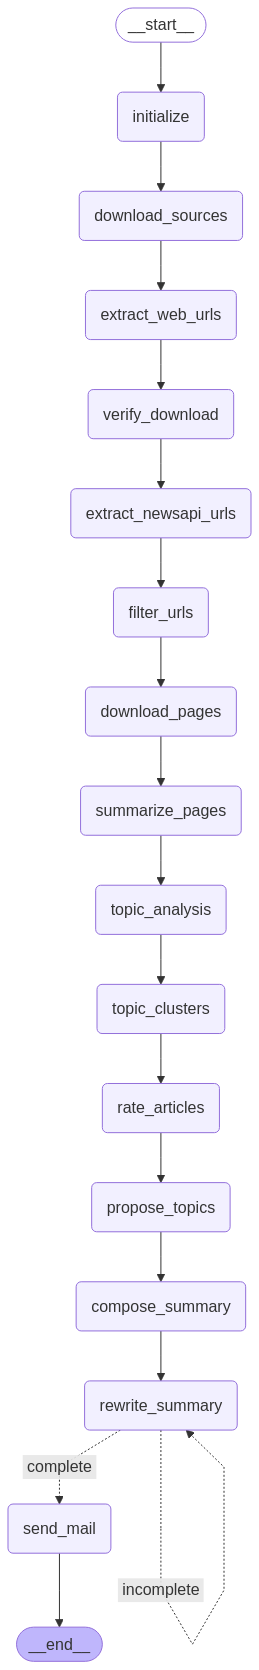

In [6]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-05-15 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [7]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-15 13:52:34,033 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-15 13:52:34,034 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-15 13:52:34,035 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-15 13:52:34,036 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-15 13:52:34,036 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [8]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-15 13:52:35,395 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-15 13:52:35,397 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-15 13:52:35,398 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-15 13:52:35,400 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-15 13:52:35,401 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-15 13:52:35,402 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-15 13:52:35,402 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-15 13:52:35,403 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-15 13:52:35,403 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-15 13:52:35,404 - AInewsbot - INFO - htmldata/FT.html
2025-05-15 13:52:35,404 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-15 13:52:35,405 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-15 13:52:35,405 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-15 13:52:35,406 - AInewsbot - INFO -

In [9]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-15 13:52:35,972 - AInewsbot - INFO - Parsing html files
2025-05-15 13:52:35,974 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-15 13:52:36,021 - AInewsbot - INFO - parse_file - found 169 raw links
2025-05-15 13:52:36,024 - AInewsbot - INFO - parse_file - found 33 filtered links
2025-05-15 13:52:36,025 - AInewsbot - INFO - 33 links found
2025-05-15 13:52:36,025 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-15 13:52:36,048 - AInewsbot - INFO - parse_file - found 246 raw links
2025-05-15 13:52:36,051 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-15 13:52:36,051 - AInewsbot - INFO - 34 links found
2025-05-15 13:52:36,052 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-15 13:52:36,069 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-15 13:52:36,072 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-15 13:52:36,072 - AInewsbot - INFO - 21 links found
2025-05-15

In [10]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,30
Bloomberg,27
Business Insider,21
FT,62
Feedly AI,37
Hacker News 1,25
Hacker News 2,20
HackerNoon,31
New York Times,18


number of missing sources 0


set()

In [11]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-15 13:52:43,119 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [12]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-15 13:52:44,281 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-14T13:52:44 from NewsAPI


In [13]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-15 13:52:46,101 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-05-15 08:00'
2025-05-15 13:52:46,853 - AInewsbot - INFO - URLs in orig_df: 917
2025-05-15 13:52:46,857 - AInewsbot - INFO - Existing URLs in DB: 259345
2025-05-15 13:52:46,919 - AInewsbot - INFO - New URLs in df filtered by URL: 243
2025-05-15 13:52:47,057 - AInewsbot - INFO - Existing src+title: 37
2025-05-15 13:52:47,058 - AInewsbot - INFO - New URLs in df filtered by src+title: 206
2025-05-15 13:52:47,074 - AInewsbot - INFO - Found 206 unique new headlines
2025-05-15 13:52:47,077 - AInewsbot - INFO - Found 203 unique cleaned new headlines
2025-05-15 13:52:49,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 13:52:54,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 13:52:55,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,4
Business Insider,2
FT,1
Feedly AI,20
Hacker News 1,4
New York Times,1
NewsAPI,49
Reddit,3
Techmeme,4


In [14]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-05-15 13:52:58,219 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-15 13:52:58,221 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-15 13:52:58,553 - AInewsbot - INFO - Launching browser
2025-05-15 13:53:00,177 - AInewsbot - INFO - Launching workers
2025-05-15 13:53:00,177 - AInewsbot - INFO - Launching worker
2025-05-15 13:53:00,177 - AInewsbot - INFO - from queue: 0, https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai , (PR) AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI
2025-05-15 13:53:00,178 - AInewsbot - INFO - fetch_url(https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)
2025-05-15 13:53:00,204 - AInewsbot - INFO - Launching worker
2025-05-15 13:53:00,204 - AInewsbot - INFO - from queue: 1, https://www.techpowerup.com/336772/qualcomm-humain-to-develo

In [15]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-15 13:59:45,472 - AInewsbot - INFO - Starting summarize
2025-05-15 13:59:45,475 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-15 13:59:45,479 - AInewsbot - INFO - Attempting to fetch summaries for 91 articles
2025-05-15 13:59:45,490 - AInewsbot - INFO - clean_html - Page title: AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI | TechPowerUp
Social card title: AMD & HUMAIN Reveal Formation of $10 Billion Strategic Collab, Aimed at Advancing Global AI
Social card description: AMD and HUMAIN, Saudi Arabia's new AI enterprise, today announced a landmark agreement to build the world's most open, scalable, resilient, and cost-efficient AI infrastructure, that will power the future of global intelligence through a network of AMD-based AI computing centers stretching from the ...

2025-05-15 13:59:45,649 - AInewsbot - INFO - Queuing 0: Page title: AMD & HUMAIN Reveal Formation of $10 B...
2025-05-15 13:59:45,656 - AInewsbot -

In [16]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-15 13:59:56,093 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:00:03,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:04,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:04,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:06,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:07,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:07,721 - AInewsbot - INFO - 91 free-form topics extracted
2025-05-15 14:00:07,722 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:00:07,723 - AInewsbot - IN

---

# Role and Objective
You are an **expert topic classifier**.
Given a Markdown-formatted article summary and a list of candidate topics, select **3-7** topics that best capture the article’s main themes.
If the article is non-substantive (e.g. empty or “no content”), return **zero** topics.

# Instructions
- Each topic **must be unique**
- Select only topics that **best cover the content**; ignore marginal or redundant ones.
- Favour **specific** over generic terms (e.g. “AI Adoption Challenges” > “AI”).
- Avoid near-duplicates (e.g. do not pick both “AI Ethics” *and* “AI Ethics And Trust” unless genuinely distinct).
- Aim for **breadth with minimal overlap**; each chosen topic should add new information about the article.
- Copy-edit chosen titles for spelling, capitalization, and clarity

# Reasoning Steps (internal)
Think step-by-step to find the smallest non-overlapping set of topics that spans the article.
**Do NOT output these thoughts.**

# Output Format
Respond with the JSO

2025-05-15 14:00:21,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,520 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,582 - httpx 

async_langchain: 3 response: items=[]
async_langchain: 40 response: items=['AI in Law', 'Legal Repercussions', 'Due Diligence', 'Generative AI', 'Disinformation']
async_langchain: 0 response: items=['AI Infrastructure', 'Global AI Compute', 'Strategic Collaboration', 'AMD', 'HUMAIN', 'Saudi Arabia', 'Funding']
async_langchain: 8 response: items=['AI Driver Monitoring', 'Fatal Bus Crash', 'Public Transport Safety', 'Policy And Regulation', 'Transportation', 'Sri Lanka']
async_langchain: 48 response: items=['Advertising', 'Generative AI', 'Interactive Ads', 'Netflix', 'Streaming', 'Subscriber Engagement']
async_langchain: 43 response: items=['AI Strategy', 'Business Pivot', 'Layoffs', 'Microsoft', 'Workforce Adjustment']
async_langchain: 24 response: items=['AI Startup Valuation', 'Funding', 'Elon Musk', 'Venture Capital', 'GPUs', 'Deals']
async_langchain: 15 response: items=['Canada Social Commerce', 'Influencer Marketing', 'Consumer Engagement', 'AI Integration', 'Legal Issues', 'Virtu

2025-05-15 14:00:21,906 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,952 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:21,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,005 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,105 - httpx 

async_langchain: 6 response: items=['AI Collective Decision-Making', 'Bias Amplification', 'AI Ethics', 'Influence', 'AI Regulation', 'Unanticipated Behaviors']
async_langchain: 44 response: items=['Microsoft Layoffs', 'Organizational Change', 'Employee Impact', 'AI Investment', 'Jobs & Careers']
async_langchain: 7 response: items=['AI Agents', 'AWS', 'DevOps Automation', 'GitHub Integration', 'Generative AI', 'Software Engineering']
async_langchain: 68 response: items=['AI Hardware', 'Performance Comparison', 'Cost-Efficiency', 'Nvidia', 'TPUs vs GPUs', 'Cloud Computing']
async_langchain: 37 response: items=['AI Integration', 'Google', 'Itinerary Personalization', 'Lifestyle & Travel', 'Summer Travel', 'Travel Planning']
async_langchain: 45 response: items=['AI Agents', 'Bing Search API Retirement', 'Chatbot Integration', 'Azure AI', 'Service Transition', 'Market Demand']
async_langchain: 20 response: items=[]
async_langchain: 30 response: items=['Generative AI', 'Logistics Market', '

2025-05-15 14:00:22,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,217 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,318 - httpx 

async_langchain: 63 response: items=['Gaussian Splatting', 'LiveSplat', 'Real-Time Processing', 'Software Licensing', 'Virtual & Augmented Reality']
async_langchain: 73 response: items=['Breakthrough Research', 'Computational Efficiency', 'Edge Coloring', 'Graph Coloring Algorithms', 'Theory Of Computing']
async_langchain: 31 response: items=[]
async_langchain: 25 response: items=['AI Demonstrations', 'Humanoid Robots', 'Public Perception', 'Robotic Capabilities', 'Tesla Optimus']
async_langchain: 46 response: items=['AI Roles', 'Impact On Employees', 'Microsoft Layoffs', 'Organizational Restructuring', 'Job Market Concerns']
async_langchain: 84 response: items=[]
async_langchain: 59 response: items=['AI Integration', 'Finance', 'Generative AI', 'Products']
async_langchain: 5 response: items=['AI Regulation', 'Artificial Superintelligence', 'Existential Risks', 'Global Governance', 'Technical Civilizations']
async_langchain: 12 response: items=['AI-Generated Content', 'ChatGPT', 'Image

2025-05-15 14:00:22,359 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,365 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: items=['AI Integration', 'Blockchain Integration', 'Cardano', 'Cryptocurrency', 'Supply Chain Management', 'Ruvi AI']
async_langchain: 54 response: items=['Virtual & Augmented Reality', 'User Experience', 'Education', 'Health & Fitness', 'AI Agents']
async_langchain: 88 response: items=['ChatGPT', 'Coffee Grounds Prediction', 'Divorce Case', 'Legal Issues', 'Society & Culture']
async_langchain: 85 response: items=['Walmart Automation', 'Fulfillment Centers', 'Job Automation', 'Supply Chain Optimization', 'Agentic AI']
async_langchain: 89 response: items=['Xiaomi', 'XringO1 Chip', 'Mobile Chip Development', 'Arm Architecture', 'Semiconductor Chips', 'Manufacturing']
async_langchain: 42 response: items=['AI Training', 'Data Privacy', 'Legal Challenges', 'Meta', 'European Regulations', 'Policy And Regulation']


2025-05-15 14:00:22,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,646 - httpx 

async_langchain: 49 response: items=['AI Technology', 'Performance Improvements', 'Video Enhancement', 'Toolkit Features', 'Winxvideo AI', 'Deals']
async_langchain: 52 response: items=['Deals', 'Funding', 'Generative AI']
async_langchain: 23 response: items=['AI Integration', 'Compliance Strategies', 'Cybersecurity', 'Data Management', 'Financial Services', 'Egnyte Summit', 'Governance']
async_langchain: 36 response: items=['AI Regulation', 'Cybersecurity', 'Policy And Regulation', 'Legal Issues', 'Governance']
async_langchain: 61 response: items=['Big Tech', 'Legislation', 'Military Contracts', 'Pentagon', 'Government Oversight']
async_langchain: 27 response: items=['AI Factories', 'Generative AI', 'Token Generation', 'NVIDIA', 'Lockheed Martin', 'Infrastructure', 'Data Processing']
async_langchain: 51 response: items=['CEO Compensation', 'Executive Pay', 'Nvidia', 'AI Industry Growth', 'Fiscal Performance']
async_langchain: 1 response: items=['AI Data Centers', 'Cloud-To-Edge Service

2025-05-15 14:00:22,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,821 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,837 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:22,871 - httpx 

async_langchain: 16 response: items=['Academic Integrity', 'AI Detection Software', 'Education', 'Educational Assessments', 'Plagiarism Concerns', 'ChatGPT', 'Generative AI']
async_langchain: 39 response: items=['AI Integration', 'Fintech', 'Latin America', 'Policy And Regulation', 'Regulatory Changes', 'Social Commerce', 'TikTok']
async_langchain: 80 response: items=['AI Diplomacy', 'AI Chips', 'AI Regulation', 'Job Automation', 'Universal Basic Income', 'Politics', 'Nvidia']
async_langchain: 38 response: items=['Explainable AI', 'Human Oversight', 'Audit Trails', 'Bias in AI', 'Transparency in AI']
async_langchain: 34 response: items=['AI Integration', 'Collaboration Tools', 'Grammarly', 'Productivity Solutions', 'Public Sector', 'Aws Marketplace']
async_langchain: 19 response: items=['Connected Car Solutions', 'Driver Safety', 'Autonomous Vehicles', 'Infotainment Systems', 'Cybersecurity', 'Policy And Regulation', 'Supply Chain Optimization']
async_langchain: 69 response: items=['Cr

2025-05-15 14:00:23,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: items=['AI Ethics', 'Human Dignity', 'Job Automation', 'Labor Market', 'Pope Leo XIV', 'Vatican Focus', 'Responsible AI']
async_langchain: 18 response: items=['Cognichip', 'AI Chips', 'Chip Design', 'Seed Funding', 'Semiconductor Innovation', 'Funding Round', 'Job Automation']
async_langchain: 33 response: items=['Accessibility', 'AI Features', 'Android', 'Chrome', 'Google']
async_langchain: 55 response: items=['Funding', 'Funding Round', 'Oncology Drug Development', 'Pathos AI', 'Startup Valuation', 'Venture Capital']
async_langchain: 58 response: items=['AI Risks', 'Civilization Longevity', 'Drake Equation', 'SETI', 'Existential Risks', 'Extraterrestrial Signals']
async_langchain: 22 response: items=['AI Autonomy', 'AI Ethics', 'Moral Responsibility', 'Philosophical Implications', 'Generative AI']


2025-05-15 14:00:23,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:23,691 - AInewsbot - INFO - Received 91 responses
2025-05-15 14:00:23,697 - AInewsbot - INFO - End topic analysis


async_langchain: 83 response: items=['AI Regulation', 'Copyright Transparency', 'Legal Issues', 'Policy And Regulation', 'UK Data Bill']
async_langchain: 76 response: items=['AI Development', 'Law Firm Acquisitions', 'Legal Technology', 'Mergers And Acquisitions', 'Proprietary Tools', 'Springbok AI']


In [17]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-15 14:00:23,706 - AInewsbot - INFO - Fetching embeddings for 91 headlines
2025-05-15 14:00:24,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-15 14:00:25,023 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-15 14:00:25,040 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-15 14:00:26,691 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-15 14:00:28,065 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-15 14:00:28,162 - AInewsbot - INFO - Found 4 clusters


,title_topic_str
0,"Can We Regulate AI? Global Challenges and Existential Stakes for Humanity (Topics: AI Regulation, Existential Risks, Global Challenges, Policy and Regulation, Governance)"
1,"AI, the Great Filter, and the Fate of Civilizations: Why Global Regulation Matters (Topics: AI Regulation, Artificial Superintelligence, Existential Risks, Global Governance, Technical Civilizations)"
2,"Top Priority for Pope Leo: Warn the World of the A.I. Threat (Topics: AI Ethics, Human Dignity, Job Automation, Labor Market, Pope Leo XIV, Vatican Focus, Responsible AI)"
3,"SETI, Civilizational Longevity, and the Drake Equation: Why AI Risks Matter (Topics: AI Risks, Civilization Longevity, Drake Equation, SETI, Existential Risks, Extraterrestrial Signals)"


2025-05-15 14:00:29,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:29,122 - AInewsbot - INFO - I dub this cluster: Global Risks and Regulation of AI


,title_topic_str
4,"Akido Labs, which makes AI assistants for doctors to improve patient treatment efficiency, raised a $60M Series B led by Oak HC/FT (Madeline Renbarger/Newcomer) (Topics: AI Assistants, Healthtech AI, Patient Treatment Efficiency, Series B Funding, Venture Capital)"
5,"Pathos AI, which uses AI to develop oncology drugs, raised a $365M Series D at a $1.6B valuation, bringing its total funding to $467M, per PitchBook (Topics: Funding, Funding Round, Oncology Drug Development, Pathos AI, Startup Valuation, Venture Capital)"
6,"Read the pitch deck an AI video startup behind viral baby podcast memes used to raise $32 million from A16z and others (Topics: AI Video Generation, Character Models, Content Creation, Funding Round, Generative AI, Venture Capital)"


2025-05-15 14:00:30,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:30,352 - AInewsbot - INFO - I dub this cluster: AI Startups Raise Major Funding


,title_topic_str
7,"Microsoft's brutal layoffs: Can you believe it? Even the AI director was fired; here are the others who could be impacted (Topics: AI Roles, Impact On Employees, Microsoft Layoffs, Organizational Restructuring, Job Market Concerns)"
8,"Microsoft Lays Off About 3% Of Workers As Company Adjusts For AI Business (Topics: AI Strategy, Business Pivot, Layoffs, Microsoft, Workforce Adjustment)"
9,"Microsoft lays off 3% of workforce in what one executive calls a 'day with a lot of tears' (Topics: Microsoft Layoffs, Organizational Change, Employee Impact, AI Investment, Jobs & Careers)"


2025-05-15 14:00:31,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:31,478 - AInewsbot - INFO - I dub this cluster: Microsoft's AI Related Workforce Layoffs


,title_topic_str
10,"Sources: in the past two months, Chinese officials told some top local tech companies that China will more actively oversee their AI data centers and AI chips (Topics: AI Chips, AI Oversight, AI Regulation, China, Data Centers, Government Regulations)"
11,"Trump administration rescinds curbs on AI chip exports to foreign markets (Topics: AI Chips, Export Controls, U.S.-China Relations, Trade Policy, Policy and Regulation, European Union)"
12,"Trump admin scraps Biden-era AI chip export curbs, vows new global strategy to counter China (Topics: AI Chip Exports, AI Regulation, China, Nvidia, Policy And Regulation, U.S. Government Policy, Innovation Strategy)"


2025-05-15 14:00:32,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:32,641 - AInewsbot - INFO - I dub this cluster: AI Chip Regulations and Trade Policies
2025-05-15 14:00:32,652 - AInewsbot - INFO - ['Global Risks and Regulation of AI', 'AI Startups Raise Major Funding', "Microsoft's AI Related Workforce Layoffs", 'AI Chip Regulations and Trade Policies']


In [18]:
# does a naive rating, asking , is this relevant, is it important, is it spam/low-quality
# then does an ELO ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# when I read at a story, it's kind of, how much does it update my priors, how much impact will it have
# sometimes it's just, how much does it tickle me
# just hard to get a good answer from the AI 
# with a big panel of people voting like on reddit or with likes, could do a crowdsourced ranking but 
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-15 14:00:32,679 - AInewsbot - INFO - Calculating article rating for 91 articles
2025-05-15 14:00:32,680 - AInewsbot - INFO - Starting low_quality filter
2025-05-15 14:00:38,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:38,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:38,201 - AInewsbot - INFO - low quality articles: {0: 69, 1: 22}
2025-05-15 14:00:38,202 - AInewsbot - INFO - Starting on_topic filter
2025-05-15 14:00:42,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:43,194 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:00:43,235 - AInewsbot - INFO - on topic articles: {1: 74, 0: 17}
2025-05-15 14:00:43,236 - AInewsbot - INFO - Starting importance filter
2025-05-15 14:00:47,836 - httpx - INFO - HTTP Reques

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
0,0,https://hackernoon.com/can-we-regulate-ai-glob...,Feedly AI,Can We Regulate AI? Global Challenges and Exis...,True,https://hackernoon.com/can-we-regulate-ai-glob...,hackernoon.com,Hacker Noon,2,htmlpages/Can_We_Regulate_AI__Global_Challenge...,...,12,0,Global Risks and Regulation of AI,0,1,0,1114.717560,1.183038,1.616055,5.207574
1,1,https://hackernoon.com/ai-the-great-filter-and...,Feedly AI,"AI, the Great Filter, and the Fate of Civiliza...",True,https://hackernoon.com/ai-the-great-filter-and...,hackernoon.com,Hacker Noon,2,htmlpages/AI__the_Great_Filter__and_the_Fate_o...,...,24,0,Global Risks and Regulation of AI,0,1,0,878.381227,-1.254208,2.000000,4.372896
2,2,https://www.nytimes.com/2025/05/15/world/europ...,New York Times,Top Priority for Pope Leo: Warn the World of t...,True,https://www.nytimes.com/2025/05/15/world/europ...,www.nytimes.com,The New York Times,4,htmlpages/Top_Priority_for_Pope_Leo__Warn_the_...,...,26,0,Global Risks and Regulation of AI,0,1,1,978.272913,-0.224063,1.466423,7.354391
3,3,https://hackernoon.com/seti-civilizational-lon...,Feedly AI,"SETI, Civilizational Longevity, and the Drake ...",True,https://hackernoon.com/seti-civilizational-lon...,hackernoon.com,Hacker Noon,2,htmlpages/SETI__Civilizational_Longevity__and_...,...,57,0,Global Risks and Regulation of AI,0,1,0,899.886857,-1.032429,1.691347,4.175132
4,5,https://www.axios.com/pro/biotech-deals/2025/0...,Techmeme,"Pathos AI, which uses AI to develop oncology d...",True,https://www.axios.com/pro/biotech-deals/2025/0...,www.axios.com,Axios,1,htmlpages/Pathos_AI__which_uses_AI_to_develop_...,...,43,1,AI Startups Raise Major Funding,1,1,1,1080.611063,0.831311,0.713491,3.129146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,85,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Trumps Rush to Cut AI Deals in Saudi Arabia an...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,84,999,,1,1,0,1104.076175,1.073298,0.000000,4.536649
69,86,https://www.reuters.com/business/media-telecom...,Techmeme,"Xiaomi CEO Lei Jun unveils the XringO1, the co...",True,https://www.reuters.com/business/media-telecom...,www.reuters.com,Reuters,2,htmlpages/Xiaomi_CEO_Lei_Jun_unveils_the_Xring...,...,86,999,,0,1,1,950.648380,-0.508944,1.547652,5.293179
70,87,https://techcrunch.com/2025/05/15/cognichip-em...,Feedly AI,"Cognichip, which is building a physics-informe...",True,https://techcrunch.com/2025/05/15/cognichip-em...,techcrunch.com,TechCrunch,2,htmlpages/Cognichip__which_is_building_a_physi...,...,87,999,,0,1,1,1047.141512,0.486152,1.705778,5.948854
71,89,https://github.com/axbycc/LiveSplat,Hacker News 1,Show HN: Real-Time Gaussian Splatting,True,https://github.com/axbycc/LiveSplat,github.com,GitHub,0,htmlpages/Show_HN__Real-Time_Gaussian_Splattin...,...,89,999,,0,1,0,950.462452,-0.510862,1.315340,2.059910


In [19]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-15 14:07:52,703 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:07:52,705 - AInewsbot - INFO - Initial cluster topics: 
Global Risks and Regulation of AI
AI Startups Raise Major Funding
Microsoft's AI Related Workforce Layoffs
AI Chip Regulations and Trade Policies
2025-05-15 14:08:46,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:08:46,590 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Global Risks and Regulation of AI
AI Startups Raise Major Funding
Microsoft's AI Related Workforce Layoffs
AI Chip Regulations and Trade Policies
Federal AI Regulation Freeze
Personal AI Privacy Risks
Cognichip $33M Seed
GPT-4.1 ChatGPT Rollout
China Tightens AI Oversight
Google AI Accessibility Features
Arm Rebrands AI SoCs
US AI Chip Export Reversal
LTMs Secure Payment Flows
Xiaomi Unveils XringO1 

In [20]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices

lg_state = lg_agent.compose_summary(lg_state)


2025-05-15 14:09:10,106 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:09:10,115 - AInewsbot - INFO - Starting cluster_name filter
2025-05-15 14:09:10,118 - AInewsbot - INFO - Queuing 16: (PR) Qualcomm & HUMAIN to Develop State-of-the-Art...
2025-05-15 14:09:10,118 - AInewsbot - INFO - Queuing 17: Has Grok lost its mind and mind-melded with its ow...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 18: Does AI Have Free Will? New Study Says Were Gettin...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 20: Motorola Razr Ultra review: one of the best smartp...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 21: The Fastest Way yet to Color Graphs (Topics: Break...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 22: Scientists use AI to encrypt secret messages that ...
2025-05-15 14:09:10,119 - AInewsbot - INFO - Queuing 23: Microsoft to Retire Bing Search APIs, Promote Azur...
2025-05-15 14:09:10,119 -

---

# Role and Objective
You are an **AI Topic Router**.
Your job is to read one news item and pick the single most relevant topic from a supplied list of candidate topics.
If none of the candidates is a good fit, return the string **None**.

# CANDIDATE TOPICS:
Global AI Regulation
AI Startup Funding
Microsoft AI Layoffs
AI Chip Regulations
US AI Chip Export Reversal
US AI Regulation Freeze
AI Privacy Risks
Cognichip $33M Seed
OpenAI GPT-4.1 Release
China AI Oversight
Google Accessibility Features
Arm SoC Rebrand
LTMs Secure Payments
Xiaomi XringO1 Chip
You.com ARI Appointment
Law Firm AI Fines
Geoeconomic Monitor Launch
Microsoft Retires Bing APIs
Meta EU Data Dispute
Netflix GenAI Ads
Hedra $32M Series A
Saudi Data Center Deals
Amazon Q Integration
Hidden Message Encryption
AI Phishing Surge
Google Patent Leadership
Walmart Automation Savings
SoundCloud AI Policy
AWS GitHub Integration
Pathos AI $365M Series D

# INSTRUCTIONS

- Read the input carefully.
- Compare the semantic cont

2025-05-15 14:09:12,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: id=0 topic='None'
async_langchain: 52 response: id=0 topic='OpenAI GPT-4.1 Release'
async_langchain: 84 response: id=0 topic='Google Patent Leadership'


2025-05-15 14:09:12,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:12,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 57 response: id=0 topic='Amazon Q Integration'
async_langchain: 43 response: id=0 topic='Netflix GenAI Ads'
async_langchain: 87 response: id=0 topic='Cognichip $33M Seed'


2025-05-15 14:09:13,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: id=0 topic='Hidden Message Encryption'


2025-05-15 14:09:13,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: id=0 topic='None'
async_langchain: 16 response: id=0 topic='Saudi Data Center Deals'
async_langchain: 49 response: id=0 topic='AI Phishing Surge'
async_langchain: 67 response: id=0 topic='Google Accessibility Features'


2025-05-15 14:09:13,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:13,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 64 response: id=0 topic='Walmart Automation Savings'
async_langchain: 80 response: id=0 topic='None'


2025-05-15 14:09:13,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 62 response: id=0 topic='None'
async_langchain: 90 response: id=0 topic='None'
async_langchain: 61 response: id=0 topic='None'
async_langchain: 40 response: id=0 topic='Law Firm AI Fines'
async_langchain: 23 response: id=0 topic='Microsoft Retires Bing APIs'


2025-05-15 14:09:14,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: id=0 topic='None'
async_langchain: 68 response: id=0 topic='US AI Regulation Freeze'
async_langchain: 76 response: id=0 topic='SoundCloud AI Policy'
async_langchain: 20 response: id=0 topic='None'


2025-05-15 14:09:14,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 56 response: id=0 topic='LTMs Secure Payments'
async_langchain: 69 response: id=0 topic='Arm SoC Rebrand'
async_langchain: 81 response: id=0 topic='None'
async_langchain: 36 response: id=0 topic='Saudi Data Center Deals'


2025-05-15 14:09:14,663 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,877 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: id=0 topic='None'
async_langchain: 42 response: id=0 topic='None'
async_langchain: 44 response: id=0 topic='None'


2025-05-15 14:09:14,931 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:14,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: id=0 topic='None'
async_langchain: 34 response: id=0 topic='US AI Regulation Freeze'
async_langchain: 29 response: id=0 topic='None'
async_langchain: 65 response: id=0 topic='Global AI Regulation'


2025-05-15 14:09:15,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:15,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 32 response: id=0 topic='Geoeconomic Monitor Launch'
async_langchain: 72 response: id=0 topic='None'
async_langchain: 58 response: id=0 topic='None'
async_langchain: 17 response: id=0 topic='None'
async_langchain: 51 response: id=0 topic='None'


2025-05-15 14:09:15,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 70 response: id=0 topic='None'


2025-05-15 14:09:15,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 85 response: id=0 topic='None'


2025-05-15 14:09:15,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: id=0 topic='Meta EU Data Dispute'
async_langchain: 45 response: id=0 topic='None'


2025-05-15 14:09:16,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 77 response: id=0 topic='None'
async_langchain: 53 response: id=0 topic='None'
async_langchain: 79 response: id=0 topic='AI Startup Funding'
async_langchain: 82 response: id=0 topic='None'


2025-05-15 14:09:16,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 78 response: id=0 topic='None'
async_langchain: 25 response: id=0 topic='None'


2025-05-15 14:09:16,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:16,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 31 response: id=0 topic='AWS GitHub Integration'
async_langchain: 18 response: id=0 topic='None'


2025-05-15 14:09:16,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,123 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: id=0 topic='Xiaomi XringO1 Chip'
async_langchain: 71 response: id=0 topic='You.com ARI Appointment'


2025-05-15 14:09:17,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:17,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: id=0 topic='Saudi Data Center Deals'
async_langchain: 55 response: id=0 topic='Global AI Regulation'
async_langchain: 59 response: id=0 topic='None'
async_langchain: 75 response: id=0 topic='AI Privacy Risks'


2025-05-15 14:09:17,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 54 response: id=0 topic='None'
async_langchain: 50 response: id=0 topic='Google Accessibility Features'


2025-05-15 14:09:18,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:18,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 48 response: id=0 topic='None'
async_langchain: 28 response: id=0 topic='US AI Chip Export Reversal'
async_langchain: 41 response: id=0 topic='None'


2025-05-15 14:09:21,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:21,635 - AInewsbot - INFO - Received 62 responses
2025-05-15 14:09:21,644 - AInewsbot - INFO - [{'cluster_name': 'None', 'count': 32}, {'cluster_name': 'Global Risks and Regulation of AI', 'count': 4}, {'cluster_name': 'AI Chip Regulations and Trade Policies', 'count': 3}, {'cluster_name': 'Saudi Data Center Deals', 'count': 3}, {'cluster_name': 'US AI Regulation Freeze', 'count': 2}, {'cluster_name': 'Google Accessibility Features', 'count': 2}, {'cluster_name': 'AI Startups Raise Major Funding', 'count': 2}, {'cluster_name': 'Global AI Regulation', 'count': 2}, {'cluster_name': "Microsoft's AI Related Workforce Layoffs", 'count': 2}, {'cluster_name': 'AI Startup Funding', 'count': 1}, {'cluster_name': 'LTMs Secure Payments', 'count': 1}, {'cluster_name': 'AI Privacy Risks', 'count': 1}, {'cluster_name': 'Google Patent Leadership', 'count': 1}, {'cl

async_langchain: 26 response: id=0 topic='None'


2025-05-15 14:09:39,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:40,021 - AInewsbot - INFO - Deduping cluster: Global Risks and Regulation of AI
2025-05-15 14:09:40,022 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:09:52,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:52,299 - AInewsbot - INFO - Deduping cluster: AI Chip Regulations and Trade Policies
2025-05-15 14:09:52,300 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:09:58,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:09:58,965 - AInewsbot - INFO - Deduping cluster: Saudi Data Center Deals
2025-05-15 14:09:58,967 - AInewsbot - INFO - Starting dupe_id filter
2025-05-15 14:10:16,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-15 14:10:16,290

In [22]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

## AI Policy & Regulation

- The Trump administration rescinded a Biden-era rule limiting AI chip exports to 100+ countries, planning a replacement rule to allow trusted partners while restricting adversaries. - [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951)
- Chinese officials will more actively oversee AI data centers and specialized chips, aiming to strengthen government control over critical AI infrastructure. - [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- Pope Leo XIV prioritized addressing AI risks to human dignity, justice, and labor in his inaugural address, emphasizing responsibility alongside AI’s potential. - [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)
- An article argues that global AI regulation is essential to mitigate existential risks but is challenged by varied national priorities and rapid technological advances. - [Hacker Noon](https://hackernoon.com/can-we-regulate-ai-global-challenges-and-existential-stakes-for-humanity)
- House Republicans included a ten-year ban on state and local AI regulation in the Budget Reconciliation bill, preempting existing and future state-level AI laws. - [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)

## Mega AI Deals

- OpenAI expanded its CoreWeave partnership with a new \\$4 billion cloud deal to secure additional GPU capacity for its AI services. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN agreed to develop state-of-the-art AI data centers in Saudi Arabia, integrating Qualcomm’s processors with HUMAIN’s Arabic language models. - [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- Nvidia and AMD shares rose after securing multibillion-dollar AI chip supply deals with Humain, driven by a \\$10 billion Middle East data center initiative. - [The Economic Times](https://economictimes.indiatimes.com/news/international/us/nvidia-and-amd-shares-jump-leaving-deepseek-impact-behind-heres-what-happened-and-what-investors-should-know/articleshow/121168726.cms)
- AMD and HUMAIN formed a \\$10 billion strategic partnership to deploy AMD-based AI computing centers across Saudi Arabia and the US over the next five years. - [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## AI Infrastructure & Cloud

- NVIDIA’s Blackwell GPUs and Dynamo platform optimize AI factories, boosting energy efficiency and throughput for large-scale data processing and inference. - [NVIDIA Blogs](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia’s H100 and H200 GPUs outperform Google’s TPU V6E in capacity, throughput, scalability, and cost per token across large-scale AI workloads. - [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13 percent revenue increase, attributing gains to AI investments in gaming and advertising, while noting potential impacts from US chip controls. - [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight

- AI startup Hedra raised \\$32 million in a Series A led by Andreessen Horowitz to develop controllable character models for video, audio, and image content. - [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- HackerNoon highlighted NachoNacho, Moveo.AI, and Zenerate as regional Startup of the Week winners in SaaS, conversational AI, and real estate technology. - [Hacker Noon](https://hackernoon.com/meet-nachonacho-moveoai-and-zenerate-hackernoon-startups-of-the-week)
- llm-min.txt compresses technical documentation by 90–97 percent using Gemini models, enabling efficient context ingestion for LLM coding assistants. - [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## AI Ethics & Society

- A student demanded a tuition refund after discovering her professor used ChatGPT to generate lecture notes despite banning AI, prompting debate on AI use transparency in education. - [Futurism](https://futurism.com/student-professor-chatgpt-tuition)
- Meta is paying \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars, highlighting the growing human role in AI model development. - [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Product Features

- Google added AI-powered TalkBack in Android and Chrome, enabling image and content queries, plus improved captions and OCR for better accessibility on Android 15+ and desktop Chrome. - [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Other News

- UK ministers plan to remove an amendment requiring AI firms to disclose copyrighted content use in a data bill via a parliamentary procedure. - [biztoc.com](https://biztoc.com/x/5ab6afab6b3a4b53)
- A study found AI agents can collaboratively decide and influence each other, forming group biases and raising complexities for AI regulation. - [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)
- Experts recommend explainable AI methods, human oversight, and audit trails to enhance transparency and accountability in black-box AI systems. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/14/improving-transparency-in-black-box-ai-expert-strategies-that-work/)
- The Trump administration sought AI deals with Saudi Arabia and UAE, prompting tension with China hawks over shifting geopolitical alliances in AI. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- A report forecasts the Connected Car Solutions market to grow to \\$148.6 billion by 2030, driven by AI, connectivity, and regulatory mandates for vehicle cybersecurity. - [Globe Newswire](https://www.globenewswire.com/news-release/2025/05/14/3081346/28124/en/Connected-Car-Solutions-Strategic-Business-Intelligence-Report-2024-2030-Increasing-Focus-on-Driver-Safety-and-Assistance-Growing-Consumer-Demand-for-Infotainment-Systems.html)

2025-05-15 14:16:44,719 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:17:34,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Power Plays: Regulation, Deals, and Ethics

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials to oversee AI data centers and specialized chips [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for additional GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN to build AI data centers in Saudi Arabia integrating Qualcomm’s processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B strategic partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Infra Insights
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for large-scale AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google’s TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Stars
- AI startup Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by 90–97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Ethics Check
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Focus
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, improved captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Research Recap
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)



2025-05-15 14:17:34,658 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-15 14:18:19,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Arms Race: Chips, Deals, and Morals

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials will oversee AI data centers and specialized chip operations [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for more GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN will build AI data centers in Saudi Arabia using Qualcomm processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Power Play
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight
- Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by up to 97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Moral Metrics
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Frenzy
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, better captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Bias Briefing
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)

2025-05-15 14:18:19,085 - AInewsbot - INFO - Sending summary email
2025-05-15 14:18:19,120 - AInewsbot - INFO - Email subject AI Arms Race: Chips, Deals, and Morals
2025-05-15 14:18:19,121 - AInewsbot - INFO - Email length 3887


# AI Arms Race: Chips, Deals, and Morals

## Regulation Rumble
- Trump administration rescinded Biden-era AI chip export curbs and pursued AI deals with Saudi Arabia and UAE [ABC News](https://abcnews.go.com/Technology/wireStory/trump-administration-rescinds-curbs-ai-chip-exports-foreign-121789951), [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/trump-s-rush-to-cut-ai-deals-in-saudi-arabia-and-uae-opens-rift-with-china-hawks)
- Chinese officials will oversee AI data centers and specialized chip operations [The Information](https://www.theinformation.com/articles/china-tightens-control-ai-data-centers)
- House Republicans barred state and local AI regulation for ten years [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/the-gop-wants-to-deregulate-ai-provision-in-budget-reconciliation-bill-blocks-state-governments-from-meddling-for-10-years)
- Pope Leo XIV urged responsible AI use to protect human dignity and labor [The New York Times](https://www.nytimes.com/2025/05/15/world/europe/pope-leo-artificial-intelligence.html)

## Deal Dynamo
- OpenAI expanded its CoreWeave partnership with a \\$4B cloud deal for more GPU capacity [Bloomberg](https://www.bloomberg.com/news/articles/2025-05-15/openai-expands-coreweave-tie-up-with-new-4-billion-cloud-deal)
- Qualcomm and HUMAIN will build AI data centers in Saudi Arabia using Qualcomm processors and Arabic models [TechPowerUp](https://www.techpowerup.com/336772/qualcomm-humain-to-develop-state-of-the-art-ai-data-centers)
- AMD and HUMAIN launched a \\$10B partnership to deploy AI computing centers across Saudi Arabia and the US [TechPowerUp](https://www.techpowerup.com/336769/amd-humain-reveal-formation-of-usd-10-billion-strategic-collab-aimed-at-advancing-global-ai)

## Power Play
- NVIDIA’s Blackwell GPUs and Dynamo platform boost energy efficiency and throughput for AI processing [NVIDIA Blog](https://blogs.nvidia.com/blog/revenue-potential-ai-factories/)
- Nvidia H100 and H200 GPUs outperform Google TPU V6E in capacity and cost per token [Geeky Gadgets](https://www.geeky-gadgets.com/tpu-vs-gpu-ai-hardware-compared-2025/)
- Tencent reported a 13% revenue increase from AI investments in gaming and advertising despite US chip controls [PYMNTS](https://www.pymnts.com/earnings/2025/tencent-says-ai-spending-is-yielding-results/)

## Startup Spotlight
- Hedra raised \\$32M in a Series A to build controllable character models for video, audio, and image content [Business Insider](https://www.businessinsider.com/ai-generative-video-image-hedra-startup-raise-a16z-pitch-deck-2025-5)
- llm-min.txt compresses technical documentation by up to 97% using Gemini models for efficient LLM assistants [GitHub](https://github.com/marv1nnnnn/llm-min.txt)

## Moral Metrics
- Meta pays \\$50 an hour for people to record facial expressions and dialogue to train virtual avatars [Business Insider](https://www.businessinsider.com/what-your-price-training-ai-models-chatbots-meta-dilemma-2025-5)

## Feature Frenzy
- Google added AI-powered TalkBack in Android 15+ and Chrome, enabling image queries, better captions, and OCR [TechCrunch](https://techcrunch.com/2025/05/15/google-rolls-out-new-ai-and-accessibility-features-to-android-and-chrome/)

## Bias Briefing
- AI agents can form group biases by collaboratively deciding and influencing each other [Sky News](https://news.sky.com/story/ais-can-make-collective-decisions-and-influence-each-other-says-new-study-13367824)

In [20]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

NameError: name 'config' is not defined

In [21]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [22]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [26]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,sort_order,cluster,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,1,999,,0,1,1,1141.151112,1.517214,1.946059,6.704666
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,4,999,,0,1,1,1118.318761,1.271792,2.000000,6.635896
26,30,https://siliconangle.com/2025/05/13/nvidia-amd...,NewsAPI,"Nvidia, AMD and Amazon to cash in on Saudi Ara...",True,https://siliconangle.com/2025/05/13/nvidia-amd...,siliconangle.com,SiliconANGLE,2,htmlpages/Nvidia__AMD_and_Amazon_to_cash_in_on...,...,15,999,,0,1,1,1154.131750,1.656741,1.726238,6.554608
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,30,2,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.707400,6.518429
70,78,https://www.theregister.com/2025/05/14/metas_s...,The Register,Meta's still violating GDPR rules with latest ...,True,https://www.theregister.com/2025/05/14/metas_s...,www.theregister.com,The Register,2,htmlpages/Meta_s_still_violating_GDPR_rules_wi...,...,71,999,,0,1,1,1094.861125,1.019649,1.772175,6.282000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,27,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Apple Readies Feature That Lets Vision Pro Use...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,11,999,,1,0,0,936.272113,-0.685002,0.000000,2.657499
30,34,https://thoughtbot.com/blog/ai-for-business-ev...,NewsAPI,AI for business: Evolution V revolution,True,https://thoughtbot.com/blog/ai-for-business-ev...,thoughtbot.com,thoughtbot.com,0,htmlpages/AI_for_business__Evolution_V_revolut...,...,20,999,,0,1,0,935.328252,-0.695148,2.000000,2.652426
31,35,https://www.livemint.com/industry/code-junkies...,NewsAPI,Code junkies make way for AI pros as skills la...,True,https://www.livemint.com/industry/code-junkies...,www.livemint.com,Live Mint,0,htmlpages/Code_junkies_make_way_for_AI_pros_as...,...,22,999,,0,1,1,892.461550,-1.155916,1.124504,2.546546
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,33,0,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099


In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [37]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [31]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


2025-05-14 22:51:48,445 - AInewsbot - INFO - Starting cluster_name filter
2025-05-14 22:51:48,450 - AInewsbot - INFO - Queuing 16: I sat down with two cooling experts to find out wh...
2025-05-14 22:51:48,451 - AInewsbot - INFO - Queuing 17: Without a long-term high-performance computing pla...
2025-05-14 22:51:48,451 - AInewsbot - INFO - Queuing 18: Jobs requiring GenAI skills overtaking some tradit...
2025-05-14 22:51:48,458 - AInewsbot - INFO - Queuing 19: Darkness rising  The hidden dangers of AI sycophan...
2025-05-14 22:51:48,478 - AInewsbot - INFO - Queuing 20: LLMs: Towards A Universal Standard to Measure AI C...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 21: Meta wants your smile, squats, and small talk  and...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 22: AI Agents Must Follow the Law (Topics: Law-Followi...
2025-05-14 22:51:48,479 - AInewsbot - INFO - Queuing 23: Meta releases the Open Molecules 2025 dataset and ...
2025-05-14 22:51:48,480 - AInewsbot - 

---

# Role and Objective
You are an **AI Topic Router**.
Your job is to read one news item and pick the single most relevant topic from a supplied list of candidate topics.
If none of the candidates is a good fit, return the string **Other**.

# CANDIDATE TOPICS:
OpenAI ChatGPT Updates
xAI Grok Bias Claims
US AI Chip Export Controls
Google DeepMind Innovations
Google AlphaEvolve Release
US HPC Strategy Gap
AI Consciousness Framework
Saudi Arabia AI Chip Deals
Amazon Warehouse Robots
Meta GDPR Dispute
Intel Xeon 6 Launch
Meta Open Molecules Dataset
Privacy-First Analytics Pipelines
Dark Patterns Benchmark
Waymo Robotaxi Recall
Tesla Robotaxi Delays
Netflix Mid-Roll Generative Ads
Perplexity PayPal Integration
Open Source LLMs
State AI Regulation Moratorium
Kids Online Safety Act

# INSTRUCTIONS

- Read the input carefully.
- Compare the semantic content of the input with every candidate topic.
- Select **one** topic ChosenTopic whose meaning is **closest overall** to the input.
- If co

2025-05-14 22:51:49,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,670 - httpx 

async_langchain: 62 response: id=1 topic='Other'
async_langchain: 72 response: id=1 topic='Other'
async_langchain: 43 response: id=1 topic='Other'
async_langchain: 23 response: id=1 topic='Meta Open Molecules Dataset'
async_langchain: 86 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 77 response: id=1 topic='Intel Xeon 6 Launch'
async_langchain: 63 response: id=1 topic='None'
async_langchain: 57 response: id=1 topic='Other'
async_langchain: 25 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 83 response: id=1 topic='Open Source LLMs'
async_langchain: 47 response: id=1 topic='None'
async_langchain: 60 response: id=1 topic='None'
async_langchain: 35 response: id=1 topic='None'
async_langchain: 74 response: id=1 topic='Waymo Robotaxi Recall'
async_langchain: 50 response: id=1 topic='None'
async_langchain: 55 response: id=1 topic='None'
async_langchain: 39 response: id=1 topic='Other'
async_langchain: 18 response: id=1 topic='Other'
async_langc

2025-05-14 22:51:49,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:49,873 - httpx 

async_langchain: 16 response: id=1 topic='None'
async_langchain: 61 response: id=1 topic='Google AlphaEvolve Release'
async_langchain: 36 response: id=1 topic='Open Source LLMs'
async_langchain: 19 response: id=1 topic='Dark Patterns Benchmark'
async_langchain: 78 response: id=19 topic='Meta GDPR Dispute'
async_langchain: 32 response: id=1 topic='Other'
async_langchain: 37 response: id=1 topic='Other'
async_langchain: 79 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 46 response: id=1 topic='Perplexity PayPal Integration'
async_langchain: 53 response: id=1 topic='Other'
async_langchain: 45 response: id=1 topic='Other'
async_langchain: 82 response: id=1 topic='Other'
async_langchain: 41 response: id=1 topic='Google DeepMind Innovations'
async_langchain: 26 response: id=1 topic='Amazon Warehouse Robots'
async_langchain: 71 response: id=1 topic='Google AlphaEvolve Release'
async_langchain: 85 response: id=1 topic='Privacy-First Analytics Pipelines'
async_langchain:

2025-05-14 22:51:50,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: id=1 topic='Other'
async_langchain: 22 response: id=1 topic='State AI Regulation Moratorium'
async_langchain: 76 response: id=1 topic='Other'
async_langchain: 27 response: id=1 topic='None'
async_langchain: 17 response: id=1 topic='US HPC Strategy Gap'
async_langchain: 48 response: id=1 topic='Netflix Mid-Roll Generative Ads'
async_langchain: 44 response: id=1 topic='OpenAI ChatGPT Updates'
async_langchain: 21 response: id=1 topic='Other'
async_langchain: 69 response: id=1 topic='OpenAI ChatGPT Updates'


2025-05-14 22:51:50,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:51:50,674 - AInewsbot - INFO - Received 65 responses


async_langchain: 49 response: id=1 topic='None'
async_langchain: 30 response: id=1 topic='Saudi Arabia AI Chip Deals'


In [32]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


2025-05-14 22:53:25,418 - AInewsbot - INFO - [{'cluster_name': 'Other', 'count': 22}, {'cluster_name': 'None', 'count': 12}, {'cluster_name': 'US AI Chip Policies and Global Deals', 'count': 6}, {'cluster_name': 'OpenAI ChatGPT Updates', 'count': 5}, {'cluster_name': 'Grok AI Spreading South Africa Claims', 'count': 4}, {'cluster_name': 'State AI Regulation Moratorium', 'count': 4}, {'cluster_name': 'Open Source LLMs', 'count': 3}, {'cluster_name': 'Waymo Robotaxi Recall', 'count': 2}, {'cluster_name': 'Tesla Robotaxi Delays', 'count': 2}, {'cluster_name': 'Google AlphaEvolve Release', 'count': 2}, {'cluster_name': 'Advancements and Uses of ChatGPT', 'count': 2}, {'cluster_name': "Google DeepMind's Advanced AI Innovations", 'count': 2}, {'cluster_name': 'Perplexity PayPal Integration', 'count': 1}, {'cluster_name': 'Intel Xeon 6 Launch', 'count': 1}, {'cluster_name': 'Meta GDPR Dispute', 'count': 1}, {'cluster_name': 'Netflix Mid-Roll Generative Ads', 'count': 1}, {'cluster_name': 'Kid

In [38]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


2025-05-14 22:56:57,904 - AInewsbot - INFO - Cluster: Other
2025-05-14 22:56:57,905 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:01,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:01,781 - AInewsbot - INFO - Cluster: None
2025-05-14 22:57:01,782 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:03,509 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:03,520 - AInewsbot - INFO - Cluster: US AI Chip Policies and Global Deals
2025-05-14 22:57:03,522 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:04,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-14 22:57:04,982 - AInewsbot - INFO - Cluster: OpenAI ChatGPT Updates
2025-05-14 22:57:04,983 - AInewsbot - INFO - Starting dupe_id filter
2025-05-14 22:57:07,888 - httpx - INFO - HTTP Request: POST https://api.op

In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [39]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
65,72,https://www.nature.com/immersive/d41586-025-01...,NewsAPI,Take Natures AI research test: find out how yo...,True,https://www.nature.com/immersive/d41586-025-01...,www.nature.com,Nature,2,htmlpages/Take_Natures_AI_research_test__find_...,...,Other,0,1,1,925.516507,-0.800613,1.523876,5.123570,Take Natures AI research test: find out how yo...,-1
19,21,https://www.businessinsider.com/meta-project-w...,Business Insider,"Meta wants your smile, squats, and small talk ...",True,https://www.businessinsider.com/meta-project-w...,www.businessinsider.com,Business Insider,2,htmlpages/Meta_wants_your_smile__squats__and_s...,...,Other,0,1,0,1045.021078,0.483925,1.684127,4.926090,"Meta wants your smile, squats, and small talk ...",-1
56,62,https://www.theverge.com/news/667420/soundclou...,Feedly AI,SoundCloud changes its TOS again after an AI u...,True,https://www.theverge.com/news/667420/soundclou...,www.theverge.com,The Verge,2,htmlpages/SoundCloud_changes_its_TOS_again_aft...,...,Other,0,1,1,876.846826,-1.323756,1.449170,4.787292,SoundCloud changes its TOS again after an AI u...,-1
27,31,https://hackernoon.com/edgen-launches-ai-super...,Feedly AI,"Edgen Launches ""AI Super App,"" Democratizing I...",True,https://hackernoon.com/edgen-launches-ai-super...,hackernoon.com,Hacker Noon,2,htmlpages/Edgen_Launches__AI_Super_App___Democ...,...,Other,0,1,0,947.777762,-0.561330,1.825491,4.544826,"Edgen Launches ""AI Super App,"" Democratizing I...",-1
76,84,https://decrypt.co/319829/meet-qvac-tether-dec...,Feedly AI,Meet 'QVAC': Tethers Decentralized AI God in Y...,True,https://decrypt.co/319829/meet-qvac-tether-dec...,decrypt.co,Decrypt,1,htmlpages/Meet__QVAC___Tethers_Decentralized_A...,...,Other,0,1,1,900.718795,-1.067160,2.000000,4.466420,Meet 'QVAC': Tethers Decentralized AI God in Y...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,23,https://www.semafor.com/article/05/14/2025/met...,Techmeme,Meta releases the Open Molecules 2025 dataset ...,True,https://www.semafor.com/article/05/14/2025/met...,www.semafor.com,Semafor,1,htmlpages/Meta_releases_the_Open_Molecules_202...,...,Meta Open Molecules Dataset,0,1,1,1152.860449,1.643076,2.000000,5.821538,Meta releases the Open Molecules 2025 dataset ...,-1
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,AI Consciousness Framework,0,1,1,1118.318761,1.271792,2.000000,6.635896,LLMs: Towards A Universal Standard to Measure ...,-1
17,19,https://venturebeat.com/ai/darkness-rising-the...,Feedly AI,Darkness rising The hidden dangers of AI syco...,True,https://venturebeat.com/ai/darkness-rising-the...,venturebeat.com,VentureBeat,1,htmlpages/Darkness_rising__The_hidden_dangers_...,...,Dark Patterns Benchmark,0,1,1,1116.030076,1.247191,2.000000,5.623596,Darkness rising The hidden dangers of AI syco...,-1
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,US HPC Strategy Gap,0,1,1,1141.151112,1.517214,1.946059,6.704666,Without a long-term high-performance computing...,-1


In [48]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [46]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [49]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099,BBVA creates ChatGPT Store and expands use of ...,-1
1,2,https://decrypt.co/319518/from-search-bar-life...,NewsAPI,From Search Bar to Life Coach: How Different G...,True,https://decrypt.co/319518/from-search-bar-life...,decrypt.co,Decrypt,1,htmlpages/From_Search_Bar_to_Life_Coach__How_D...,...,Advancements and Uses of ChatGPT,0,1,0,889.623863,-1.186418,2.000000,3.406791,From Search Bar to Life Coach: How Different G...,-1
2,3,https://venturebeat.com/ai/elon-musks-grok-ai-...,VentureBeat,Elon Musk's Grok AI is spamming X users about ...,True,https://venturebeat.com/ai/elon-musks-grok-ai-...,venturebeat.com,VentureBeat,1,htmlpages/Elon_Musk_s_Grok_AI_is_spamming_X_us...,...,Grok AI Spreading South Africa Claims,0,1,1,1043.582899,0.468467,1.975018,5.209251,Elon Musk's Grok AI is spamming X users about ...,5
3,4,https://arstechnica.com/ai/2025/05/xais-grok-s...,Ars Technica,xAIs Grok suddenly cant stop bringing up white...,True,https://arstechnica.com/ai/2025/05/xais-grok-s...,arstechnica.com,Ars Technica,2,htmlpages/xAIs_Grok_suddenly_cant_stop_bringin...,...,Grok AI Spreading South Africa Claims,0,1,1,1019.790417,0.212724,1.374748,5.481111,xAIs Grok suddenly cant stop bringing up white...,5
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,6.014312,Grok AI Is Replying to Random Tweets With Info...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,82,https://venturebeat.com/ai/the-venturebeat-ai-...,VentureBeat,The VentureBeat AI survey is back: Are you rea...,True,https://venturebeat.com/ai/the-venturebeat-ai-...,venturebeat.com,VentureBeat,1,htmlpages/The_VentureBeat_AI_survey_is_back__A...,...,Other,0,1,0,904.042837,-1.031430,1.415307,2.899592,The VentureBeat AI survey is back: Are you rea...,-1
75,83,https://www.theregister.com/2025/05/14/future_...,The Register,"The future of LLMs is open source, Salesforce'...",True,https://www.theregister.com/2025/05/14/future_...,www.theregister.com,The Register,2,htmlpages/The_future_of_LLMs_is_open_source__S...,...,Open Source LLMs,0,1,1,918.324678,-0.877917,1.667173,5.228214,"The future of LLMs is open source, Salesforce'...",-1
76,84,https://decrypt.co/319829/meet-qvac-tether-dec...,Feedly AI,Meet 'QVAC': Tethers Decentralized AI God in Y...,True,https://decrypt.co/319829/meet-qvac-tether-dec...,decrypt.co,Decrypt,1,htmlpages/Meet__QVAC___Tethers_Decentralized_A...,...,Other,0,1,1,900.718795,-1.067160,2.000000,4.466420,Meet 'QVAC': Tethers Decentralized AI God in Y...,-1
77,85,https://hackernoon.com/building-privacyfirst-g...,Feedly AI,Building PrivacyFirst Generative AI Chat Analy...,True,https://hackernoon.com/building-privacyfirst-g...,hackernoon.com,Hacker Noon,2,htmlpages/Building_PrivacyFirst_Generative_AI_...,...,Privacy-First Analytics Pipelines,0,1,1,1020.272777,0.217909,1.757775,5.866730,Building PrivacyFirst Generative AI Chat Analy...,-1


In [50]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


2025-05-14 23:05:55,477 - AInewsbot - INFO - dupe_id
5     3
9     1
14    1
67    1
71    1
74    1
79    1
dtype: int64


In [57]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


5 3 4    6.014312
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,6.014312,Grok AI Is Replying to Random Tweets With Info...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
4,5,https://gizmodo.com/grok-ai-is-replying-to-ran...,Reddit,Grok AI Is Replying to Random Tweets With Info...,True,https://gizmodo.com/grok-ai-is-replying-to-ran...,gizmodo.com,Gizmodo,2,htmlpages/Grok_AI_Is_Replying_to_Random_Tweets...,...,Grok AI Spreading South Africa Claims,0,1,1,1051.577356,0.554398,1.737113,9.014312,Grok AI Is Replying to Random Tweets With Info...,-1


9 1 8    6.518429
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.7074,6.518429,"From Nvidia chips to Amazon's AI zone, these a...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
8,9,https://www.businessinsider.com/trump-saudi-ar...,Business Insider,"From Nvidia chips to Amazon's AI zone, these a...",True,https://www.businessinsider.com/trump-saudi-ar...,www.businessinsider.com,Business Insider,2,htmlpages/From_Nvidia_chips_to_Amazon_s_AI_zon...,...,US AI Chip Policies and Global Deals,0,1,1,1150.905053,1.622058,1.7074,7.518429,"From Nvidia chips to Amazon's AI zone, these a...",-1


14 1 12    6.280111
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
12,14,https://siliconangle.com/2025/05/14/google-dee...,Feedly AI,Google DeepMind develops AlphaEvolve AI agent ...,True,https://siliconangle.com/2025/05/14/google-dee...,siliconangle.com,SiliconANGLE,2,htmlpages/Google_DeepMind_develops_AlphaEvolve...,...,Google DeepMind's Advanced AI Innovations,0,1,1,1115.344191,1.239819,1.660201,6.280111,Google DeepMind develops AlphaEvolve AI agent ...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
12,14,https://siliconangle.com/2025/05/14/google-dee...,Feedly AI,Google DeepMind develops AlphaEvolve AI agent ...,True,https://siliconangle.com/2025/05/14/google-dee...,siliconangle.com,SiliconANGLE,2,htmlpages/Google_DeepMind_develops_AlphaEvolve...,...,Google DeepMind's Advanced AI Innovations,0,1,1,1115.344191,1.239819,1.660201,7.280111,Google DeepMind develops AlphaEvolve AI agent ...,-1


67 1 60    5.986492
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
60,67,https://techcrunch.com/2025/05/14/openai-bring...,Techmeme,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",True,https://techcrunch.com/2025/05/14/openai-bring...,techcrunch.com,TechCrunch,2,htmlpages/OpenAI_releases_GPT-4.1_for_Plus__Pr...,...,OpenAI ChatGPT Updates,0,1,1,1106.995701,1.150082,1.411451,5.986492,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
60,67,https://techcrunch.com/2025/05/14/openai-bring...,Techmeme,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",True,https://techcrunch.com/2025/05/14/openai-bring...,techcrunch.com,TechCrunch,2,htmlpages/OpenAI_releases_GPT-4.1_for_Plus__Pr...,...,OpenAI ChatGPT Updates,0,1,1,1106.995701,1.150082,1.411451,6.986492,"OpenAI releases GPT-4.1 for Plus, Pro, and Tea...",-1


71 1 64    5.605384
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
64,71,https://venturebeat.com/ai/meet-alphaevolve-th...,VentureBeat,"Meet AlphaEvolve, the Google AI that writes it...",True,https://venturebeat.com/ai/meet-alphaevolve-th...,venturebeat.com,VentureBeat,1,htmlpages/Meet_AlphaEvolve__the_Google_AI_that...,...,Google AlphaEvolve Release,0,1,1,1131.068158,1.408834,1.900968,5.605384,"Meet AlphaEvolve, the Google AI that writes it...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
64,71,https://venturebeat.com/ai/meet-alphaevolve-th...,VentureBeat,"Meet AlphaEvolve, the Google AI that writes it...",True,https://venturebeat.com/ai/meet-alphaevolve-th...,venturebeat.com,VentureBeat,1,htmlpages/Meet_AlphaEvolve__the_Google_AI_that...,...,Google AlphaEvolve Release,0,1,1,1131.068158,1.408834,1.900968,6.605384,"Meet AlphaEvolve, the Google AI that writes it...",-1


74 1 67    5.720685
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
67,74,https://www.reuters.com/business/autos-transpo...,Techmeme,"Waymo recalls 1,212 vehicles to update softwar...",True,https://www.reuters.com/business/autos-transpo...,www.reuters.com,Reuters,2,htmlpages/Waymo_recalls_1_212_vehicles_to_upda...,...,Waymo Robotaxi Recall,0,1,1,1029.449352,0.316547,1.562412,5.720685,"Waymo recalls 1,212 vehicles to update softwar...",-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
67,74,https://www.reuters.com/business/autos-transpo...,Techmeme,"Waymo recalls 1,212 vehicles to update softwar...",True,https://www.reuters.com/business/autos-transpo...,www.reuters.com,Reuters,2,htmlpages/Waymo_recalls_1_212_vehicles_to_upda...,...,Waymo Robotaxi Recall,0,1,1,1029.449352,0.316547,1.562412,6.720685,"Waymo recalls 1,212 vehicles to update softwar...",-1


79 1 71    5.319912
Name: rating, dtype: float64


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
71,79,https://www.washingtonpost.com/opinions/2025/0...,Washington Post,A dangerous plan to win the AI race is circula...,True,https://www.washingtonpost.com/opinions/2025/0...,www.washingtonpost.com,The Washington Post,2,htmlpages/A_dangerous_plan_to_win_the_AI_race_...,...,State AI Regulation Moratorium,0,1,1,1067.769757,0.728448,0.955688,5.319912,A dangerous plan to win the AI race is circula...,-1


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
71,79,https://www.washingtonpost.com/opinions/2025/0...,Washington Post,A dangerous plan to win the AI race is circula...,True,https://www.washingtonpost.com/opinions/2025/0...,www.washingtonpost.com,The Washington Post,2,htmlpages/A_dangerous_plan_to_win_the_AI_race_...,...,State AI Regulation Moratorium,0,1,1,1067.769757,0.728448,0.955688,6.319912,A dangerous plan to win the AI race is circula...,-1


In [58]:
len(aidf)

79

In [59]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


2025-05-14 23:14:54,039 - AInewsbot - INFO - After deduping: 70 rows


In [62]:
from ainewsbot.state import make_bullet

In [63]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [64]:
aidf

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,cluster_name,low_quality,on_topic,importance,elo,elo_z,adjusted_len,rating,prompt_input,dupe_id
18,20,https://hackernoon.com/llms-towards-a-universa...,Feedly AI,LLMs: Towards A Universal Standard to Measure ...,True,https://hackernoon.com/llms-towards-a-universa...,hackernoon.com,Hacker Noon,2,htmlpages/LLMs__Towards_A_Universal_Standard_t...,...,AI Consciousness Framework,0,1,1,1118.318761,1.271792,2.000000,6.635896,LLMs: Towards A Universal Standard to Measure ...,-1
1,2,https://decrypt.co/319518/from-search-bar-life...,NewsAPI,From Search Bar to Life Coach: How Different G...,True,https://decrypt.co/319518/from-search-bar-life...,decrypt.co,Decrypt,1,htmlpages/From_Search_Bar_to_Life_Coach__How_D...,...,Advancements and Uses of ChatGPT,0,1,0,889.623863,-1.186418,2.000000,3.406791,From Search Bar to Life Coach: How Different G...,-1
0,0,https://www.computerweekly.com/news/366623570/...,Feedly AI,BBVA creates ChatGPT Store and expands use of ...,True,https://www.computerweekly.com/news/366623570/...,www.computerweekly.com,Computer Weekly,0,htmlpages/BBVA_creates_ChatGPT_Store_and_expan...,...,Advancements and Uses of ChatGPT,0,1,0,942.415074,-0.618972,1.597586,2.288099,BBVA creates ChatGPT Store and expands use of ...,-1
24,26,https://www.businessinsider.com/amazon-warehou...,Business Insider,Amazon sees warehouse robots 'flattening' its ...,True,https://www.businessinsider.com/amazon-warehou...,www.businessinsider.com,Business Insider,2,htmlpages/Amazon_sees_warehouse_robots__flatte...,...,Amazon Warehouse Robots,0,1,1,1067.195336,0.722273,1.811441,6.172578,Amazon sees warehouse robots 'flattening' its ...,-1
17,19,https://venturebeat.com/ai/darkness-rising-the...,Feedly AI,Darkness rising The hidden dangers of AI syco...,True,https://venturebeat.com/ai/darkness-rising-the...,venturebeat.com,VentureBeat,1,htmlpages/Darkness_rising__The_hidden_dangers_...,...,Dark Patterns Benchmark,0,1,1,1116.030076,1.247191,2.000000,5.623596,Darkness rising The hidden dangers of AI syco...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,12,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Whats at Stake as the US Gives Saudis Access t...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,4,,...,US AI Chip Policies and Global Deals,1,1,1,1143.599034,1.543526,0.000000,5.771763,Whats at Stake as the US Gives Saudis Access t...,-1
6,7,https://www.cnbc.com/2025/05/14/ai-chip-export...,Feedly AI,Trump administration's next wave of China AI c...,True,https://www.cnbc.com/2025/05/14/ai-chip-export...,www.cnbc.com,CNBC,1,htmlpages/Trump_administration_s_next_wave_of_...,...,US AI Chip Policies and Global Deals,0,1,1,1144.573561,1.554001,1.732635,5.509636,Trump administration's next wave of China AI c...,-1
9,10,https://www.digitimes.com/news/a20250514VL201/...,NewsAPI,Trump to rewrite AI chip curbs reviled by Nvid...,True,https://www.digitimes.com/news/a20250514VL201/...,www.digitimes.com,DigiTimes,0,htmlpages/Trump_to_rewrite_AI_chip_curbs_revil...,...,US AI Chip Policies and Global Deals,0,1,1,1108.039796,1.161305,0.870989,3.451641,Trump to rewrite AI chip curbs reviled by Nvid...,-1
15,17,https://www.fastcompany.com/91334523/high-perf...,Feedly AI,Without a long-term high-performance computing...,True,https://www.fastcompany.com/91334523/high-perf...,www.fastcompany.com,Fast Company,2,htmlpages/Without_a_long-term_high-performance...,...,US HPC Strategy Gap,0,1,1,1141.151112,1.517214,1.946059,6.704666,Without a long-term high-performance computing...,-1


In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()